In [1]:
#pip install torchsummary

In [2]:
# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# # For mutliple devices (GPUs: 4, 5, 6, 7)
# os.environ["CUDA_VISIBLE_DEVICES"] = "7"


In [1]:

from models import resnet
from models.lenet import LeNetwork

import random
import numpy as np
import torch
from torch import nn, optim
import learn2learn as l2l
from torchvision.models import resnet18
import torchvision
from torchvision import transforms
from learn2learn.data import TaskDataset
from learn2learn.data.transforms import (NWays,
                                         KShots,
                                         LoadData,
                                         RemapLabels,
                                         ConsecutiveLabels)
import torch.nn.functional as F
import random
from torchsummary import torchsummary
import higher
# from jupyterplot import ProgressPlot
import numpy as np
import time
import mlogger
import utils
import argparse


Files already downloaded and verified


In [2]:
# import sys,os,argparse
# # def arg_parser():
    
# parser = argparse.ArgumentParser('MAML with Higher')

# # General
# general_params = parser.add_argument_group('General')
# general_params.add_argument('--data', type=str, default="./data",
#                             help='Path to the folder the data is downloaded to.')
# general_params.add_argument('--dataset', type=str,
#                             choices=["omniglot", "mini-imagenet", "fc100",
#                                      "cifarfs", "tiered-imagenet"], default='omniglot',
#                             help='Name of the dataset (default: omniglot).')

# meta_params = parser.add_argument_group('Meta Learning Parameters')
# meta_params.add_argument('--ways', type=int, default=5,
#                             help='Number of classes per task (N in "N-way", default: 5).')
# meta_params.add_argument('--shots', type=int, default=1,
#                             help='Number of training example per class (k in "k-shot", default: 5).')
# meta_params.add_argument('--adaptation-steps', type=int, default=1,
#                             help='Number of adaptation steps on meta-train datasets.')
# meta_params.add_argument('--num-tasks', type=int, default=32,
#                           help='Number of tasks to sample from task distribution.')
# meta_params.add_argument('--first-order', action='store_true',
#                           help='Use the first order approximation, do not use highers-order '
#                                'derivatives during meta-optimization.')
# meta_params.add_argument('--meta-lr', type=float, default=0.001,
#                           help='Learning rate for the meta-optimizer (optimization of the outer '
#                                'loss). The default optimizer is Adam (default: 1e-3).')
# meta_params.add_argument('--fast-lr', type=float, default=0.1,
#                           help='Learning rate for the meta-optimizer (optimization of the outer '
#                                'loss). The default optimizer is Adam (default: 1e-3).')
# meta_params.add_argument('--num-test-task', type=int, default=32,
#                             help='Number of test task used to calculate meta test and meta val')


# # Model
# model_params = parser.add_argument_group('Model')
# model_params.add_argument('--input', type=int, default=32,
#                           help='Input to dimension')
# model_params.add_argument('--fine-tune', type=int, default=0,
#                           help='Only meta learn the FC layer')

# # Optimization
# optim_params = parser.add_argument_group('Optimization')
# optim_params.add_argument('--num-epochs', type=int, default=50000,
#                           help='Number of epochs of meta-training (default: 50000).')
# optim_params.add_argument('--seed', type=int, default=utils.fix_seeds(),
#                           help='Number of epochs of meta-training (default: 101).')




# # Misc
# misc = parser.add_argument_group('Misc')
# misc.add_argument('--num-workers', type=int, default=4,
#                   help='Number of workers to use for data-loading (default: 1).')
# misc.add_argument('--device', type=str, default=utils.get_compute_device(), help="Compute device information")


# # Visualization
# viz = parser.add_argument_group('Misc')
# viz.add_argument('--wand_project', type=str, default="Github_Rapo",
#                   help='Wandb project name should go here')
# viz.add_argument('--username', type=str, default="hikmatkhan",
#                   help='Wandb username should go here')
# viz.add_argument('--wandb_logging', type=bool, default=True,
#                   help='If True, Logs will be reported on wandb.')
# viz.add_argument('--verbose', action='store_true')
# #     args = parser.parse_args()
# #     return parser.parse_args()
# # args = parser.parse_args()


In [3]:
# def main(argv):
#     print(argv)
    
# main(sys.argv)

In [5]:
#No randomization
seed = 101
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device('cpu')
# if torch.cuda.device_count():
#     torch.cuda.manual_seed(seed)
#     device = torch.device('cuda')
#     print("Device:", device)

In [6]:
# #Dataset
# # transforms
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))])

# dataset = torchvision.datasets.MNIST(root="data", train=True, download=True, transform=transform)



In [7]:
# #MetaDataset MNIST or Custom Dataset
# dataset = l2l.data.MetaDataset(dataset)
# ways = 10
# shots = 1
# transforms = [
#     NWays(dataset, n=ways),
#     KShots(dataset, k=shots),
#     LoadData(dataset),
# ]
# tasksets = TaskDataset(dataset, transforms, num_tasks=5)
# # MetaDataset Sampling
# for task in tasksets:
#     X, y = task
#     print(y)

In [8]:
#Builtin-MetaDatasets
dataset_name = "omniglot"
# "omniglot"
# "mini-imagenet", 
# "fc100", 
# "cifarfs", 
# "tiered-imagenet"

ways = 5
shots = 1
meta_batch= 8
# Create Tasksets using the benchmark interface
tasksets = l2l.vision.benchmarks.get_tasksets(dataset_name,
                                              train_samples=2*shots,
                                              train_ways=ways,
                                              test_samples=2*shots,
                                              test_ways=ways,
                                              root='~/data',
                                              num_tasks=20000)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
# Separate data into adaptation/evalutation sets
# adaptation_indices = np.zeros(X.size(0), dtype=bool)
# adaptation_indices[np.arange(shots*ways) * 2] = True
# evaluation_indices = torch.from_numpy(~adaptation_indices)
# adaptation_indices = torch.from_numpy(adaptation_indices)


X.size: torch.Size([10, 1, 28, 28])


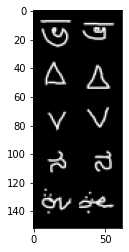

In [11]:
import matplotlib.pylab as plt
from torchvision import utils
X, y = tasksets.train.sample()
print("X.size:", X.size())
grid = utils.make_grid(X, nrow=shots * 2)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

In [12]:
def get_indices(X, ways, shots):
    # Separate data into Meta-Train/Meta-Test sets
    meta_train_indices = np.zeros(X.size(0), dtype=bool)
    # print("X:", X.size())
    meta_train_indices[np.arange(shots * ways) * 2] = True
    meta_test_indices = torch.from_numpy(~meta_train_indices)
    meta_train_indices = torch.from_numpy(meta_train_indices)
    return meta_train_indices, meta_test_indices

def accuracy(predictions, targets):
    predictions = predictions.argmax(dim=1).view(targets.shape)
    return (predictions == targets).sum().float() / targets.size(0)

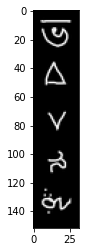

In [13]:
meta_train_indices, meta_test_indices = get_indices(X=X, ways=ways, shots=shots)
#Adaptation Data
grid = utils.make_grid(X[meta_train_indices], nrow=shots)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

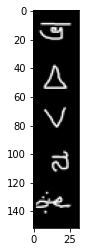

In [14]:
#Adaptation Data
grid = utils.make_grid(X[meta_test_indices], nrow=shots)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

Validation: tensor([3, 3, 2, 2, 4, 4, 0, 0, 1, 1])


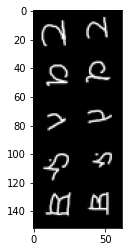

In [15]:
X, y = tasksets.validation.sample()
print("Validation:", y)
grid = utils.make_grid(X, nrow=shots*2)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

Test: tensor([3, 3, 0, 0, 4, 4, 1, 1, 2, 2])


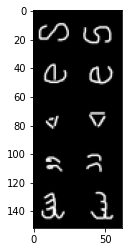

In [16]:
X, y = tasksets.test.sample()
print("Test:", y)
grid = utils.make_grid(X, nrow=shots * 2)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

In [17]:
# model = resnet.ResNet18S(out_dim=ways).to(device)
model = LeNetwork(out_dim=10, in_channel=1, img_sz=28)#.to(device)
print(model)
# model = resnet18(pretrained=True).to(device)
# for param in model.parameters():
#     param.requires_grad = False
# num_ftrs = model.fc.in_features

# num_ftrs 
# model.fc = nn.Linear(num_ftrs, ways).to(device)

# print(model(torch.rand((1,3,84,84)).to(device)))
# torchsummary.summary(model, input_size= (3, 84, 84))

LeNet(
  (conv): Sequential(
    (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Sequential(
    (0): Linear(in_features=2450, out_features=500, bias=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (last): Linear(in_features=500, out_features=10, bias=True)
)


In [18]:
# print(model.conv1.weight[0].grad)

In [19]:


# def main(argv):
    

In [ ]:
meta_lr = 0.001
fast_lr = 0.01
optim_meta = optim.Adam(model.parameters(), lr=meta_lr)

# Per layer different learning rate
# optim_meta = optim.Adam([
#     {"params": model.conv.parameters(), "lr": meta_lr},
#     {"params": model.linear.parameters(), "lr": 0.9}
# ])
epochs = 60000
WANDB_LOGGER = True
adaptation_steps = 1

if(WANDB_LOGGER):
    import wandb
    wandb.init(project="JOmniGlot", entity="hikmatkhan-", reinit=True)
    wandb.watch(model, log_freq=10)
    wandb.log({"Dataset":dataset_name,
              "Ways":ways,
              "Shots":shots,
              "Meta Batch": meta_batch,
              "Meta_lr": meta_lr,
              "Fast_lr": fast_lr,
              "Adaptation Step": adaptation_steps,
              "Jupyter-Run:": "Jupyter-Maml-With_Higher"})
#             if __name__ == "__main__":

#     meta_train_spt_loss = mlogger.metric.Average()
#     meta_train_spt_acc = mlogger.metric.Average()
#     meta_train_qry_loss = mlogger.metric.Average()
#     meta_train_qry_acc = mlogger.metric.Average()

for e in range(epochs):
    optim_meta.zero_grad()
    model.train()
    meta_train_loss = mlogger.metric.Average()
    meta_train_acc = mlogger.metric.Average()
    meta_val_loss = mlogger.metric.Average()
    meta_val_acc = mlogger.metric.Average()
    meta_test_loss = mlogger.metric.Average()
    meta_test_acc = mlogger.metric.Average()
    for t in range(meta_batch):
        X, y = tasksets.train.sample()

#         X, y = X.to(device), y.to(device)
#             print(X.size())
        meta_train_indices, meta_test_indices = get_indices(X=X, ways=ways, shots=shots)
        optim_fast = optim.Adam(model.parameters(), lr=fast_lr)
        with higher.innerloop_ctx(model=model, opt=optim_fast, copy_initial_weights=False#, device=device
                                 ) as (fmodel, diff_opp):

            for a in range(adaptation_steps):
                y_prd = fmodel(X[meta_train_indices])
                meta_train_spt_loss = F.cross_entropy(y_prd, y[meta_train_indices])
                diff_opp.step(meta_train_spt_loss)#, params=fmodel.parameters())
#                 print("Inner-Norm:", torch.norm(fmodel.conv[0].weight[0].data))

            y_prd = fmodel(X[meta_test_indices])
            meta_train_acc.update(accuracy(y_prd, y[meta_test_indices]))
            meta_train_qry_loss = F.cross_entropy(y_prd, y[meta_test_indices])
            
                            
#             grad_of_grads = torch.autograd.grad(meta_train_qry_loss, fmodel.parameters(time=0))
#             print(grad_of_grads)
#             break
            
            
            meta_train_loss.update(meta_train_qry_loss.detach().cpu().item())
            meta_train_qry_loss.backward()
            

        del X, y, meta_train_indices, meta_test_indices
        
    optim_meta.step()
#     print("Outer-Norm:", torch.norm(model.conv[0].weight[0].data))
    
#     print("Meta-Update:", meta_train_loss.value)
    if(WANDB_LOGGER):
        wandb.log({"Meta Update": e})
        wandb.log({"Meta-Learner Norm": torch.norm(model.conv[0].weight[0].data)})
#     print("Meta-Update")

    for t in range(meta_batch):
        model.eval()
        X_val, y_val = tasksets.validation.sample()
#         X_val, y_val = X_val.to(device), y_val.to(device)

#             print(X.size())
        meta_train_indices, meta_test_indices = get_indices(X=X_val, ways=ways, shots=shots)
        optim_fast = optim.Adam(model.parameters(), lr=fast_lr)
        with higher.innerloop_ctx(model=model, opt=optim_fast,  track_higher_grads=False#, device=device
                                 ) as (fmodel, diff_opp):


#                 print(fmodel.conv1.weight[0].grad)
            for a in range(adaptation_steps):
                y_prd = fmodel(X_val[meta_train_indices])
#                     a_meta_train_spt_acc.update(accuracy(y_prd, y[meta_train_indices]))
                meta_val_spt_loss = F.cross_entropy(y_prd, y_val[meta_train_indices])
#                     a_meta_train_spt_loss.update(meta_train_spt_loss.detach().cpu().item())
                diff_opp.step(meta_val_spt_loss)#, params=fmodel.parameters())
#                 meta_train_spt_loss.update(a_meta_train_spt_loss.value)
#                 meta_train_spt_acc.update(a_meta_train_spt_acc.value)

            y_prd = fmodel(X_val[meta_test_indices])
            meta_val_acc.update(accuracy(y_prd, y_val[meta_test_indices]))
            meta_val_qry_loss = F.cross_entropy(y_prd, y_val[meta_test_indices])
            meta_val_loss.update(meta_val_qry_loss.detach().cpu().item())


        del X_val, y_val, meta_train_indices, meta_test_indices
    
    for t in range(meta_batch):
        model.eval()
        X_test, y_test = tasksets.test.sample()
#         X_test, y_test = X_test.to(device), y_test.to(device)

        meta_train_indices, meta_test_indices = get_indices(X=X_test, ways=ways, shots=shots)
        optim_fast = optim.Adam(model.parameters(), lr=fast_lr)
        with higher.innerloop_ctx(model=model, opt=optim_fast,  track_higher_grads=False#, device=device
                                 ) as (fmodel, diff_opp):


#                 print(fmodel.conv1.weight[0].grad)
            for a in range(adaptation_steps):
                y_prd = fmodel(X_test[meta_train_indices])
#                     a_meta_train_spt_acc.update(accuracy(y_prd, y[meta_train_indices]))
                meta_test_spt_loss = F.cross_entropy(y_prd, y_test[meta_train_indices])
#                     a_meta_train_spt_loss.update(meta_train_spt_loss.detach().cpu().item())
                diff_opp.step(meta_test_spt_loss)#, params=fmodel.parameters())
#                 meta_train_spt_loss.update(a_meta_train_spt_loss.value)
#                 meta_train_spt_acc.update(a_meta_train_spt_acc.value)

            y_prd = fmodel(X_test[meta_test_indices])
            meta_test_acc.update(accuracy(y_prd, y_test[meta_test_indices]))
            meta_test_qry_loss = F.cross_entropy(y_prd, y_test[meta_test_indices])
            meta_test_loss.update(meta_test_qry_loss.detach().cpu().item())
            
            del X_test, y_test, meta_train_indices, meta_test_indices


#                 meta_train_qry_loss.backward()

    if(WANDB_LOGGER):
        wandb.log({
               "Meta Train Acc": meta_train_acc.value,
               "Meta Train Loss": meta_train_loss.value,
                "Meta Val Acc": meta_val_acc.value,
                "Meta Val Loss": meta_val_loss.value,
                "Meta Test Acc": meta_test_acc.value,
                "Meta Test Loss": meta_test_loss.value
               })
    print("Epoch|", e, "|", "Meta Train Acc:", meta_train_acc.value, " Meta Train Loss:", meta_train_loss.value,
         "Meta Val Acc:", meta_val_acc.value, " Meta Val Loss:", meta_val_loss.value,
         "Meta Test Acc:", meta_test_acc.value, " Meta Test Loss:", meta_test_loss.value)


    meta_train_loss.reset()
    meta_train_acc.reset()
    meta_val_loss.reset()
    meta_val_acc.reset()
    meta_test_loss.reset()
    meta_test_acc.reset()

                
    

wandb: Currently logged in as: hikmatkhan- (use `wandb login --relogin` to force relogin)


Epoch| 0 | Meta Train Acc: 0.8250000104308128  Meta Train Loss: 0.5658668391406536 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 2.0918128192424774 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.2064004838466644
Epoch| 1 | Meta Train Acc: 0.7500000055879356  Meta Train Loss: 0.8426019977778195 Meta Val Acc: 0.25000000558793545  Meta Val Loss: 2.4231925308704376 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 2.4375263452529907
Epoch| 2 | Meta Train Acc: 0.775000013411045  Meta Train Loss: 0.7185830511152744 Meta Val Acc: 0.2750000040978193  Meta Val Loss: 2.5179610848426814 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.0378112345933914
Epoch| 3 | Meta Train Acc: 0.675000011920929  Meta Train Loss: 1.004109650850296 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 2.2175295054912567 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 2.6645596623420715
Epoch| 4 | Meta Train Acc: 0.8750000074505806  Meta Train Loss: 0.7999941594898701 Meta Val Acc: 0.275000005960464

Epoch| 37 | Meta Train Acc: 0.6500000134110451  Meta Train Loss: 0.9657186828553677 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 2.322312742471695 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 2.473906695842743
Epoch| 38 | Meta Train Acc: 0.7000000104308128  Meta Train Loss: 0.908505336381495 Meta Val Acc: 0.2750000059604644  Meta Val Loss: 1.9813884645700455 Meta Test Acc: 0.2750000040978193  Meta Test Loss: 2.631877273321152
Epoch| 39 | Meta Train Acc: 0.800000011920929  Meta Train Loss: 0.6579096745699644 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 2.123609885573387 Meta Test Acc: 0.3250000048428774  Meta Test Loss: 2.1087331771850586
Epoch| 40 | Meta Train Acc: 0.8000000081956385  Meta Train Loss: 0.7248408775776626 Meta Val Acc: 0.2750000040978193  Meta Val Loss: 2.563402131199837 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 2.300717145204544
Epoch| 41 | Meta Train Acc: 0.7500000111758709  Meta Train Loss: 0.7368905022740363 Meta Val Acc: 0.22500000335276127  

Epoch| 74 | Meta Train Acc: 0.5750000141561031  Meta Train Loss: 1.1602421291172504 Meta Val Acc: 0.30000000447034836  Meta Val Loss: 1.6810244768857958 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 1.9802872389554977
Epoch| 75 | Meta Train Acc: 0.7750000059604645  Meta Train Loss: 0.7460126131772996 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 1.9818182438611984 Meta Test Acc: 0.3000000044703483  Meta Test Loss: 1.9182119220495226
Epoch| 76 | Meta Train Acc: 0.7500000111758709  Meta Train Loss: 0.6936874091625214 Meta Val Acc: 0.3000000044703483  Meta Val Loss: 1.6738221645355225 Meta Test Acc: 0.32500000670552254  Meta Test Loss: 1.6939560025930405
Epoch| 77 | Meta Train Acc: 0.8500000052154063  Meta Train Loss: 0.5559432487934827 Meta Val Acc: 0.3000000063329935  Meta Val Loss: 1.6337127834558487 Meta Test Acc: 0.2750000059604644  Meta Test Loss: 2.094239428639412
Epoch| 78 | Meta Train Acc: 0.5000000111758709  Meta Train Loss: 1.344465285539627 Meta Val Acc: 0.25000000372

Epoch| 111 | Meta Train Acc: 0.8500000089406967  Meta Train Loss: 0.6309225037693977 Meta Val Acc: 0.30000000447034836  Meta Val Loss: 1.9298490583896637 Meta Test Acc: 0.3000000063329935  Meta Test Loss: 2.147413581609726
Epoch| 112 | Meta Train Acc: 0.7250000108033419  Meta Train Loss: 0.6441799141466616 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 2.2230669260025024 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 2.037388652563095
Epoch| 113 | Meta Train Acc: 0.6750000100582838  Meta Train Loss: 1.0174998501315713 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 2.092132404446602 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 2.511007785797119
Epoch| 114 | Meta Train Acc: 0.8250000067055225  Meta Train Loss: 0.5003887042403221 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 2.0991776585578923 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 1.9142937064170835
Epoch| 115 | Meta Train Acc: 0.7000000104308128  Meta Train Loss: 0.9141785437241197 Meta Val Acc: 0.3500000

Epoch| 148 | Meta Train Acc: 0.7750000078231096  Meta Train Loss: 0.7308657467365265 Meta Val Acc: 0.4000000096857548  Meta Val Loss: 1.6931808590888977 Meta Test Acc: 0.3500000052154064  Meta Test Loss: 1.5651239454746246
Epoch| 149 | Meta Train Acc: 0.6250000111758709  Meta Train Loss: 1.0407597683370113 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 1.8168663084506989 Meta Test Acc: 0.3000000044703483  Meta Test Loss: 1.5864992141723633
Epoch| 150 | Meta Train Acc: 0.6750000156462193  Meta Train Loss: 1.0783494673669338 Meta Val Acc: 0.2750000059604645  Meta Val Loss: 1.6050401777029037 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 1.7964090257883072
Epoch| 151 | Meta Train Acc: 0.8500000052154064  Meta Train Loss: 0.6295879185199736 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 1.7588478773832321 Meta Test Acc: 0.2750000040978193  Meta Test Loss: 1.7210593521595003
Epoch| 152 | Meta Train Acc: 0.9000000022351741  Meta Train Loss: 0.46945017576217657 Meta Val Acc: 0.25000

Epoch| 185 | Meta Train Acc: 0.8750000037252903  Meta Train Loss: 0.4643590310588479 Meta Val Acc: 0.3250000048428774  Meta Val Loss: 1.8887376934289932 Meta Test Acc: 0.32500000670552254  Meta Test Loss: 1.9066278487443922
Epoch| 186 | Meta Train Acc: 0.7250000052154064  Meta Train Loss: 0.7089490201324226 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 1.9217433780431745 Meta Test Acc: 0.25000000558793545  Meta Test Loss: 1.8824687600135805
Epoch| 187 | Meta Train Acc: 0.7000000141561031  Meta Train Loss: 1.024302676320076 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 1.8342749327421188 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 1.86554653942585
Epoch| 188 | Meta Train Acc: 0.7500000093132257  Meta Train Loss: 0.8443845929577947 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 1.8452503681182861 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 1.859701156616211
Epoch| 189 | Meta Train Acc: 0.6500000152736902  Meta Train Loss: 1.0189587026834488 Meta Val Acc: 0.30000000

Epoch| 222 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 0.849263709038496 Meta Val Acc: 0.3250000067055225  Meta Val Loss: 1.86684849858284 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 1.7789608836174011
Epoch| 223 | Meta Train Acc: 0.8500000052154064  Meta Train Loss: 0.70043701864779 Meta Val Acc: 0.25000000558793545  Meta Val Loss: 1.9279732108116152 Meta Test Acc: 0.30000000819563866  Meta Test Loss: 1.8708387613296509
Epoch| 224 | Meta Train Acc: 0.7500000111758709  Meta Train Loss: 0.8531247712671756 Meta Val Acc: 0.3000000063329935  Meta Val Loss: 1.841435790061951 Meta Test Acc: 0.1750000026077032  Meta Test Loss: 1.8820544630289076
Epoch| 225 | Meta Train Acc: 0.9000000059604645  Meta Train Loss: 0.47154411487281317 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 1.8038322925567627 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 1.9033784121274948
Epoch| 226 | Meta Train Acc: 0.6250000130385162  Meta Train Loss: 1.2025591917335987 Meta Val Acc: 0.2750000059

Epoch| 259 | Meta Train Acc: 0.7250000089406967  Meta Train Loss: 0.8068168498575686 Meta Val Acc: 0.37500000558793545  Meta Val Loss: 1.7594244182109833 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 1.7840902358293533
Epoch| 260 | Meta Train Acc: 0.7000000067055225  Meta Train Loss: 0.8969238875433803 Meta Val Acc: 0.3500000070780515  Meta Val Loss: 1.7159693092107773 Meta Test Acc: 0.2750000040978193  Meta Test Loss: 1.7145422101020813
Epoch| 261 | Meta Train Acc: 0.6250000111758709  Meta Train Loss: 0.9904358470812441 Meta Val Acc: 0.3000000063329935  Meta Val Loss: 1.7977652996778488 Meta Test Acc: 0.25000000558793545  Meta Test Loss: 1.6883410513401031
Epoch| 262 | Meta Train Acc: 0.7500000093132257  Meta Train Loss: 0.8741238191723824 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 1.8007284253835678 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 1.769201532006264
Epoch| 263 | Meta Train Acc: 0.6000000145286323  Meta Train Loss: 1.0743313170969486 Meta Val Acc: 0.325000

Epoch| 296 | Meta Train Acc: 0.8750000074505806  Meta Train Loss: 0.38132576178759336 Meta Val Acc: 0.37500000558793545  Meta Val Loss: 1.7806188762187958 Meta Test Acc: 0.32500000670552254  Meta Test Loss: 1.7043138295412064
Epoch| 297 | Meta Train Acc: 0.8250000104308128  Meta Train Loss: 0.7276800228282809 Meta Val Acc: 0.35000000707805157  Meta Val Loss: 1.7865689545869827 Meta Test Acc: 0.2750000059604645  Meta Test Loss: 1.795692875981331
Epoch| 298 | Meta Train Acc: 0.7000000104308127  Meta Train Loss: 0.9141829628497363 Meta Val Acc: 0.2750000059604644  Meta Val Loss: 1.7429013699293134 Meta Test Acc: 0.3000000044703483  Meta Test Loss: 1.739920988678932
Epoch| 299 | Meta Train Acc: 0.6250000093132256  Meta Train Loss: 1.021685446612537 Meta Val Acc: 0.3500000052154064  Meta Val Loss: 1.6943672448396683 Meta Test Acc: 0.3750000074505806  Meta Test Loss: 1.6637849807739258
Epoch| 300 | Meta Train Acc: 0.8000000044703484  Meta Train Loss: 0.8695746418088676 Meta Val Acc: 0.325000

Epoch| 333 | Meta Train Acc: 0.8500000089406967  Meta Train Loss: 0.4451251085847616 Meta Val Acc: 0.3500000089406967  Meta Val Loss: 1.627419337630272 Meta Test Acc: 0.42500001005828386  Meta Test Loss: 1.6755843907594683
Epoch| 334 | Meta Train Acc: 0.7750000096857548  Meta Train Loss: 0.7411700626835227 Meta Val Acc: 0.45000001043081284  Meta Val Loss: 1.5735574662685394 Meta Test Acc: 0.35000000707805157  Meta Test Loss: 1.665263757109642
Epoch| 335 | Meta Train Acc: 0.8500000089406967  Meta Train Loss: 0.6757735209539534 Meta Val Acc: 0.42500001192092896  Meta Val Loss: 1.6954808086156845 Meta Test Acc: 0.37500000745058054  Meta Test Loss: 1.6772334426641464
Epoch| 336 | Meta Train Acc: 0.7500000037252902  Meta Train Loss: 0.8101481068879367 Meta Val Acc: 0.4000000115484  Meta Val Loss: 1.6995947510004044 Meta Test Acc: 0.3000000063329935  Meta Test Loss: 1.7023373097181322
Epoch| 337 | Meta Train Acc: 0.6250000074505806  Meta Train Loss: 1.2792902365326881 Meta Val Acc: 0.2750000

Epoch| 370 | Meta Train Acc: 0.6250000093132257  Meta Train Loss: 1.1043314505368471 Meta Val Acc: 0.42500001192092896  Meta Val Loss: 1.719354748725891 Meta Test Acc: 0.3250000067055225  Meta Test Loss: 1.759868994355202
Epoch| 371 | Meta Train Acc: 0.7500000055879353  Meta Train Loss: 0.8033923916518689 Meta Val Acc: 0.3500000089406967  Meta Val Loss: 1.7021521925926208 Meta Test Acc: 0.32500000856816763  Meta Test Loss: 1.7071045041084287
Epoch| 372 | Meta Train Acc: 0.7750000059604645  Meta Train Loss: 0.646383968181908 Meta Val Acc: 0.3500000089406967  Meta Val Loss: 1.6858872771263125 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 1.7526321113109589
Epoch| 373 | Meta Train Acc: 0.6500000171363354  Meta Train Loss: 0.7256181426346302 Meta Val Acc: 0.450000012293458  Meta Val Loss: 1.6073278486728668 Meta Test Acc: 0.40000000782310957  Meta Test Loss: 1.6658195555210114
Epoch| 374 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 0.6494351644068956 Meta Val Acc: 0.35000000

Epoch| 407 | Meta Train Acc: 0.6750000063329934  Meta Train Loss: 0.9019186403602362 Meta Val Acc: 0.3250000048428774  Meta Val Loss: 1.489402636885643 Meta Test Acc: 0.3250000067055225  Meta Test Loss: 1.6329841613769531
Epoch| 408 | Meta Train Acc: 0.7250000089406967  Meta Train Loss: 0.73111542314291 Meta Val Acc: 0.4500000104308129  Meta Val Loss: 1.5161260962486267 Meta Test Acc: 0.3500000052154064  Meta Test Loss: 1.4403269439935686
Epoch| 409 | Meta Train Acc: 0.6000000145286322  Meta Train Loss: 0.9934503734111787 Meta Val Acc: 0.32500000670552254  Meta Val Loss: 1.5211725234985352 Meta Test Acc: 0.35000000707805157  Meta Test Loss: 1.5831201523542406
Epoch| 410 | Meta Train Acc: 0.575000014156103  Meta Train Loss: 1.1550362035632136 Meta Val Acc: 0.37500000931322575  Meta Val Loss: 1.457420527935028 Meta Test Acc: 0.3000000044703483  Meta Test Loss: 1.5705598890781405
Epoch| 411 | Meta Train Acc: 0.8750000074505806  Meta Train Loss: 0.43053593300282955 Meta Val Acc: 0.37500000

Epoch| 444 | Meta Train Acc: 0.6500000134110451  Meta Train Loss: 0.9879077505320311 Meta Val Acc: 0.3750000074505806  Meta Val Loss: 1.5088364779949188 Meta Test Acc: 0.32500000670552254  Meta Test Loss: 1.5247520506381989
Epoch| 445 | Meta Train Acc: 0.7000000104308128  Meta Train Loss: 1.1765403151512146 Meta Val Acc: 0.47500001452863216  Meta Val Loss: 1.4101167172193527 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 1.4366814792156217
Epoch| 446 | Meta Train Acc: 0.6250000149011612  Meta Train Loss: 1.1896527633070944 Meta Val Acc: 0.4000000078231097  Meta Val Loss: 1.477117896080017 Meta Test Acc: 0.35000000707805157  Meta Test Loss: 1.4994593560695646
Epoch| 447 | Meta Train Acc: 0.800000011920929  Meta Train Loss: 0.6845791805535555 Meta Val Acc: 0.3750000055879354  Meta Val Loss: 1.5881540328264234 Meta Test Acc: 0.3250000067055225  Meta Test Loss: 1.4989822506904604
Epoch| 448 | Meta Train Acc: 0.6750000156462193  Meta Train Loss: 1.093058967962861 Meta Val Acc: 0.400000

Epoch| 481 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 1.0130310468375683 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 1.5745101869106295 Meta Test Acc: 0.35000000707805157  Meta Test Loss: 1.5370306819677355
Epoch| 482 | Meta Train Acc: 0.8250000104308128  Meta Train Loss: 0.6744794412516057 Meta Val Acc: 0.3750000074505806  Meta Val Loss: 1.5607146173715591 Meta Test Acc: 0.3750000074505806  Meta Test Loss: 1.533946692943573
Epoch| 483 | Meta Train Acc: 0.7000000085681678  Meta Train Loss: 0.9727065246552229 Meta Val Acc: 0.2750000059604644  Meta Val Loss: 1.5753588527441025 Meta Test Acc: 0.2750000040978193  Meta Test Loss: 1.5172148197889328
Epoch| 484 | Meta Train Acc: 0.7250000163912773  Meta Train Loss: 0.81196697242558 Meta Val Acc: 0.32500000856816763  Meta Val Loss: 1.5651275068521502 Meta Test Acc: 0.35000000707805157  Meta Test Loss: 1.5148489624261854
Epoch| 485 | Meta Train Acc: 0.6000000108033419  Meta Train Loss: 1.2560618855059147 Meta Val Acc: 0.3000000

Epoch| 518 | Meta Train Acc: 0.800000011920929  Meta Train Loss: 0.6640375987626612 Meta Val Acc: 0.3000000063329935  Meta Val Loss: 1.499937877058983 Meta Test Acc: 0.2250000033527613  Meta Test Loss: 1.5454525053501131
Epoch| 519 | Meta Train Acc: 0.6750000063329935  Meta Train Loss: 1.0215457854792476 Meta Val Acc: 0.4250000100582838  Meta Val Loss: 1.3992164582014084 Meta Test Acc: 0.37500000931322575  Meta Test Loss: 1.4607675820589066
Epoch| 520 | Meta Train Acc: 0.6250000149011612  Meta Train Loss: 1.0870014075189829 Meta Val Acc: 0.35000000707805157  Meta Val Loss: 1.500647857785225 Meta Test Acc: 0.3500000070780515  Meta Test Loss: 1.5477484166622162
Epoch| 521 | Meta Train Acc: 0.8750000074505806  Meta Train Loss: 0.6140844132751226 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 1.5613665580749512 Meta Test Acc: 0.4250000137835741  Meta Test Loss: 1.4521535634994507
Epoch| 522 | Meta Train Acc: 0.6750000137835741  Meta Train Loss: 0.7410118095576763 Meta Val Acc: 0.32500000

Epoch| 555 | Meta Train Acc: 0.7000000141561031  Meta Train Loss: 0.9624974252656102 Meta Val Acc: 0.32500000670552254  Meta Val Loss: 1.5658651292324066 Meta Test Acc: 0.32500000670552254  Meta Test Loss: 1.5238422974944115
Epoch| 556 | Meta Train Acc: 0.6250000093132257  Meta Train Loss: 0.8918677726760506 Meta Val Acc: 0.3750000093132257  Meta Val Loss: 1.4596727043390274 Meta Test Acc: 0.3000000063329935  Meta Test Loss: 1.583479955792427
Epoch| 557 | Meta Train Acc: 0.7750000134110451  Meta Train Loss: 0.7206118404865265 Meta Val Acc: 0.2750000059604645  Meta Val Loss: 1.635309025645256 Meta Test Acc: 0.3250000048428774  Meta Test Loss: 1.6366560757160187
Epoch| 558 | Meta Train Acc: 0.8250000067055225  Meta Train Loss: 0.5162559943273662 Meta Val Acc: 0.35000000707805157  Meta Val Loss: 1.5582645237445831 Meta Test Acc: 0.3750000055879354  Meta Test Loss: 1.5878939181566238
Epoch| 559 | Meta Train Acc: 0.7750000096857548  Meta Train Loss: 0.7451026868075131 Meta Val Acc: 0.400000

Epoch| 592 | Meta Train Acc: 0.700000012293458  Meta Train Loss: 0.7891750847920774 Meta Val Acc: 0.32500000670552254  Meta Val Loss: 1.7115681320428848 Meta Test Acc: 0.32500000670552254  Meta Test Loss: 1.624353513121605
Epoch| 593 | Meta Train Acc: 0.7750000134110451  Meta Train Loss: 0.5955713214352727 Meta Val Acc: 0.3500000070780515  Meta Val Loss: 1.6866372078657148 Meta Test Acc: 0.2750000040978193  Meta Test Loss: 1.6301389187574387
Epoch| 594 | Meta Train Acc: 0.8250000104308128  Meta Train Loss: 0.6083613736554981 Meta Val Acc: 0.4000000059604645  Meta Val Loss: 1.650107651948929 Meta Test Acc: 0.32500000670552254  Meta Test Loss: 1.6219429075717926
Epoch| 595 | Meta Train Acc: 0.7500000037252903  Meta Train Loss: 0.8398739229887724 Meta Val Acc: 0.4000000059604645  Meta Val Loss: 1.5803107619285583 Meta Test Acc: 0.3500000089406967  Meta Test Loss: 1.6266943365335464
Epoch| 596 | Meta Train Acc: 0.7500000149011612  Meta Train Loss: 0.6692601013928652 Meta Val Acc: 0.2750000

Epoch| 629 | Meta Train Acc: 0.7000000104308128  Meta Train Loss: 1.1856133323162796 Meta Val Acc: 0.3500000089406967  Meta Val Loss: 1.6302636563777924 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 1.5703209787607193
Epoch| 630 | Meta Train Acc: 0.8500000052154063  Meta Train Loss: 0.5755730101373048 Meta Val Acc: 0.4000000078231096  Meta Val Loss: 1.561616837978363 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 1.797142744064331
Epoch| 631 | Meta Train Acc: 0.575000014156103  Meta Train Loss: 1.05866539478302 Meta Val Acc: 0.35000000894069666  Meta Val Loss: 1.6296432465314865 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 1.6064856201410294
Epoch| 632 | Meta Train Acc: 0.6000000070780517  Meta Train Loss: 1.1159625835716724 Meta Val Acc: 0.2750000040978193  Meta Val Loss: 1.676220417022705 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 1.6786941885948181
Epoch| 633 | Meta Train Acc: 0.7500000149011612  Meta Train Loss: 0.7801697147078812 Meta Val Acc: 0.2750000040

Epoch| 666 | Meta Train Acc: 0.7000000141561031  Meta Train Loss: 0.7812126390635967 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 1.743172511458397 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 1.915445730090141
Epoch| 667 | Meta Train Acc: 0.8250000067055225  Meta Train Loss: 0.5204834127798676 Meta Val Acc: 0.2750000059604644  Meta Val Loss: 1.7696117758750916 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.9362292885780334
Epoch| 668 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 0.9347605714574455 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 1.9875795394182205 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 1.8080016523599625
Epoch| 669 | Meta Train Acc: 0.6750000156462193  Meta Train Loss: 0.8197083584964275 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 1.8647124767303467 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 1.7873041927814486
Epoch| 670 | Meta Train Acc: 0.7500000149011612  Meta Train Loss: 0.8008896866813301 Meta Val Acc: 0.200000

Epoch| 703 | Meta Train Acc: 0.7000000141561031  Meta Train Loss: 0.6545781884342431 Meta Val Acc: 0.3250000067055225  Meta Val Loss: 2.5198100209236145 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 2.4526509046554565
Epoch| 704 | Meta Train Acc: 0.675000011920929  Meta Train Loss: 1.1735010258853436 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 2.1978898644447327 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 2.5001700073480606
Epoch| 705 | Meta Train Acc: 0.8250000104308128  Meta Train Loss: 0.7313156500458716 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 2.467858761548996 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 2.265659511089325
Epoch| 706 | Meta Train Acc: 0.8250000067055225  Meta Train Loss: 0.5258405990898609 Meta Val Acc: 0.3000000063329935  Meta Val Loss: 2.3874418139457703 Meta Test Acc: 0.2750000040978193  Meta Test Loss: 2.1744637340307236
Epoch| 707 | Meta Train Acc: 0.6500000171363353  Meta Train Loss: 1.4166275262832642 Meta Val Acc: 0.275000004

Epoch| 740 | Meta Train Acc: 0.6750000156462193  Meta Train Loss: 1.5685329027473927 Meta Val Acc: 0.30000000447034836  Meta Val Loss: 4.364121705293655 Meta Test Acc: 0.32500000670552254  Meta Test Loss: 4.762857139110565
Epoch| 741 | Meta Train Acc: 0.5750000178813934  Meta Train Loss: 1.2728088051080706 Meta Val Acc: 0.30000000447034836  Meta Val Loss: 4.753077805042266 Meta Test Acc: 0.35000000707805157  Meta Test Loss: 4.759870797395707
Epoch| 742 | Meta Train Acc: 0.6250000186264515  Meta Train Loss: 1.4890417978167536 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 4.685786575078964 Meta Test Acc: 0.32500000484287733  Meta Test Loss: 4.1266403794288635
Epoch| 743 | Meta Train Acc: 0.7750000134110451  Meta Train Loss: 0.7236418016254901 Meta Val Acc: 0.4000000096857548  Meta Val Loss: 4.320511847734451 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 4.609407424926758
Epoch| 744 | Meta Train Acc: 0.6750000156462191  Meta Train Loss: 1.2651866413652897 Meta Val Acc: 0.35000000

Epoch| 777 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 1.1810580752789976 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 4.835138946771622 Meta Test Acc: 0.3000000044703483  Meta Test Loss: 4.962529540061951
Epoch| 778 | Meta Train Acc: 0.6500000134110451  Meta Train Loss: 1.1256187222898009 Meta Val Acc: 0.2750000040978193  Meta Val Loss: 5.51130473613739 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 4.744766652584077
Epoch| 779 | Meta Train Acc: 0.700000012293458  Meta Train Loss: 0.9600941985845566 Meta Val Acc: 0.32500000484287733  Meta Val Loss: 4.60643470287323 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 4.65693661570549
Epoch| 780 | Meta Train Acc: 0.6000000108033418  Meta Train Loss: 1.0828393511474133 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 3.9798526763916025 Meta Test Acc: 0.3000000063329935  Meta Test Loss: 4.385883867740632
Epoch| 781 | Meta Train Acc: 0.5000000111758709  Meta Train Loss: 1.61999386921525 Meta Val Acc: 0.2750000040978193 

Epoch| 814 | Meta Train Acc: 0.6500000096857548  Meta Train Loss: 1.2842243146151304 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 2.579285889863968 Meta Test Acc: 0.22500000521540642  Meta Test Loss: 3.033338040113449
Epoch| 815 | Meta Train Acc: 0.7500000074505806  Meta Train Loss: 1.0112615125253797 Meta Val Acc: 0.30000000447034836  Meta Val Loss: 2.952221304178238 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 3.2468101680278774
Epoch| 816 | Meta Train Acc: 0.6250000149011612  Meta Train Loss: 1.6366932764649391 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 3.068231374025345 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 2.819277822971344
Epoch| 817 | Meta Train Acc: 0.7000000141561031  Meta Train Loss: 1.1047888025641441 Meta Val Acc: 0.32500000670552254  Meta Val Loss: 3.109648674726486 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 3.1361804008483887
Epoch| 818 | Meta Train Acc: 0.8250000067055225  Meta Train Loss: 0.7511657914146781 Meta Val Acc: 0.275000

Epoch| 851 | Meta Train Acc: 0.550000011920929  Meta Train Loss: 1.3964606150984764 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 3.638525784015656 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 3.710856109857559
Epoch| 852 | Meta Train Acc: 0.6000000052154064  Meta Train Loss: 1.3393471576273441 Meta Val Acc: 0.3000000044703483  Meta Val Loss: 3.5300141870975494 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 3.3867330849170685
Epoch| 853 | Meta Train Acc: 0.6250000111758709  Meta Train Loss: 1.288655798882246 Meta Val Acc: 0.2750000040978193  Meta Val Loss: 2.986066043376922 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 3.9228645563125606
Epoch| 854 | Meta Train Acc: 0.7000000141561031  Meta Train Loss: 0.9545975597575308 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.9075245559215546 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 4.058096885681152
Epoch| 855 | Meta Train Acc: 0.6750000100582839  Meta Train Loss: 1.1837554327212274 Meta Val Acc: 0.2000000029

Epoch| 888 | Meta Train Acc: 0.7250000163912773  Meta Train Loss: 1.3261544592678547 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 3.2950530648231506 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 3.619040608406067
Epoch| 889 | Meta Train Acc: 0.7250000089406967  Meta Train Loss: 1.1774319559335706 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 4.25749596953392 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 3.1547010242938995
Epoch| 890 | Meta Train Acc: 0.7250000163912773  Meta Train Loss: 1.314862591214478 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 3.2051442563533783 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 3.17161363363266
Epoch| 891 | Meta Train Acc: 0.7750000059604644  Meta Train Loss: 0.6690758299082518 Meta Val Acc: 0.2750000040978193  Meta Val Loss: 3.5700873136520386 Meta Test Acc: 0.2750000059604644  Meta Test Loss: 3.8061282336711884
Epoch| 892 | Meta Train Acc: 0.7000000085681677  Meta Train Loss: 1.259668491780758 Meta Val Acc: 0.250000003

Epoch| 925 | Meta Train Acc: 0.7000000104308128  Meta Train Loss: 1.420041561126709 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.042017042636871 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 3.93697252869606
Epoch| 926 | Meta Train Acc: 0.575000012293458  Meta Train Loss: 1.2898056004196403 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 3.339558720588684 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 3.916418135166168
Epoch| 927 | Meta Train Acc: 0.625000011175871  Meta Train Loss: 1.3539021890610456 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 3.8544389605522156 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 3.471201598644256
Epoch| 928 | Meta Train Acc: 0.6250000111758709  Meta Train Loss: 1.1528163924813268 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 3.4469326436519623 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 3.972521811723709
Epoch| 929 | Meta Train Acc: 0.7000000141561031  Meta Train Loss: 1.015886727720499 Meta Val Acc: 0.22500000335

Epoch| 962 | Meta Train Acc: 0.6250000149011612  Meta Train Loss: 1.477381452918053 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 4.021862715482712 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 4.642966628074646
Epoch| 963 | Meta Train Acc: 0.7250000126659869  Meta Train Loss: 0.8285254314541816 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 4.3411708772182465 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 5.250241011381148
Epoch| 964 | Meta Train Acc: 0.550000011920929  Meta Train Loss: 1.5959461042657492 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.2861168384552 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 4.650563597679138
Epoch| 965 | Meta Train Acc: 0.5750000141561031  Meta Train Loss: 1.632758915424347 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 4.3250924944877625 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 4.827549517154694
Epoch| 966 | Meta Train Acc: 0.6500000115484  Meta Train Loss: 1.2499762549996374 Meta Val Acc: 0.300000004470348

Epoch| 999 | Meta Train Acc: 0.7750000134110451  Meta Train Loss: 1.0485827773809433 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 5.311594218015671 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 5.60309773683548
Epoch| 1000 | Meta Train Acc: 0.6000000108033419  Meta Train Loss: 1.2830815380439162 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 5.303560256958008 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 5.109764039516449
Epoch| 1001 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 0.9689064249396324 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 4.9643475115299225 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.660807013511659
Epoch| 1002 | Meta Train Acc: 0.5250000115483999  Meta Train Loss: 1.717317521572113 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 5.069410145282745 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.256372660398483
Epoch| 1003 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 1.2530919015407562 Meta Val Acc: 0.30000000

Epoch| 1036 | Meta Train Acc: 0.7000000141561031  Meta Train Loss: 0.954619969241321 Meta Val Acc: 0.2750000040978193  Meta Val Loss: 6.491406083106995 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6.792782306671141
Epoch| 1037 | Meta Train Acc: 0.6500000134110451  Meta Train Loss: 1.2080269902944565 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 6.707795590162278 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 6.001023769378662
Epoch| 1038 | Meta Train Acc: 0.5750000085681677  Meta Train Loss: 1.0917839095927775 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 7.272734761238098 Meta Test Acc: 0.2750000040978193  Meta Test Loss: 6.17433899641037
Epoch| 1039 | Meta Train Acc: 0.7500000149011612  Meta Train Loss: 0.8028791174292563 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 6.95482611656189 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 6.241274416446687
Epoch| 1040 | Meta Train Acc: 0.6500000171363353  Meta Train Loss: 1.4158077239990232 Meta Val Acc: 0.25000000

Epoch| 1073 | Meta Train Acc: 0.6000000108033419  Meta Train Loss: 1.31598643027246 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 6.4563475251197815 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 5.477876603603363
Epoch| 1074 | Meta Train Acc: 0.7000000141561031  Meta Train Loss: 1.043751584365964 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 6.552217483520509 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 6.485347270965576
Epoch| 1075 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 0.9855082072317598 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 5.304281800985336 Meta Test Acc: 0.2750000040978193  Meta Test Loss: 5.708989590406418
Epoch| 1076 | Meta Train Acc: 0.8000000081956387  Meta Train Loss: 0.7441761456429958 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 6.077236592769624 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6.74760901927948
Epoch| 1077 | Meta Train Acc: 0.8250000104308128  Meta Train Loss: 0.7561265137046576 Meta Val Acc: 0.30000000447

Epoch| 1110 | Meta Train Acc: 0.6500000115484  Meta Train Loss: 1.402008507400751 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 6.733375430107117 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 6.751834869384766
Epoch| 1111 | Meta Train Acc: 0.8500000052154064  Meta Train Loss: 0.6066312529146671 Meta Val Acc: 0.2750000040978193  Meta Val Loss: 5.626058340072632 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 6.873643636703491
Epoch| 1112 | Meta Train Acc: 0.7750000096857548  Meta Train Loss: 0.9637930560857058 Meta Val Acc: 0.2750000040978193  Meta Val Loss: 8.056439876556396 Meta Test Acc: 0.3000000063329935  Meta Test Loss: 7.378527641296386
Epoch| 1113 | Meta Train Acc: 0.6250000149011612  Meta Train Loss: 1.367914943024516 Meta Val Acc: 0.30000000447034836  Meta Val Loss: 6.369073212146759 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 7.099896967411041
Epoch| 1114 | Meta Train Acc: 0.7000000067055225  Meta Train Loss: 0.8914004303514957 Meta Val Acc: 0.2500000037

Epoch| 1147 | Meta Train Acc: 0.7750000096857548  Meta Train Loss: 0.8860435634851455 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 5.266955137252808 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 4.911601215600967
Epoch| 1148 | Meta Train Acc: 0.6500000115484  Meta Train Loss: 1.0459847603924572 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 5.606505364179611 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 4.47852873802185
Epoch| 1149 | Meta Train Acc: 0.6750000156462193  Meta Train Loss: 0.9267796501517295 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 4.770641803741455 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 4.782198846340179
Epoch| 1150 | Meta Train Acc: 0.7000000141561031  Meta Train Loss: 0.9449977688491344 Meta Val Acc: 0.3250000067055225  Meta Val Loss: 5.1352338790893555 Meta Test Acc: 0.1750000026077032  Meta Test Loss: 4.934776127338409
Epoch| 1151 | Meta Train Acc: 0.7750000078231096  Meta Train Loss: 0.6271433783695101 Meta Val Acc: 0.2750000040

Epoch| 1184 | Meta Train Acc: 0.6750000100582838  Meta Train Loss: 1.063098605722189 Meta Val Acc: 0.2750000059604645  Meta Val Loss: 4.202876657247543 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 3.8751123845577244
Epoch| 1185 | Meta Train Acc: 0.7500000111758709  Meta Train Loss: 0.8629824277013539 Meta Val Acc: 0.2750000059604644  Meta Val Loss: 4.399977624416351 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 4.505969434976578
Epoch| 1186 | Meta Train Acc: 0.6000000163912773  Meta Train Loss: 1.1957031562924385 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 3.9187199473381042 Meta Test Acc: 0.37500000745058054  Meta Test Loss: 3.832644611597061
Epoch| 1187 | Meta Train Acc: 0.7500000149011612  Meta Train Loss: 0.725558266043663 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 4.352696597576141 Meta Test Acc: 0.3000000063329935  Meta Test Loss: 4.184053540229797
Epoch| 1188 | Meta Train Acc: 0.7500000111758709  Meta Train Loss: 0.8079379592090844 Meta Val Acc: 0.350000

Epoch| 1221 | Meta Train Acc: 0.6750000100582839  Meta Train Loss: 1.0348176015540957 Meta Val Acc: 0.3500000089406967  Meta Val Loss: 4.167980313301086 Meta Test Acc: 0.25000000558793545  Meta Test Loss: 3.560021609067917
Epoch| 1222 | Meta Train Acc: 0.6500000171363354  Meta Train Loss: 1.0336452648043633 Meta Val Acc: 0.3000000044703483  Meta Val Loss: 3.4714221358299255 Meta Test Acc: 0.30000000633299345  Meta Test Loss: 3.9522537887096405
Epoch| 1223 | Meta Train Acc: 0.5500000100582837  Meta Train Loss: 1.1645285561680794 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 3.0718148946762085 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 3.485491007566452
Epoch| 1224 | Meta Train Acc: 0.8000000081956387  Meta Train Loss: 1.0179601944983006 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 2.917731061577797 Meta Test Acc: 0.37500000931322575  Meta Test Loss: 3.097459554672241
Epoch| 1225 | Meta Train Acc: 0.6750000081956387  Meta Train Loss: 1.1111668087542055 Meta Val Acc: 0.225

Epoch| 1258 | Meta Train Acc: 0.600000012665987  Meta Train Loss: 1.1781873404979706 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 2.331126108765602 Meta Test Acc: 0.32500000670552254  Meta Test Loss: 2.3160562515258794
Epoch| 1259 | Meta Train Acc: 0.600000012665987  Meta Train Loss: 1.165883205831051 Meta Val Acc: 0.37500000931322586  Meta Val Loss: 2.109784170985222 Meta Test Acc: 0.2750000040978193  Meta Test Loss: 2.1911253184080124
Epoch| 1260 | Meta Train Acc: 0.7000000178813934  Meta Train Loss: 1.1782791875302792 Meta Val Acc: 0.32500000670552254  Meta Val Loss: 2.4598898887634277 Meta Test Acc: 0.3250000048428774  Meta Test Loss: 2.2259310483932495
Epoch| 1261 | Meta Train Acc: 0.6500000171363353  Meta Train Loss: 1.1445251740515232 Meta Val Acc: 0.3250000048428774  Meta Val Loss: 2.272145837545395 Meta Test Acc: 0.25000000558793545  Meta Test Loss: 2.3287637829780574
Epoch| 1262 | Meta Train Acc: 0.6000000201165676  Meta Train Loss: 1.1608112528920174 Meta Val Acc: 0.3250

Epoch| 1295 | Meta Train Acc: 0.7250000126659869  Meta Train Loss: 0.6934541277587414 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 2.394534587860108 Meta Test Acc: 0.30000000819563866  Meta Test Loss: 2.303537741303444
Epoch| 1296 | Meta Train Acc: 0.6750000156462193  Meta Train Loss: 1.0910823121666908 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 2.4957898259162903 Meta Test Acc: 0.2750000040978193  Meta Test Loss: 2.2555140554904938
Epoch| 1297 | Meta Train Acc: 0.7500000111758709  Meta Train Loss: 0.8243362940847874 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 2.1906091272830963 Meta Test Acc: 0.3000000044703483  Meta Test Loss: 2.220560669898987
Epoch| 1298 | Meta Train Acc: 0.7750000096857548  Meta Train Loss: 0.6602082923054695 Meta Val Acc: 0.3000000044703483  Meta Val Loss: 2.1620203405618668 Meta Test Acc: 0.3500000070780515  Meta Test Loss: 2.3361535966396323
Epoch| 1299 | Meta Train Acc: 0.6500000171363354  Meta Train Loss: 1.2601818963885307 Meta Val Acc: 0.25

Epoch| 1332 | Meta Train Acc: 0.675000011920929  Meta Train Loss: 1.2358927465975282 Meta Val Acc: 0.2750000040978193  Meta Val Loss: 2.8211956918239594 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 2.6059553027153015
Epoch| 1333 | Meta Train Acc: 0.5500000156462193  Meta Train Loss: 1.1954421401023863 Meta Val Acc: 0.30000000447034836  Meta Val Loss: 2.5685897767543793 Meta Test Acc: 0.22500000521540642  Meta Test Loss: 2.722570657730103
Epoch| 1334 | Meta Train Acc: 0.6000000108033419  Meta Train Loss: 1.5383844822645187 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 2.849467843770981 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 2.6062965393066406
Epoch| 1335 | Meta Train Acc: 0.6250000093132256  Meta Train Loss: 1.302005035802722 Meta Val Acc: 0.3000000063329935  Meta Val Loss: 2.589510589838028 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 3.200100541114807
Epoch| 1336 | Meta Train Acc: 0.6000000126659869  Meta Train Loss: 1.380536399781704 Meta Val Acc: 0.3250

Epoch| 1369 | Meta Train Acc: 0.6500000096857548  Meta Train Loss: 1.2140138838440182 Meta Val Acc: 0.3250000048428774  Meta Val Loss: 2.739499300718307 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 3.4116430580615997
Epoch| 1370 | Meta Train Acc: 0.675000011920929  Meta Train Loss: 0.979013154283166 Meta Val Acc: 0.40000000782310957  Meta Val Loss: 2.958950489759445 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 3.124227613210678
Epoch| 1371 | Meta Train Acc: 0.7000000141561031  Meta Train Loss: 1.0729350745677948 Meta Val Acc: 0.32500000856816763  Meta Val Loss: 3.1438397765159607 Meta Test Acc: 0.1750000026077032  Meta Test Loss: 3.562846124172211
Epoch| 1372 | Meta Train Acc: 0.675000011920929  Meta Train Loss: 1.2134838569909332 Meta Val Acc: 0.32500000856816763  Meta Val Loss: 2.810521245002746 Meta Test Acc: 0.3000000044703483  Meta Test Loss: 3.2711857855319977
Epoch| 1373 | Meta Train Acc: 0.7500000149011612  Meta Train Loss: 1.0809257589280605 Meta Val Acc: 0.275000

Epoch| 1406 | Meta Train Acc: 0.7750000078231096  Meta Train Loss: 0.70953431352973 Meta Val Acc: 0.3500000070780516  Meta Val Loss: 3.2883541882038116 Meta Test Acc: 0.32500000670552254  Meta Test Loss: 3.401061177253723
Epoch| 1407 | Meta Train Acc: 0.6750000137835741  Meta Train Loss: 0.887954014353454 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 3.3865439891815186 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 3.30158543586731
Epoch| 1408 | Meta Train Acc: 0.6500000078231096  Meta Train Loss: 1.1812241729348898 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 3.5621401965618134 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 3.1179075241088867
Epoch| 1409 | Meta Train Acc: 0.6500000134110451  Meta Train Loss: 0.9574510678648949 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 3.6494311988353725 Meta Test Acc: 0.3500000070780515  Meta Test Loss: 3.539384931325912
Epoch| 1410 | Meta Train Acc: 0.7250000126659869  Meta Train Loss: 1.124847035855055 Meta Val Acc: 0.2750000

Epoch| 1443 | Meta Train Acc: 0.7500000074505807  Meta Train Loss: 0.8725546067580581 Meta Val Acc: 0.3000000044703483  Meta Val Loss: 3.1127313375473022 Meta Test Acc: 0.2750000059604645  Meta Test Loss: 3.1565839350223546
Epoch| 1444 | Meta Train Acc: 0.625000013038516  Meta Train Loss: 1.1491948030889032 Meta Val Acc: 0.35000000707805157  Meta Val Loss: 3.077198475599289 Meta Test Acc: 0.32500000670552254  Meta Test Loss: 3.5859991312026978
Epoch| 1445 | Meta Train Acc: 0.7250000163912772  Meta Train Loss: 0.7805788442492486 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 3.39703705906868 Meta Test Acc: 0.3250000048428774  Meta Test Loss: 3.3160299956798553
Epoch| 1446 | Meta Train Acc: 0.7750000134110452  Meta Train Loss: 0.7534340489655733 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 3.1339958012104034 Meta Test Acc: 0.3250000048428774  Meta Test Loss: 3.0159760415554047
Epoch| 1447 | Meta Train Acc: 0.7250000089406967  Meta Train Loss: 1.0264293476939201 Meta Val Acc: 0.425

Epoch| 1480 | Meta Train Acc: 0.6250000186264515  Meta Train Loss: 1.3201109841465952 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 3.4278720319271088 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 3.3773794472217564
Epoch| 1481 | Meta Train Acc: 0.5750000085681676  Meta Train Loss: 1.4860751703381538 Meta Val Acc: 0.32500000670552254  Meta Val Loss: 3.3848125338554382 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 3.00044584274292
Epoch| 1482 | Meta Train Acc: 0.7250000163912773  Meta Train Loss: 1.0099440943449733 Meta Val Acc: 0.3500000070780516  Meta Val Loss: 3.4769946932792664 Meta Test Acc: 0.3500000070780515  Meta Test Loss: 3.336200177669525
Epoch| 1483 | Meta Train Acc: 0.6500000115483999  Meta Train Loss: 1.084854144603014 Meta Val Acc: 0.2750000040978193  Meta Val Loss: 3.3750149309635167 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 3.5125532150268555
Epoch| 1484 | Meta Train Acc: 0.7750000134110451  Meta Train Loss: 0.7033856548368931 Meta Val Acc: 0.27

Epoch| 1517 | Meta Train Acc: 0.7750000096857548  Meta Train Loss: 1.1075556259602308 Meta Val Acc: 0.3250000048428774  Meta Val Loss: 2.569901764392853 Meta Test Acc: 0.2750000040978193  Meta Test Loss: 3.081527918577194
Epoch| 1518 | Meta Train Acc: 0.7000000141561031  Meta Train Loss: 0.9941769316792488 Meta Val Acc: 0.2750000040978193  Meta Val Loss: 2.88104110956192 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 2.7616703808307648
Epoch| 1519 | Meta Train Acc: 0.8500000089406967  Meta Train Loss: 0.4795389277860521 Meta Val Acc: 0.2750000040978193  Meta Val Loss: 2.4686626195907593 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 2.740321457386017
Epoch| 1520 | Meta Train Acc: 0.7750000096857548  Meta Train Loss: 0.8190072476863861 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 2.697314769029617 Meta Test Acc: 0.2750000040978193  Meta Test Loss: 2.5019348561763763
Epoch| 1521 | Meta Train Acc: 0.7000000141561031  Meta Train Loss: 1.1385769443586469 Meta Val Acc: 0.25000

Epoch| 1554 | Meta Train Acc: 0.8000000081956387  Meta Train Loss: 0.5094661638140678 Meta Val Acc: 0.25000000558793545  Meta Val Loss: 2.2655671685934067 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.332837834954262
Epoch| 1555 | Meta Train Acc: 0.6750000137835741  Meta Train Loss: 1.3917186530306935 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 2.291671633720398 Meta Test Acc: 0.35000001080334187  Meta Test Loss: 2.2840028405189514
Epoch| 1556 | Meta Train Acc: 0.800000011920929  Meta Train Loss: 0.8077091630548239 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.733547180891037 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.380548506975174
Epoch| 1557 | Meta Train Acc: 0.625000013038516  Meta Train Loss: 1.5598807334899902 Meta Val Acc: 0.2750000059604645  Meta Val Loss: 2.568644851446152 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 2.2712137550115585
Epoch| 1558 | Meta Train Acc: 0.800000011920929  Meta Train Loss: 0.6693980563431979 Meta Val Acc: 0.2250

Epoch| 1591 | Meta Train Acc: 0.550000011920929  Meta Train Loss: 1.1144875390455127 Meta Val Acc: 0.3000000044703483  Meta Val Loss: 2.3943318724632263 Meta Test Acc: 0.3250000067055225  Meta Test Loss: 2.694587767124176
Epoch| 1592 | Meta Train Acc: 0.6500000059604645  Meta Train Loss: 1.0498727932572365 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 2.572435975074768 Meta Test Acc: 0.2750000040978193  Meta Test Loss: 2.4915637373924255
Epoch| 1593 | Meta Train Acc: 0.6250000149011612  Meta Train Loss: 1.6850075274705887 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 2.8239090144634247 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 2.3588971197605133
Epoch| 1594 | Meta Train Acc: 0.9000000059604645  Meta Train Loss: 0.32085342705249786 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 2.2453496158123016 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 2.4960729479789734
Epoch| 1595 | Meta Train Acc: 0.625000013038516  Meta Train Loss: 1.1214389875531197 Meta Val Acc: 0.

Epoch| 1628 | Meta Train Acc: 0.6250000149011612  Meta Train Loss: 0.9665649607777596 Meta Val Acc: 0.2750000059604645  Meta Val Loss: 2.2625393867492676 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 2.31006307899952
Epoch| 1629 | Meta Train Acc: 0.8000000081956387  Meta Train Loss: 0.7794201020151377 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 2.338428169488907 Meta Test Acc: 0.3250000048428774  Meta Test Loss: 2.2891574800014496
Epoch| 1630 | Meta Train Acc: 0.6500000171363354  Meta Train Loss: 1.090973250567913 Meta Val Acc: 0.2250000033527613  Meta Val Loss: 2.1865643858909607 Meta Test Acc: 0.2750000040978193  Meta Test Loss: 2.6738407015800476
Epoch| 1631 | Meta Train Acc: 0.7500000111758709  Meta Train Loss: 0.9652972519397737 Meta Val Acc: 0.37500000745058054  Meta Val Loss: 2.0720401853322983 Meta Test Acc: 0.2750000059604645  Meta Test Loss: 2.3275920152664185
Epoch| 1632 | Meta Train Acc: 0.8250000104308128  Meta Train Loss: 0.5549426972866058 Meta Val Acc: 0.250

Epoch| 1665 | Meta Train Acc: 0.8250000067055225  Meta Train Loss: 0.7053803661838173 Meta Val Acc: 0.30000000633299345  Meta Val Loss: 2.550730526447296 Meta Test Acc: 0.35000000521540636  Meta Test Loss: 2.675015449523926
Epoch| 1666 | Meta Train Acc: 0.5500000100582838  Meta Train Loss: 1.4459131173789501 Meta Val Acc: 0.3000000044703483  Meta Val Loss: 2.9770860671997075 Meta Test Acc: 0.32500000484287733  Meta Test Loss: 3.1794237792491917
Epoch| 1667 | Meta Train Acc: 0.5250000115483999  Meta Train Loss: 1.4354950673878193 Meta Val Acc: 0.35000000707805157  Meta Val Loss: 2.879105001688004 Meta Test Acc: 0.3000000063329935  Meta Test Loss: 2.8436744213104244
Epoch| 1668 | Meta Train Acc: 0.7500000111758708  Meta Train Loss: 0.9033417087048294 Meta Val Acc: 0.30000000447034836  Meta Val Loss: 2.9197986125946045 Meta Test Acc: 0.3250000048428774  Meta Test Loss: 2.9842303693294525
Epoch| 1669 | Meta Train Acc: 0.6750000137835741  Meta Train Loss: 1.2878995761275294 Meta Val Acc: 0.

Epoch| 1702 | Meta Train Acc: 0.7000000141561031  Meta Train Loss: 0.8490584623068571 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 2.796995103359223 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 3.031212508678436
Epoch| 1703 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 0.6759773716330528 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 2.9959172010421753 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 2.815806120634079
Epoch| 1704 | Meta Train Acc: 0.8250000104308128  Meta Train Loss: 0.6056837234646082 Meta Val Acc: 0.2750000040978193  Meta Val Loss: 2.979034692049027 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 2.430340588092804
Epoch| 1705 | Meta Train Acc: 0.6500000115483998  Meta Train Loss: 1.3699184097349644 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 3.0136097967624664 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 3.0842128098011017
Epoch| 1706 | Meta Train Acc: 0.6750000100582839  Meta Train Loss: 0.9386614020913838 Meta Val Acc: 0.3000000

Epoch| 1739 | Meta Train Acc: 0.5750000085681677  Meta Train Loss: 1.459400842897594 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 2.8753045797348022 Meta Test Acc: 0.32500000670552254  Meta Test Loss: 2.9838922768831257
Epoch| 1740 | Meta Train Acc: 0.7750000096857548  Meta Train Loss: 0.7965277414768934 Meta Val Acc: 0.35000000707805157  Meta Val Loss: 2.5049016177654266 Meta Test Acc: 0.2750000059604645  Meta Test Loss: 3.0534856021404266
Epoch| 1741 | Meta Train Acc: 0.6250000130385162  Meta Train Loss: 1.398477274924517 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 3.2999090850353237 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 3.1225204467773438
Epoch| 1742 | Meta Train Acc: 0.6500000115483999  Meta Train Loss: 0.6996010914444923 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 3.340473547577858 Meta Test Acc: 0.3000000063329935  Meta Test Loss: 3.1312651336193085
Epoch| 1743 | Meta Train Acc: 0.6500000134110451  Meta Train Loss: 1.2243567593395708 Meta Val Acc: 0.3

Epoch| 1776 | Meta Train Acc: 0.6750000193715096  Meta Train Loss: 0.7294043069705367 Meta Val Acc: 0.3000000063329935  Meta Val Loss: 2.663012981414795 Meta Test Acc: 0.2750000059604644  Meta Test Loss: 3.0017766654491425
Epoch| 1777 | Meta Train Acc: 0.7250000089406967  Meta Train Loss: 0.7842552978545428 Meta Val Acc: 0.1750000026077032  Meta Val Loss: 2.8372170627117157 Meta Test Acc: 0.32500000484287733  Meta Test Loss: 2.5683210492134094
Epoch| 1778 | Meta Train Acc: 0.7500000111758709  Meta Train Loss: 0.8228114768862724 Meta Val Acc: 0.4000000096857548  Meta Val Loss: 2.5785107016563416 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 2.839044719934464
Epoch| 1779 | Meta Train Acc: 0.675000011920929  Meta Train Loss: 1.1277284249663353 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 3.0000106692314152 Meta Test Acc: 0.3500000089406967  Meta Test Loss: 3.036698967218399
Epoch| 1780 | Meta Train Acc: 0.7750000096857548  Meta Train Loss: 0.607879163697362 Meta Val Acc: 0.32500

Epoch| 1813 | Meta Train Acc: 0.7750000134110451  Meta Train Loss: 0.7671558279544115 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 3.0349986851215363 Meta Test Acc: 0.3250000048428774  Meta Test Loss: 2.631225734949112
Epoch| 1814 | Meta Train Acc: 0.8250000104308128  Meta Train Loss: 0.5651274654082954 Meta Val Acc: 0.30000000633299345  Meta Val Loss: 3.099989175796509 Meta Test Acc: 0.3250000048428774  Meta Test Loss: 2.744905859231949
Epoch| 1815 | Meta Train Acc: 0.6250000111758709  Meta Train Loss: 1.189582161605358 Meta Val Acc: 0.3000000063329935  Meta Val Loss: 2.7157945334911346 Meta Test Acc: 0.2750000059604644  Meta Test Loss: 2.9345602691173553
Epoch| 1816 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 0.8005103170871736 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.761033058166504 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 2.5724366307258615
Epoch| 1817 | Meta Train Acc: 0.7000000178813934  Meta Train Loss: 0.8242920823395252 Meta Val Acc: 0.32500

Epoch| 1850 | Meta Train Acc: 0.7250000089406967  Meta Train Loss: 0.8778616953641176 Meta Val Acc: 0.425000011920929  Meta Val Loss: 3.1696409881114955 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 3.151239395141602
Epoch| 1851 | Meta Train Acc: 0.7000000141561031  Meta Train Loss: 0.8686316609382629 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 2.678522527217865 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 2.5816137790679927
Epoch| 1852 | Meta Train Acc: 0.7000000141561031  Meta Train Loss: 1.1388961740303785 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 3.184194654226303 Meta Test Acc: 0.3000000063329935  Meta Test Loss: 2.77270433306694
Epoch| 1853 | Meta Train Acc: 0.7750000134110451  Meta Train Loss: 0.6916722133755684 Meta Val Acc: 0.32500000856816763  Meta Val Loss: 3.1076674461364746 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 2.908141851425171
Epoch| 1854 | Meta Train Acc: 0.7500000111758709  Meta Train Loss: 0.8400907469913363 Meta Val Acc: 0.275000

Epoch| 1887 | Meta Train Acc: 0.8750000037252902  Meta Train Loss: 0.737795690074563 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 3.8371707499027248 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 3.427699118852616
Epoch| 1888 | Meta Train Acc: 0.8250000104308128  Meta Train Loss: 0.7849871097132564 Meta Val Acc: 0.3000000044703483  Meta Val Loss: 3.401479572057724 Meta Test Acc: 0.32500000670552254  Meta Test Loss: 4.344894170761108
Epoch| 1889 | Meta Train Acc: 0.7250000070780516  Meta Train Loss: 1.274895910639316 Meta Val Acc: 0.32500000484287733  Meta Val Loss: 4.384595215320587 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 3.6793692111968994
Epoch| 1890 | Meta Train Acc: 0.8750000074505806  Meta Train Loss: 0.4194824304431677 Meta Val Acc: 0.3000000063329935  Meta Val Loss: 3.4817952811717983 Meta Test Acc: 0.25000000558793545  Meta Test Loss: 3.75111910700798
Epoch| 1891 | Meta Train Acc: 0.7500000093132257  Meta Train Loss: 0.7067813370376826 Meta Val Acc: 0.30000

Epoch| 1924 | Meta Train Acc: 0.8250000067055225  Meta Train Loss: 0.45922971377149224 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 4.066456884145737 Meta Test Acc: 0.2750000040978193  Meta Test Loss: 4.943333238363266
Epoch| 1925 | Meta Train Acc: 0.7500000074505806  Meta Train Loss: 0.81939588021487 Meta Val Acc: 0.25000000558793545  Meta Val Loss: 4.659006476402283 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 4.965788125991821
Epoch| 1926 | Meta Train Acc: 0.7500000149011612  Meta Train Loss: 0.8339832052588464 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 5.1555454432964325 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 5.165979981422424
Epoch| 1927 | Meta Train Acc: 0.6750000100582839  Meta Train Loss: 1.1989401495084169 Meta Val Acc: 0.35000000894069677  Meta Val Loss: 3.9251647591590886 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 4.5242200791835785
Epoch| 1928 | Meta Train Acc: 0.6500000171363354  Meta Train Loss: 0.8240157067775726 Meta Val Acc: 0.225

Epoch| 1961 | Meta Train Acc: 0.7250000163912773  Meta Train Loss: 0.9096921160817146 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 4.267482668161392 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 4.3047239780426025
Epoch| 1962 | Meta Train Acc: 0.7750000134110451  Meta Train Loss: 0.6584769627079368 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 5.047341525554657 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.930170595645905
Epoch| 1963 | Meta Train Acc: 0.7500000149011612  Meta Train Loss: 0.8502673059701921 Meta Val Acc: 0.3500000052154064  Meta Val Loss: 4.3229886293411255 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 4.486866593360901
Epoch| 1964 | Meta Train Acc: 0.6000000163912773  Meta Train Loss: 1.2148690819740295 Meta Val Acc: 0.2750000059604644  Meta Val Loss: 5.192922830581665 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 4.630704790353775
Epoch| 1965 | Meta Train Acc: 0.9000000059604645  Meta Train Loss: 0.39394211582839483 Meta Val Acc: 0.325

Epoch| 1998 | Meta Train Acc: 0.7000000085681677  Meta Train Loss: 0.7826192919164895 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 6.463281691074371 Meta Test Acc: 0.2750000059604645  Meta Test Loss: 5.131412506103516
Epoch| 1999 | Meta Train Acc: 0.8750000074505806  Meta Train Loss: 0.6107962951064109 Meta Val Acc: 0.3000000063329935  Meta Val Loss: 5.580735266208649 Meta Test Acc: 0.30000000633299345  Meta Test Loss: 6.1234942972660065
Epoch| 2000 | Meta Train Acc: 0.6750000100582839  Meta Train Loss: 1.0163017269223928 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 5.869250029325485 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 6.068166494369507
Epoch| 2001 | Meta Train Acc: 0.7500000074505805  Meta Train Loss: 0.7824922436848283 Meta Val Acc: 0.25000000558793545  Meta Val Loss: 5.728326737880706 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 5.911173671483993
Epoch| 2002 | Meta Train Acc: 0.8500000089406967  Meta Train Loss: 0.571387492120266 Meta Val Acc: 0.2250

Epoch| 2035 | Meta Train Acc: 0.575000012293458  Meta Train Loss: 1.1393567696213722 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 6.5767107009887695 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 6.3530139327049255
Epoch| 2036 | Meta Train Acc: 0.6750000081956387  Meta Train Loss: 0.8681971591431648 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 6.516145467758179 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 6.706867158412934
Epoch| 2037 | Meta Train Acc: 0.6500000134110451  Meta Train Loss: 0.9388357000425458 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 6.682274222373962 Meta Test Acc: 0.32500000670552254  Meta Test Loss: 6.514706909656525
Epoch| 2038 | Meta Train Acc: 0.9000000022351742  Meta Train Loss: 0.34017551341094077 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 6.693191289901733 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 6.542502045631409
Epoch| 2039 | Meta Train Acc: 0.7750000134110451  Meta Train Loss: 0.8777475375682116 Meta Val Acc: 0.2

Epoch| 2072 | Meta Train Acc: 0.6250000167638063  Meta Train Loss: 1.227853249758482 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 6.774569869041443 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 7.170242786407472
Epoch| 2073 | Meta Train Acc: 0.7500000074505806  Meta Train Loss: 0.8747212968301028 Meta Val Acc: 0.30000000633299345  Meta Val Loss: 6.753345847129823 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 7.02846097946167
Epoch| 2074 | Meta Train Acc: 0.7500000074505806  Meta Train Loss: 1.0763358138501644 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 7.615691423416138 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6.526630938053131
Epoch| 2075 | Meta Train Acc: 0.8000000081956387  Meta Train Loss: 0.8743674680590627 Meta Val Acc: 0.32500000670552254  Meta Val Loss: 6.870867967605591 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 7.206433653831482
Epoch| 2076 | Meta Train Acc: 0.9000000059604645  Meta Train Loss: 0.42031752178445453 Meta Val Acc: 0.22500

Epoch| 2109 | Meta Train Acc: 0.6000000163912773  Meta Train Loss: 1.1726530566811562 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 4.8557891845703125 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 3.877910554409027
Epoch| 2110 | Meta Train Acc: 0.6000000163912773  Meta Train Loss: 1.1252773627638817 Meta Val Acc: 0.3250000048428774  Meta Val Loss: 4.180435836315155 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 3.891097605228423
Epoch| 2111 | Meta Train Acc: 0.7500000111758709  Meta Train Loss: 0.6724205669015645 Meta Val Acc: 0.3000000063329935  Meta Val Loss: 3.4914877712726593 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.713834196329117
Epoch| 2112 | Meta Train Acc: 0.6750000063329935  Meta Train Loss: 1.0426607616245747 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 3.802553802728653 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 3.104716658592224
Epoch| 2113 | Meta Train Acc: 0.6500000171363354  Meta Train Loss: 0.9114645514637232 Meta Val Acc: 0.20000

Epoch| 2146 | Meta Train Acc: 0.7000000141561031  Meta Train Loss: 1.121548283845186 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 2.6735551804304127 Meta Test Acc: 0.3000000044703483  Meta Test Loss: 2.7344899773597717
Epoch| 2147 | Meta Train Acc: 0.825000010430813  Meta Train Loss: 0.5222377888858317 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 2.4955545961856838 Meta Test Acc: 0.30000000633299345  Meta Test Loss: 2.474685251712799
Epoch| 2148 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 0.7392491907812654 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.639704257249832 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 2.481083422899246
Epoch| 2149 | Meta Train Acc: 0.9000000059604645  Meta Train Loss: 0.45471225678920746 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 2.855080634355545 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 2.765898957848549
Epoch| 2150 | Meta Train Acc: 0.7250000089406968  Meta Train Loss: 0.5769686112180352 Meta Val Acc: 0.2750

Epoch| 2183 | Meta Train Acc: 0.6250000111758709  Meta Train Loss: 1.0207020016387103 Meta Val Acc: 0.3000000044703483  Meta Val Loss: 2.8229248225688934 Meta Test Acc: 0.35000000707805157  Meta Test Loss: 3.1618537902832036
Epoch| 2184 | Meta Train Acc: 0.675000011920929  Meta Train Loss: 0.9649018608033659 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 3.1289226710796356 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.322840869426727
Epoch| 2185 | Meta Train Acc: 0.6750000100582838  Meta Train Loss: 1.2413088334724307 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 2.8612689077854156 Meta Test Acc: 0.30000000633299345  Meta Test Loss: 2.890143632888794
Epoch| 2186 | Meta Train Acc: 0.5750000178813934  Meta Train Loss: 1.3947696052491663 Meta Val Acc: 0.3250000067055225  Meta Val Loss: 3.12896004319191 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 3.0929965674877167
Epoch| 2187 | Meta Train Acc: 0.7250000089406967  Meta Train Loss: 1.0133626102469864 Meta Val Acc: 0.27

Epoch| 2220 | Meta Train Acc: 0.6500000115483999  Meta Train Loss: 1.0813741907477379 Meta Val Acc: 0.30000000447034836  Meta Val Loss: 3.4810788929462433 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 3.5051530003547664
Epoch| 2221 | Meta Train Acc: 0.7750000096857548  Meta Train Loss: 0.9855080414563417 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.155685186386109 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 3.9042559564113617
Epoch| 2222 | Meta Train Acc: 0.8000000081956387  Meta Train Loss: 0.5322408163920045 Meta Val Acc: 0.35000000707805157  Meta Val Loss: 3.226098507642746 Meta Test Acc: 0.2250000033527613  Meta Test Loss: 4.141092985868454
Epoch| 2223 | Meta Train Acc: 0.8000000081956387  Meta Train Loss: 0.7300233226269484 Meta Val Acc: 0.3750000055879354  Meta Val Loss: 3.3281750679016113 Meta Test Acc: 0.2750000059604644  Meta Test Loss: 3.1460028588771825
Epoch| 2224 | Meta Train Acc: 0.6500000152736902  Meta Train Loss: 1.2112980037927628 Meta Val Acc: 0.3

Epoch| 2257 | Meta Train Acc: 0.7750000059604645  Meta Train Loss: 0.6308463271707296 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 3.7688061892986298 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.498777508735657
Epoch| 2258 | Meta Train Acc: 0.8500000052154063  Meta Train Loss: 0.4904870158061385 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 3.6759194433689113 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.382092505693436
Epoch| 2259 | Meta Train Acc: 0.7250000163912773  Meta Train Loss: 0.8223241418600082 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 3.8650679737329483 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4.327665060758591
Epoch| 2260 | Meta Train Acc: 0.7000000067055225  Meta Train Loss: 1.1197696190793067 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 4.35474106669426 Meta Test Acc: 0.2750000059604644  Meta Test Loss: 3.974167585372925
Epoch| 2261 | Meta Train Acc: 0.6000000145286322  Meta Train Loss: 1.072134917601943 Meta Val Acc: 0.20000

Epoch| 2294 | Meta Train Acc: 0.6250000149011612  Meta Train Loss: 1.1534139513969421 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 2.955243408679962 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 3.1995942294597626
Epoch| 2295 | Meta Train Acc: 0.7500000111758709  Meta Train Loss: 0.6198828108608723 Meta Val Acc: 0.2750000040978193  Meta Val Loss: 3.023828119039536 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 2.922915607690811
Epoch| 2296 | Meta Train Acc: 0.6750000100582839  Meta Train Loss: 0.8592468127608299 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.9859095811843868 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 3.1451428234577183
Epoch| 2297 | Meta Train Acc: 0.800000011920929  Meta Train Loss: 0.8268226943910124 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 3.0425382256507874 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 3.2361263036727905
Epoch| 2298 | Meta Train Acc: 0.7750000096857548  Meta Train Loss: 0.7179106054827571 Meta Val Acc: 0.2

Epoch| 2331 | Meta Train Acc: 0.7000000141561031  Meta Train Loss: 1.05254318844527 Meta Val Acc: 0.30000000447034836  Meta Val Loss: 2.999635726213455 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.2137753367424007
Epoch| 2332 | Meta Train Acc: 0.7500000111758709  Meta Train Loss: 0.905731146922335 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 3.014072179794312 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.521752953529358
Epoch| 2333 | Meta Train Acc: 0.800000011920929  Meta Train Loss: 0.6682257566135377 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 3.140300363302231 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 2.965472519397735
Epoch| 2334 | Meta Train Acc: 0.7500000149011612  Meta Train Loss: 0.6722037671133876 Meta Val Acc: 0.2750000059604645  Meta Val Loss: 3.2281636297702794 Meta Test Acc: 0.3000000063329935  Meta Test Loss: 2.72081658244133
Epoch| 2335 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 0.9555122274905444 Meta Val Acc: 0.250000005

Epoch| 2368 | Meta Train Acc: 0.7250000089406967  Meta Train Loss: 0.7058378700166941 Meta Val Acc: 0.2500000055879354  Meta Val Loss: 2.928479313850403 Meta Test Acc: 0.3250000048428774  Meta Test Loss: 3.16244414448738
Epoch| 2369 | Meta Train Acc: 0.7250000126659871  Meta Train Loss: 0.8585080448538065 Meta Val Acc: 0.2750000040978193  Meta Val Loss: 3.135319799184799 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 3.115465968847275
Epoch| 2370 | Meta Train Acc: 0.7500000093132259  Meta Train Loss: 0.8735193740576506 Meta Val Acc: 0.32500000670552254  Meta Val Loss: 3.35731503367424 Meta Test Acc: 0.2750000059604645  Meta Test Loss: 3.8775798678398137
Epoch| 2371 | Meta Train Acc: 0.7250000108033419  Meta Train Loss: 0.9375056829303502 Meta Val Acc: 0.2750000059604645  Meta Val Loss: 3.0993665754795074 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 3.157596379518509
Epoch| 2372 | Meta Train Acc: 0.8500000033527613  Meta Train Loss: 0.3593520931899548 Meta Val Acc: 0.275000004

Epoch| 2405 | Meta Train Acc: 0.8500000089406967  Meta Train Loss: 0.5495084943249823 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 2.916684418916702 Meta Test Acc: 0.4000000115484  Meta Test Loss: 2.800491899251938
Epoch| 2406 | Meta Train Acc: 0.7250000089406967  Meta Train Loss: 0.8162614591419697 Meta Val Acc: 0.3250000048428774  Meta Val Loss: 2.855894684791565 Meta Test Acc: 0.2750000078231096  Meta Test Loss: 2.9883178770542145
Epoch| 2407 | Meta Train Acc: 0.7750000096857547  Meta Train Loss: 0.49097270099446183 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 2.9357923865318294 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 3.1622120141983032
Epoch| 2408 | Meta Train Acc: 0.7500000074505806  Meta Train Loss: 0.9664937518537045 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 2.7626074850559235 Meta Test Acc: 0.3000000063329935  Meta Test Loss: 2.937695235013962
Epoch| 2409 | Meta Train Acc: 0.7250000163912773  Meta Train Loss: 0.9041982069611549 Meta Val Acc: 0.275000

Epoch| 2442 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 0.8962174411863089 Meta Val Acc: 0.30000000447034836  Meta Val Loss: 2.502946943044662 Meta Test Acc: 0.17500000260770324  Meta Test Loss: 2.9544462263584137
Epoch| 2443 | Meta Train Acc: 0.7500000149011612  Meta Train Loss: 0.9886400550603865 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 2.6747776865959167 Meta Test Acc: 0.37500000558793545  Meta Test Loss: 2.892980813980103
Epoch| 2444 | Meta Train Acc: 0.7500000111758709  Meta Train Loss: 0.6550899278372527 Meta Val Acc: 0.2750000059604645  Meta Val Loss: 2.915207087993622 Meta Test Acc: 0.3250000048428774  Meta Test Loss: 3.0490143597126007
Epoch| 2445 | Meta Train Acc: 0.7750000096857547  Meta Train Loss: 0.6208995045162738 Meta Val Acc: 0.30000000447034836  Meta Val Loss: 2.693414479494095 Meta Test Acc: 0.3250000048428774  Meta Test Loss: 2.526836827397347
Epoch| 2446 | Meta Train Acc: 0.7000000104308128  Meta Train Loss: 0.8415904305875302 Meta Val Acc: 0.325

Epoch| 2479 | Meta Train Acc: 0.8000000081956387  Meta Train Loss: 0.6179570704698563 Meta Val Acc: 0.3500000070780515  Meta Val Loss: 2.5708084404468536 Meta Test Acc: 0.3000000063329935  Meta Test Loss: 2.708829820156097
Epoch| 2480 | Meta Train Acc: 0.6750000137835741  Meta Train Loss: 0.998422314878553 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 2.6436909437179565 Meta Test Acc: 0.2750000059604645  Meta Test Loss: 2.8821512758731846
Epoch| 2481 | Meta Train Acc: 0.5000000055879354  Meta Train Loss: 1.75002896040678 Meta Val Acc: 0.3250000067055225  Meta Val Loss: 2.725060284137726 Meta Test Acc: 0.3250000048428774  Meta Test Loss: 2.6859357059001923
Epoch| 2482 | Meta Train Acc: 0.7500000111758709  Meta Train Loss: 0.8682442981516942 Meta Val Acc: 0.3000000063329935  Meta Val Loss: 2.8704857826232906 Meta Test Acc: 0.2750000040978193  Meta Test Loss: 2.7334824502468105
Epoch| 2483 | Meta Train Acc: 0.5750000122934579  Meta Train Loss: 1.2683263458311558 Meta Val Acc: 0.250000

Epoch| 2516 | Meta Train Acc: 0.6500000115484  Meta Train Loss: 1.4103371389210224 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 2.7682501673698425 Meta Test Acc: 0.30000000633299345  Meta Test Loss: 2.869746208190918
Epoch| 2517 | Meta Train Acc: 0.8250000104308128  Meta Train Loss: 0.7568521844223143 Meta Val Acc: 0.3000000063329935  Meta Val Loss: 2.806689739227295 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 3.1639558076858516
Epoch| 2518 | Meta Train Acc: 0.6750000137835741  Meta Train Loss: 0.8401621673256159 Meta Val Acc: 0.2750000040978193  Meta Val Loss: 2.6792861521244045 Meta Test Acc: 0.3500000070780515  Meta Test Loss: 2.798231363296509
Epoch| 2519 | Meta Train Acc: 0.5250000096857548  Meta Train Loss: 1.4063509255647662 Meta Val Acc: 0.35000000894069666  Meta Val Loss: 2.9107584953308105 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 2.9405585527420044
Epoch| 2520 | Meta Train Acc: 0.8500000089406967  Meta Train Loss: 0.5185678824782372 Meta Val Acc: 0.25000

Epoch| 2553 | Meta Train Acc: 0.7750000134110451  Meta Train Loss: 0.6539677921682596 Meta Val Acc: 0.35000000894069677  Meta Val Loss: 2.8545352816581726 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 2.795413494110108
Epoch| 2554 | Meta Train Acc: 0.7500000111758709  Meta Train Loss: 0.8668630011379718 Meta Val Acc: 0.35000000707805157  Meta Val Loss: 3.098384767770767 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 2.8633958101272583
Epoch| 2555 | Meta Train Acc: 0.6500000134110451  Meta Train Loss: 0.8725539743900299 Meta Val Acc: 0.35000000707805157  Meta Val Loss: 2.6834450066089635 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 2.7743534892797475
Epoch| 2556 | Meta Train Acc: 0.9250000044703484  Meta Train Loss: 0.41055540181696404 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 2.8882471024990086 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 2.868423074483872
Epoch| 2557 | Meta Train Acc: 0.500000013038516  Meta Train Loss: 1.467581421136856 Meta Val Acc: 0.30

Epoch| 2590 | Meta Train Acc: 0.6000000145286323  Meta Train Loss: 1.5141965262591834 Meta Val Acc: 0.30000000447034836  Meta Val Loss: 2.8564085364341736 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.8224432468414307
Epoch| 2591 | Meta Train Acc: 0.7750000096857548  Meta Train Loss: 0.6741845477372408 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 2.8429609537124634 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 2.804836541414261
Epoch| 2592 | Meta Train Acc: 0.6750000156462193  Meta Train Loss: 0.9614093769341708 Meta Val Acc: 0.3250000067055225  Meta Val Loss: 2.535577416419983 Meta Test Acc: 0.3000000044703483  Meta Test Loss: 2.8557222187519073
Epoch| 2593 | Meta Train Acc: 0.6500000078231096  Meta Train Loss: 1.131985016167164 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.8080042004585266 Meta Test Acc: 0.2750000040978193  Meta Test Loss: 2.7192858457565308
Epoch| 2594 | Meta Train Acc: 0.6500000134110451  Meta Train Loss: 1.066915586590767 Meta Val Acc: 0.20

Epoch| 2627 | Meta Train Acc: 0.7750000096857548  Meta Train Loss: 0.755007056053728 Meta Val Acc: 0.3500000089406967  Meta Val Loss: 2.484647870063782 Meta Test Acc: 0.3500000089406967  Meta Test Loss: 2.7712472379207616
Epoch| 2628 | Meta Train Acc: 0.8000000081956387  Meta Train Loss: 0.596736001316458 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 2.7105967998504643 Meta Test Acc: 0.3000000063329935  Meta Test Loss: 2.9902624785900116
Epoch| 2629 | Meta Train Acc: 0.600000012665987  Meta Train Loss: 1.32594658061862 Meta Val Acc: 0.37500000745058054  Meta Val Loss: 2.6939274668693542 Meta Test Acc: 0.32500000670552254  Meta Test Loss: 3.00513231754303
Epoch| 2630 | Meta Train Acc: 0.7500000074505806  Meta Train Loss: 1.0173226688057184 Meta Val Acc: 0.3500000052154064  Meta Val Loss: 2.5844806879758835 Meta Test Acc: 0.2750000040978193  Meta Test Loss: 3.294462412595749
Epoch| 2631 | Meta Train Acc: 0.5750000104308128  Meta Train Loss: 1.2048513442277908 Meta Val Acc: 0.325000006

Epoch| 2664 | Meta Train Acc: 0.5500000137835741  Meta Train Loss: 1.6077061872929335 Meta Val Acc: 0.2750000059604645  Meta Val Loss: 3.7062706053256984 Meta Test Acc: 0.3750000111758709  Meta Test Loss: 3.2248140573501587
Epoch| 2665 | Meta Train Acc: 0.7500000111758709  Meta Train Loss: 0.9681037204572931 Meta Val Acc: 0.2750000059604645  Meta Val Loss: 3.4572749137878422 Meta Test Acc: 0.35000000894069677  Meta Test Loss: 2.7539450228214264
Epoch| 2666 | Meta Train Acc: 0.6500000115483999  Meta Train Loss: 1.0297556091099977 Meta Val Acc: 0.32500000670552254  Meta Val Loss: 3.7667248845100407 Meta Test Acc: 0.2750000040978193  Meta Test Loss: 3.151371151208877
Epoch| 2667 | Meta Train Acc: 0.6000000108033418  Meta Train Loss: 1.268444758839905 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 3.1591220796108246 Meta Test Acc: 0.32500000484287733  Meta Test Loss: 3.5028115808963776
Epoch| 2668 | Meta Train Acc: 0.8250000104308128  Meta Train Loss: 0.5033911745995283 Meta Val Acc: 0.3

Epoch| 2701 | Meta Train Acc: 0.6750000081956387  Meta Train Loss: 0.9484668225049974 Meta Val Acc: 0.3000000044703483  Meta Val Loss: 3.6746630668640132 Meta Test Acc: 0.2250000033527613  Meta Test Loss: 4.297724097967148
Epoch| 2702 | Meta Train Acc: 0.8500000089406967  Meta Train Loss: 0.5274555031210183 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 3.7204693853855137 Meta Test Acc: 0.2750000040978193  Meta Test Loss: 4.345308154821396
Epoch| 2703 | Meta Train Acc: 0.7000000104308128  Meta Train Loss: 0.8561265096068382 Meta Val Acc: 0.30000000447034836  Meta Val Loss: 4.462215095758438 Meta Test Acc: 0.3000000044703483  Meta Test Loss: 4.450855195522308
Epoch| 2704 | Meta Train Acc: 0.7000000104308128  Meta Train Loss: 0.990538090467453 Meta Val Acc: 0.2750000059604645  Meta Val Loss: 4.035916179418564 Meta Test Acc: 0.3750000074505806  Meta Test Loss: 4.299119025468826
Epoch| 2705 | Meta Train Acc: 0.8250000104308128  Meta Train Loss: 0.5872196480631828 Meta Val Acc: 0.2500000

Epoch| 2738 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 1.0158990386407822 Meta Val Acc: 0.30000000447034836  Meta Val Loss: 4.685425758361817 Meta Test Acc: 0.3000000063329935  Meta Test Loss: 4.007432043552399
Epoch| 2739 | Meta Train Acc: 0.8000000081956387  Meta Train Loss: 0.6370049659162759 Meta Val Acc: 0.3250000048428774  Meta Val Loss: 3.7821873128414154 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 4.150282621383667
Epoch| 2740 | Meta Train Acc: 0.7000000067055225  Meta Train Loss: 1.0702523682266474 Meta Val Acc: 0.35000000707805157  Meta Val Loss: 4.200048089027405 Meta Test Acc: 0.3250000067055225  Meta Test Loss: 5.153623640537262
Epoch| 2741 | Meta Train Acc: 0.700000012293458  Meta Train Loss: 1.1409480683505535 Meta Val Acc: 0.3000000044703483  Meta Val Loss: 4.088732987642288 Meta Test Acc: 0.2750000040978193  Meta Test Loss: 4.591344565153122
Epoch| 2742 | Meta Train Acc: 0.8000000081956387  Meta Train Loss: 0.5367783261463046 Meta Val Acc: 0.37500000

Epoch| 2775 | Meta Train Acc: 0.7000000067055225  Meta Train Loss: 0.9022284923121333 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.7183459997177124 Meta Test Acc: 0.30000000633299345  Meta Test Loss: 3.506049245595932
Epoch| 2776 | Meta Train Acc: 0.6750000119209288  Meta Train Loss: 0.9945980031043291 Meta Val Acc: 0.3000000063329935  Meta Val Loss: 3.7162032425403595 Meta Test Acc: 0.3000000044703483  Meta Test Loss: 3.8603488206863394
Epoch| 2777 | Meta Train Acc: 0.8500000052154063  Meta Train Loss: 0.5013279747217894 Meta Val Acc: 0.2750000040978193  Meta Val Loss: 3.3997153043746944 Meta Test Acc: 0.2750000059604645  Meta Test Loss: 3.7592986524105068
Epoch| 2778 | Meta Train Acc: 0.7250000108033419  Meta Train Loss: 1.1285055167973042 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.413258254528046 Meta Test Acc: 0.2750000040978193  Meta Test Loss: 4.065977960824966
Epoch| 2779 | Meta Train Acc: 0.7250000126659869  Meta Train Loss: 0.9693623716011645 Meta Val Acc: 0.27

Epoch| 2812 | Meta Train Acc: 0.7250000089406967  Meta Train Loss: 0.8200690243393184 Meta Val Acc: 0.37500000558793545  Meta Val Loss: 4.426836282014847 Meta Test Acc: 0.3000000063329935  Meta Test Loss: 4.192247152328491
Epoch| 2813 | Meta Train Acc: 0.6750000081956387  Meta Train Loss: 1.3020459576509893 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 5.0827915370464325 Meta Test Acc: 0.3000000063329935  Meta Test Loss: 4.294930070638657
Epoch| 2814 | Meta Train Acc: 0.8750000074505806  Meta Train Loss: 0.32850148994475603 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 3.6622184216976166 Meta Test Acc: 0.32500000484287733  Meta Test Loss: 4.305945187807083
Epoch| 2815 | Meta Train Acc: 0.8000000081956387  Meta Train Loss: 0.48987034242600197 Meta Val Acc: 0.35000000521540636  Meta Val Loss: 3.9563595801591873 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4.605201750993728
Epoch| 2816 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 0.9591873295139519 Meta Val Acc: 0.3

Epoch| 2849 | Meta Train Acc: 0.6250000074505805  Meta Train Loss: 0.9898272259160876 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 4.917610436677932 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 4.451128542423248
Epoch| 2850 | Meta Train Acc: 0.9000000059604645  Meta Train Loss: 0.34182197134941816 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 4.982102811336517 Meta Test Acc: 0.32500000670552254  Meta Test Loss: 4.762475430965424
Epoch| 2851 | Meta Train Acc: 0.7500000111758709  Meta Train Loss: 1.0135674076154828 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 5.124350935220718 Meta Test Acc: 0.3000000063329935  Meta Test Loss: 4.477562576532364
Epoch| 2852 | Meta Train Acc: 0.675000011920929  Meta Train Loss: 1.0249217301607132 Meta Val Acc: 0.2750000040978193  Meta Val Loss: 5.005819201469421 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 5.10180988907814
Epoch| 2853 | Meta Train Acc: 0.8500000089406967  Meta Train Loss: 0.6160837728530169 Meta Val Acc: 0.250000

Epoch| 2886 | Meta Train Acc: 0.6750000081956387  Meta Train Loss: 0.8895628517493606 Meta Val Acc: 0.3500000052154064  Meta Val Loss: 4.748238861560821 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 4.6874938905239105
Epoch| 2887 | Meta Train Acc: 0.6500000096857548  Meta Train Loss: 0.9267299287021159 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 5.173737615346908 Meta Test Acc: 0.3500000070780515  Meta Test Loss: 5.86527493596077
Epoch| 2888 | Meta Train Acc: 0.625000013038516  Meta Train Loss: 1.1617138683795927 Meta Val Acc: 0.3750000074505806  Meta Val Loss: 4.513884127140045 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 5.178510844707489
Epoch| 2889 | Meta Train Acc: 0.7750000096857548  Meta Train Loss: 0.6213789386674763 Meta Val Acc: 0.2750000040978193  Meta Val Loss: 5.458398669958115 Meta Test Acc: 0.4000000096857548  Meta Test Loss: 4.0930393040180215
Epoch| 2890 | Meta Train Acc: 0.9000000059604645  Meta Train Loss: 0.36933022923767567 Meta Val Acc: 0.27500000

Epoch| 2923 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 0.779798456467688 Meta Val Acc: 0.35000000894069666  Meta Val Loss: 4.438703179359436 Meta Test Acc: 0.3000000044703483  Meta Test Loss: 4.425466924905777
Epoch| 2924 | Meta Train Acc: 0.6000000070780516  Meta Train Loss: 1.2418187763541935 Meta Val Acc: 0.35000000707805157  Meta Val Loss: 3.971349835395813 Meta Test Acc: 0.3000000044703483  Meta Test Loss: 4.0598413944244385
Epoch| 2925 | Meta Train Acc: 0.6250000093132256  Meta Train Loss: 0.9839260173030195 Meta Val Acc: 0.2750000059604645  Meta Val Loss: 3.4999635517597203 Meta Test Acc: 0.3250000048428774  Meta Test Loss: 4.469654440879822
Epoch| 2926 | Meta Train Acc: 0.8500000089406967  Meta Train Loss: 0.3564132512547075 Meta Val Acc: 0.25000000558793545  Meta Val Loss: 4.248760640621184 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 4.403932094573975
Epoch| 2927 | Meta Train Acc: 0.6500000078231096  Meta Train Loss: 0.8710151128470898 Meta Val Acc: 0.325000

Epoch| 2960 | Meta Train Acc: 0.475000012665987  Meta Train Loss: 1.4049892053008077 Meta Val Acc: 0.30000000447034836  Meta Val Loss: 1.973313212394714 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 2.0478167980909348
Epoch| 2961 | Meta Train Acc: 0.600000012665987  Meta Train Loss: 1.250557795166969 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 1.9958832561969757 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 1.9183140546083448
Epoch| 2962 | Meta Train Acc: 0.42500000819563866  Meta Train Loss: 1.7317972183227541 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 1.9275822043418884 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 1.9109349697828293
Epoch| 2963 | Meta Train Acc: 0.6000000182539225  Meta Train Loss: 1.5020263716578484 Meta Val Acc: 0.30000000447034836  Meta Val Loss: 1.936166912317276 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 1.9630905538797379
Epoch| 2964 | Meta Train Acc: 0.5500000156462193  Meta Train Loss: 1.63650593534112 Meta Val Acc: 0.2

Epoch| 2997 | Meta Train Acc: 0.47500000894069677  Meta Train Loss: 2.5312549546360974 Meta Val Acc: 0.32500000670552254  Meta Val Loss: 1.972003534436226 Meta Test Acc: 0.1750000026077032  Meta Test Loss: 1.9937699735164642
Epoch| 2998 | Meta Train Acc: 0.42500001192092896  Meta Train Loss: 2.2418355345726013 Meta Val Acc: 0.20000000298023227  Meta Val Loss: 1.9531053602695465 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 1.9840631335973737
Epoch| 2999 | Meta Train Acc: 0.450000012293458  Meta Train Loss: 2.3168647065758705 Meta Val Acc: 0.2750000059604645  Meta Val Loss: 1.982888862490654 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 1.991636738181114
Epoch| 3000 | Meta Train Acc: 0.5000000111758709  Meta Train Loss: 2.273113951086998 Meta Val Acc: 0.3250000048428774  Meta Val Loss: 1.9652119725942612 Meta Test Acc: 0.2750000040978193  Meta Test Loss: 2.011194944381714
Epoch| 3001 | Meta Train Acc: 0.5000000130385159  Meta Train Loss: 2.3925781846046448 Meta Val Acc: 0.30

Epoch| 3034 | Meta Train Acc: 0.47500001080334187  Meta Train Loss: 2.362225115299225 Meta Val Acc: 0.2000000029802322  Meta Val Loss: 2.0108547508716583 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 1.9206353425979612
Epoch| 3035 | Meta Train Acc: 0.4000000096857548  Meta Train Loss: 2.3951946794986725 Meta Val Acc: 0.2000000048428774  Meta Val Loss: 2.0097525119781494 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 1.9798407554626465
Epoch| 3036 | Meta Train Acc: 0.47500000894069677  Meta Train Loss: 1.9904747530817986 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 1.9760223627090454 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 2.053890749812126
Epoch| 3037 | Meta Train Acc: 0.5500000137835741  Meta Train Loss: 1.4727028794586658 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.037082463502884 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 1.9718561917543411
Epoch| 3038 | Meta Train Acc: 0.5250000152736902  Meta Train Loss: 2.06620667129755 Meta Val Acc: 0.27

Epoch| 3071 | Meta Train Acc: 0.4250000100582838  Meta Train Loss: 2.5511276125907894 Meta Val Acc: 0.3250000067055225  Meta Val Loss: 2.107390716671943 Meta Test Acc: 0.2750000059604644  Meta Test Loss: 2.0929579734802246
Epoch| 3072 | Meta Train Acc: 0.5250000189989805  Meta Train Loss: 2.0725787580013275 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 2.0500352531671524 Meta Test Acc: 0.2750000040978193  Meta Test Loss: 2.076804146170616
Epoch| 3073 | Meta Train Acc: 0.550000011920929  Meta Train Loss: 2.042951252311468 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 2.1017803102731705 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 2.0665540397167206
Epoch| 3074 | Meta Train Acc: 0.6250000149011612  Meta Train Loss: 1.6048237830400467 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.0529116839170456 Meta Test Acc: 0.2750000040978193  Meta Test Loss: 2.088883012533188
Epoch| 3075 | Meta Train Acc: 0.675000011920929  Meta Train Loss: 1.2796415388584137 Meta Val Acc: 0.225000

Epoch| 3108 | Meta Train Acc: 0.5500000193715096  Meta Train Loss: 1.7152930125594141 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 2.1132791489362717 Meta Test Acc: 0.2750000059604644  Meta Test Loss: 2.0707977563142776
Epoch| 3109 | Meta Train Acc: 0.475000012665987  Meta Train Loss: 2.2927645742893223 Meta Val Acc: 0.30000000447034836  Meta Val Loss: 2.106694608926773 Meta Test Acc: 0.3000000063329935  Meta Test Loss: 2.0579643696546555
Epoch| 3110 | Meta Train Acc: 0.5250000152736902  Meta Train Loss: 1.6371702551841738 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 2.2397506833076477 Meta Test Acc: 0.32500000670552254  Meta Test Loss: 2.0516904890537258
Epoch| 3111 | Meta Train Acc: 0.5000000111758708  Meta Train Loss: 1.6755551546812055 Meta Val Acc: 0.22500000335276124  Meta Val Loss: 2.1607368141412735 Meta Test Acc: 0.3000000063329935  Meta Test Loss: 2.096989080309868
Epoch| 3112 | Meta Train Acc: 0.6000000089406968  Meta Train Loss: 1.9561640173196793 Meta Val Acc: 0.25

Epoch| 3145 | Meta Train Acc: 0.450000012293458  Meta Train Loss: 1.7338708341121674 Meta Val Acc: 0.22500000521540642  Meta Val Loss: 2.270873546600342 Meta Test Acc: 0.17500000260770318  Meta Test Loss: 2.3346806168556213
Epoch| 3146 | Meta Train Acc: 0.5000000149011612  Meta Train Loss: 1.6338071823120117 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 2.2414202094078064 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 2.230924665927887
Epoch| 3147 | Meta Train Acc: 0.5250000134110452  Meta Train Loss: 1.6341460682451727 Meta Val Acc: 0.2750000059604645  Meta Val Loss: 2.181923449039459 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.2703466415405273
Epoch| 3148 | Meta Train Acc: 0.5250000134110451  Meta Train Loss: 1.7540955021977425 Meta Val Acc: 0.2750000059604645  Meta Val Loss: 2.267826944589615 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.319357395172119
Epoch| 3149 | Meta Train Acc: 0.5500000100582838  Meta Train Loss: 1.4667966701090336 Meta Val Acc: 0.250

Epoch| 3182 | Meta Train Acc: 0.45000001043081284  Meta Train Loss: 1.5960804112255573 Meta Val Acc: 0.20000000298023227  Meta Val Loss: 2.3924655318260193 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.4625294506549835
Epoch| 3183 | Meta Train Acc: 0.600000012665987  Meta Train Loss: 1.3360296599566936 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 2.498262763023377 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 2.3661282360553746
Epoch| 3184 | Meta Train Acc: 0.5250000134110451  Meta Train Loss: 1.6251548789441583 Meta Val Acc: 0.3000000044703483  Meta Val Loss: 2.3451513051986694 Meta Test Acc: 0.15000000223517418  Meta Test Loss: 2.5251182913780212
Epoch| 3185 | Meta Train Acc: 0.6750000137835741  Meta Train Loss: 1.3168774992227554 Meta Val Acc: 0.30000000447034836  Meta Val Loss: 2.3757471442222595 Meta Test Acc: 0.3000000044703483  Meta Test Loss: 2.3521921634674072
Epoch| 3186 | Meta Train Acc: 0.550000011920929  Meta Train Loss: 1.8867532424628735 Meta Val Acc: 0

Epoch| 3219 | Meta Train Acc: 0.6500000096857547  Meta Train Loss: 1.2561904229223728 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.6021373867988586 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 2.685817211866379
Epoch| 3220 | Meta Train Acc: 0.6000000089406967  Meta Train Loss: 1.4895509779453275 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.668720066547394 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 2.6906128525733948
Epoch| 3221 | Meta Train Acc: 0.600000012665987  Meta Train Loss: 1.3186429664492607 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 2.304374396800995 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.805156409740448
Epoch| 3222 | Meta Train Acc: 0.5750000160187484  Meta Train Loss: 1.24924960359931 Meta Val Acc: 0.1750000026077032  Meta Val Loss: 2.7030449509620667 Meta Test Acc: 0.1750000026077032  Meta Test Loss: 2.437314987182617
Epoch| 3223 | Meta Train Acc: 0.6000000145286322  Meta Train Loss: 1.3219689186662433 Meta Val Acc: 0.2000

Epoch| 3256 | Meta Train Acc: 0.5000000167638063  Meta Train Loss: 1.6357132494449613 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.9979062974452972 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.3519462645053864
Epoch| 3257 | Meta Train Acc: 0.5500000100582838  Meta Train Loss: 1.473907180130482 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 3.0557093024253845 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.8942838311195374
Epoch| 3258 | Meta Train Acc: 0.5500000063329935  Meta Train Loss: 1.697652926668525 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.1523421704769143 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.173963814973831
Epoch| 3259 | Meta Train Acc: 0.4750000108033419  Meta Train Loss: 1.7822007723152633 Meta Val Acc: 0.1750000026077032  Meta Val Loss: 3.0815097987651825 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 2.8516269624233246
Epoch| 3260 | Meta Train Acc: 0.6500000078231095  Meta Train Loss: 1.1502268631011245 Meta Val Acc: 

Epoch| 3293 | Meta Train Acc: 0.5750000178813934  Meta Train Loss: 1.2058808282017708 Meta Val Acc: 0.2000000029802322  Meta Val Loss: 3.024522840976715 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 3.0624181628227234
Epoch| 3294 | Meta Train Acc: 0.5250000152736902  Meta Train Loss: 1.5461124107241628 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 3.0683371424674983 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.152863591909409
Epoch| 3295 | Meta Train Acc: 0.675000011920929  Meta Train Loss: 0.9514168780297042 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 3.050445973873138 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.0785937309265137
Epoch| 3296 | Meta Train Acc: 0.5000000149011612  Meta Train Loss: 1.4512583389878273 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 3.351819485425949 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.4030226469039917
Epoch| 3297 | Meta Train Acc: 0.6250000111758709  Meta Train Loss: 1.0179558396339412 Meta Val Acc: 0.

Epoch| 3330 | Meta Train Acc: 0.575000012293458  Meta Train Loss: 1.1579890102148054 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.8390541076660156 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 2.8496012091636658
Epoch| 3331 | Meta Train Acc: 0.5000000074505806  Meta Train Loss: 1.561744924634695 Meta Val Acc: 0.32500000484287733  Meta Val Loss: 2.8710166215896606 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 2.9268720448017116
Epoch| 3332 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 0.7237004376947879 Meta Val Acc: 0.1750000026077032  Meta Val Loss: 3.0882729887962346 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.216549903154373
Epoch| 3333 | Meta Train Acc: 0.675000011920929  Meta Train Loss: 1.0376287689432502 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 3.06391778588295 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 2.9282701015472417
Epoch| 3334 | Meta Train Acc: 0.6250000149011612  Meta Train Loss: 0.9080086387693882 Meta Val Acc: 0.2750

Epoch| 3367 | Meta Train Acc: 0.3000000063329935  Meta Train Loss: 2.3898598104715347 Meta Val Acc: 0.15000000223517418  Meta Val Loss: 3.6085067689418793 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 3.5608629882335667
Epoch| 3368 | Meta Train Acc: 0.42500001192092896  Meta Train Loss: 2.1108428388834 Meta Val Acc: 0.2000000029802322  Meta Val Loss: 3.8238366544246674 Meta Test Acc: 0.22500000335276124  Meta Test Loss: 3.6313266158103943
Epoch| 3369 | Meta Train Acc: 0.42500001192092896  Meta Train Loss: 2.1631679832935333 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 3.4289092123508453 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 3.284141689538956
Epoch| 3370 | Meta Train Acc: 0.4000000096857548  Meta Train Loss: 2.717703253030777 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.723920851945877 Meta Test Acc: 0.15000000223517418  Meta Test Loss: 3.5322211086750035
Epoch| 3371 | Meta Train Acc: 0.4000000078231096  Meta Train Loss: 2.0509623289108276 Meta Val Acc: 0.

Epoch| 3404 | Meta Train Acc: 0.37500000558793545  Meta Train Loss: 2.4443462044000626 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 3.7282007336616516 Meta Test Acc: 0.1750000026077032  Meta Test Loss: 3.781895369291306
Epoch| 3405 | Meta Train Acc: 0.3500000070780515  Meta Train Loss: 2.4688652753829956 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.6315143406391144 Meta Test Acc: 0.3250000048428774  Meta Test Loss: 3.8995575904846187
Epoch| 3406 | Meta Train Acc: 0.4250000119209289  Meta Train Loss: 2.9033873677253728 Meta Val Acc: 0.3000000044703483  Meta Val Loss: 3.3540693819522858 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 3.66212460398674
Epoch| 3407 | Meta Train Acc: 0.4000000096857548  Meta Train Loss: 2.775721922516822 Meta Val Acc: 0.22500000335276124  Meta Val Loss: 4.018916517496109 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 3.677505910396576
Epoch| 3408 | Meta Train Acc: 0.47500001452863216  Meta Train Loss: 1.686694018542767 Meta Val Acc: 0.175

Epoch| 3441 | Meta Train Acc: 0.37500000745058054  Meta Train Loss: 1.8537625670433044 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.5776758193969727 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 3.425699263811111
Epoch| 3442 | Meta Train Acc: 0.42500000819563866  Meta Train Loss: 2.1337870657444005 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 3.7857756316661835 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 3.605192184448242
Epoch| 3443 | Meta Train Acc: 0.45000001415610313  Meta Train Loss: 1.9077493771910667 Meta Val Acc: 0.2750000059604645  Meta Val Loss: 3.451578825712204 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 3.9115541577339172
Epoch| 3444 | Meta Train Acc: 0.500000013038516  Meta Train Loss: 1.5925980508327484 Meta Val Acc: 0.45000001043081284  Meta Val Loss: 3.498533219099045 Meta Test Acc: 0.25000000558793545  Meta Test Loss: 3.927409201860428
Epoch| 3445 | Meta Train Acc: 0.4750000126659869  Meta Train Loss: 1.6574199050664902 Meta Val Acc: 0

Epoch| 3478 | Meta Train Acc: 0.5000000074505806  Meta Train Loss: 1.4222285468131306 Meta Val Acc: 0.32500000670552254  Meta Val Loss: 3.64966082572937 Meta Test Acc: 0.25000000372529024  Meta Test Loss: 4.081846922636032
Epoch| 3479 | Meta Train Acc: 0.47500000894069666  Meta Train Loss: 1.554720923304558 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.7433992326259613 Meta Test Acc: 0.3250000048428774  Meta Test Loss: 4.445073068141937
Epoch| 3480 | Meta Train Acc: 0.575000012293458  Meta Train Loss: 1.606413211673498 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 4.046882152557373 Meta Test Acc: 0.30000000819563866  Meta Test Loss: 4.061015635728836
Epoch| 3481 | Meta Train Acc: 0.5000000130385159  Meta Train Loss: 1.6721068471670146 Meta Val Acc: 0.35000000707805157  Meta Val Loss: 3.678014189004898 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 3.619652271270752
Epoch| 3482 | Meta Train Acc: 0.6000000145286323  Meta Train Loss: 1.5028941258788107 Meta Val Acc: 0.32500

Epoch| 3515 | Meta Train Acc: 0.5000000111758709  Meta Train Loss: 1.4228886477649212 Meta Val Acc: 0.3000000044703483  Meta Val Loss: 4.127653241157532 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 3.575438737869263
Epoch| 3516 | Meta Train Acc: 0.5500000156462193  Meta Train Loss: 1.3024588227272034 Meta Val Acc: 0.32500000670552254  Meta Val Loss: 3.605055421590805 Meta Test Acc: 0.2750000059604645  Meta Test Loss: 4.188269853591918
Epoch| 3517 | Meta Train Acc: 0.5750000178813934  Meta Train Loss: 1.7796053737401965 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 3.9175874292850486 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 4.033753603696823
Epoch| 3518 | Meta Train Acc: 0.6250000111758709  Meta Train Loss: 1.1354406476020813 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.672787398099898 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 3.9265478253364563
Epoch| 3519 | Meta Train Acc: 0.500000013038516  Meta Train Loss: 1.7480580732226372 Meta Val Acc: 0.275000

Epoch| 3552 | Meta Train Acc: 0.5750000122934579  Meta Train Loss: 1.8179045692086222 Meta Val Acc: 0.2750000059604645  Meta Val Loss: 4.007829964160919 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 3.9136403799057007
Epoch| 3553 | Meta Train Acc: 0.5500000156462191  Meta Train Loss: 1.3541657626628876 Meta Val Acc: 0.35000000894069677  Meta Val Loss: 3.948996484279632 Meta Test Acc: 0.3250000048428774  Meta Test Loss: 3.4822402894496918
Epoch| 3554 | Meta Train Acc: 0.5500000156462193  Meta Train Loss: 1.781329296529293 Meta Val Acc: 0.3000000063329935  Meta Val Loss: 3.416069895029068 Meta Test Acc: 0.3250000048428774  Meta Test Loss: 3.979697972536087
Epoch| 3555 | Meta Train Acc: 0.475000012665987  Meta Train Loss: 1.4578500241041186 Meta Val Acc: 0.3500000052154064  Meta Val Loss: 3.8395737707614894 Meta Test Acc: 0.37500001117587084  Meta Test Loss: 3.427821040153504
Epoch| 3556 | Meta Train Acc: 0.5750000085681677  Meta Train Loss: 1.3690054044127464 Meta Val Acc: 0.3250000

Epoch| 3589 | Meta Train Acc: 0.5250000134110451  Meta Train Loss: 1.5299947559833527 Meta Val Acc: 0.30000000447034836  Meta Val Loss: 4.330244034528732 Meta Test Acc: 0.25000000558793545  Meta Test Loss: 4.202689230442047
Epoch| 3590 | Meta Train Acc: 0.6000000108033418  Meta Train Loss: 1.1986124143004417 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 3.9727579057216644 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 4.4249416291713715
Epoch| 3591 | Meta Train Acc: 0.6250000093132257  Meta Train Loss: 1.1504733860492706 Meta Val Acc: 0.30000000447034836  Meta Val Loss: 3.833255887031555 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 4.313239872455597
Epoch| 3592 | Meta Train Acc: 0.5000000111758709  Meta Train Loss: 1.5996858142316341 Meta Val Acc: 0.3000000044703483  Meta Val Loss: 4.615401804447174 Meta Test Acc: 0.32500000670552254  Meta Test Loss: 3.8913871943950653
Epoch| 3593 | Meta Train Acc: 0.5250000115483998  Meta Train Loss: 1.5985589697957039 Meta Val Acc: 0.325

Epoch| 3626 | Meta Train Acc: 0.600000012665987  Meta Train Loss: 1.2076286375522614 Meta Val Acc: 0.3250000085681677  Meta Val Loss: 3.8423864543437958 Meta Test Acc: 0.32500000670552254  Meta Test Loss: 4.354704439640045
Epoch| 3627 | Meta Train Acc: 0.6000000163912773  Meta Train Loss: 1.0581399202346802 Meta Val Acc: 0.2750000059604644  Meta Val Loss: 4.583045691251755 Meta Test Acc: 0.22500000521540642  Meta Test Loss: 4.780183255672455
Epoch| 3628 | Meta Train Acc: 0.6750000156462191  Meta Train Loss: 1.536629132926464 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 4.420831590890884 Meta Test Acc: 0.2750000040978193  Meta Test Loss: 4.3092280626297
Epoch| 3629 | Meta Train Acc: 0.6500000171363354  Meta Train Loss: 1.0835001105442643 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5.338354885578156 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 4.934294581413269
Epoch| 3630 | Meta Train Acc: 0.7000000141561031  Meta Train Loss: 1.196739154867828 Meta Val Acc: 0.35000000707

Epoch| 3663 | Meta Train Acc: 0.6500000134110451  Meta Train Loss: 1.1013585086911917 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 4.116414129734039 Meta Test Acc: 0.32500000484287733  Meta Test Loss: 4.309628337621689
Epoch| 3664 | Meta Train Acc: 0.6500000171363354  Meta Train Loss: 0.8916794918477534 Meta Val Acc: 0.25000000558793545  Meta Val Loss: 3.7815259397029877 Meta Test Acc: 0.32500000670552254  Meta Test Loss: 4.416464239358902
Epoch| 3665 | Meta Train Acc: 0.6000000201165676  Meta Train Loss: 0.9858549237251282 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 4.890838146209717 Meta Test Acc: 0.3500000070780515  Meta Test Loss: 4.052501052618027
Epoch| 3666 | Meta Train Acc: 0.6000000070780516  Meta Train Loss: 1.317212052643299 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 4.096550792455673 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 4.906453788280487
Epoch| 3667 | Meta Train Acc: 0.5750000141561031  Meta Train Loss: 1.1854043938219547 Meta Val Acc: 0.27500

Epoch| 3700 | Meta Train Acc: 0.7250000126659869  Meta Train Loss: 0.7020225003361702 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 3.7357691824436188 Meta Test Acc: 0.2750000040978193  Meta Test Loss: 5.539563834667206
Epoch| 3701 | Meta Train Acc: 0.5750000141561031  Meta Train Loss: 1.1425032867118716 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 4.491176277399064 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4.613368034362793
Epoch| 3702 | Meta Train Acc: 0.7000000104308128  Meta Train Loss: 1.0460328999906778 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 4.489823162555695 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 4.745137959718704
Epoch| 3703 | Meta Train Acc: 0.5750000141561031  Meta Train Loss: 1.2776328623294833 Meta Val Acc: 0.2750000059604645  Meta Val Loss: 4.367800652980804 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 4.924568235874176
Epoch| 3704 | Meta Train Acc: 0.5500000156462193  Meta Train Loss: 1.560871198773384 Meta Val Acc: 0.300000

Epoch| 3737 | Meta Train Acc: 0.7000000141561031  Meta Train Loss: 1.315741188824177 Meta Val Acc: 0.3500000089406967  Meta Val Loss: 4.593246966600418 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 5.875109672546387
Epoch| 3738 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 0.8388143246993421 Meta Val Acc: 0.32500000484287733  Meta Val Loss: 5.373527824878693 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 4.960435926914215
Epoch| 3739 | Meta Train Acc: 0.6750000081956387  Meta Train Loss: 1.0405884683132172 Meta Val Acc: 0.3000000044703483  Meta Val Loss: 4.971260577440262 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 4.969158172607422
Epoch| 3740 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 0.6614528219215572 Meta Val Acc: 0.30000000633299345  Meta Val Loss: 4.790994405746459 Meta Test Acc: 0.2750000059604645  Meta Test Loss: 5.139742881059647
Epoch| 3741 | Meta Train Acc: 0.5000000093132257  Meta Train Loss: 1.6624547690153122 Meta Val Acc: 0.30000000

Epoch| 3774 | Meta Train Acc: 0.7750000096857548  Meta Train Loss: 0.8360767941921949 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 6.046954274177552 Meta Test Acc: 0.2750000040978193  Meta Test Loss: 5.5378808975219735
Epoch| 3775 | Meta Train Acc: 0.7500000111758709  Meta Train Loss: 1.0893982085399332 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 4.720316112041473 Meta Test Acc: 0.2750000059604644  Meta Test Loss: 4.390306651592254
Epoch| 3776 | Meta Train Acc: 0.6000000163912773  Meta Train Loss: 1.235491145402193 Meta Val Acc: 0.3000000063329935  Meta Val Loss: 4.9239910542964935 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 5.0862802267074585
Epoch| 3777 | Meta Train Acc: 0.675000011920929  Meta Train Loss: 1.119736017659306 Meta Val Acc: 0.30000000633299345  Meta Val Loss: 4.338663786649704 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 5.853413105010986
Epoch| 3778 | Meta Train Acc: 0.6750000156462193  Meta Train Loss: 1.0981272011995316 Meta Val Acc: 0.20000000

Epoch| 3811 | Meta Train Acc: 0.6500000078231095  Meta Train Loss: 1.2087214393541217 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 4.855703175067902 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 5.186700910329819
Epoch| 3812 | Meta Train Acc: 0.7750000096857548  Meta Train Loss: 0.8128156997263433 Meta Val Acc: 0.3500000052154064  Meta Val Loss: 4.45445841550827 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 5.1139185428619385
Epoch| 3813 | Meta Train Acc: 0.7250000089406967  Meta Train Loss: 0.9327129367738962 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 5.0955730676651 Meta Test Acc: 0.32500000670552254  Meta Test Loss: 5.523683786392212
Epoch| 3814 | Meta Train Acc: 0.5750000122934579  Meta Train Loss: 1.3171877562999725 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 5.2025505900383 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 5.7108439207077035
Epoch| 3815 | Meta Train Acc: 0.6750000137835741  Meta Train Loss: 1.2287878692150116 Meta Val Acc: 0.2500000

Epoch| 3848 | Meta Train Acc: 0.6000000163912773  Meta Train Loss: 1.3827846832573414 Meta Val Acc: 0.3000000044703483  Meta Val Loss: 5.952537775039673 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 5.718630909919739
Epoch| 3849 | Meta Train Acc: 0.7750000096857548  Meta Train Loss: 0.5223172167316077 Meta Val Acc: 0.30000000447034836  Meta Val Loss: 4.8061390817165375 Meta Test Acc: 0.30000000633299345  Meta Test Loss: 5.723094761371612
Epoch| 3850 | Meta Train Acc: 0.625000013038516  Meta Train Loss: 0.9378985837101936 Meta Val Acc: 0.17500000260770318  Meta Val Loss: 5.4600955843925485 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 6.011713981628419
Epoch| 3851 | Meta Train Acc: 0.7500000149011612  Meta Train Loss: 0.6742593422532082 Meta Val Acc: 0.22500000335276124  Meta Val Loss: 5.6058536767959595 Meta Test Acc: 0.2750000059604645  Meta Test Loss: 5.633131802082062
Epoch| 3852 | Meta Train Acc: 0.6250000111758709  Meta Train Loss: 1.0671208798885345 Meta Val Acc: 0.200

Epoch| 3885 | Meta Train Acc: 0.7750000134110451  Meta Train Loss: 0.7537349816411736 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 6.275498270988464 Meta Test Acc: 0.3500000089406967  Meta Test Loss: 5.496582329273224
Epoch| 3886 | Meta Train Acc: 0.600000012665987  Meta Train Loss: 1.1083768866956234 Meta Val Acc: 0.3750000074505806  Meta Val Loss: 5.701695442199707 Meta Test Acc: 0.3000000063329935  Meta Test Loss: 6.851259291172028
Epoch| 3887 | Meta Train Acc: 0.6500000134110451  Meta Train Loss: 1.2252207417041063 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 5.9626832604408255 Meta Test Acc: 0.3750000074505806  Meta Test Loss: 5.428994923830032
Epoch| 3888 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 0.9748172694817185 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 5.321840226650238 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 5.760960042476654
Epoch| 3889 | Meta Train Acc: 0.7500000111758709  Meta Train Loss: 0.9297660775482656 Meta Val Acc: 0.35000000

Epoch| 3922 | Meta Train Acc: 0.6750000156462191  Meta Train Loss: 1.0619556047022343 Meta Val Acc: 0.32500000670552254  Meta Val Loss: 5.470250189304353 Meta Test Acc: 0.3250000048428774  Meta Test Loss: 5.564789354801178
Epoch| 3923 | Meta Train Acc: 0.7250000108033419  Meta Train Loss: 1.066252714022994 Meta Val Acc: 0.3000000063329935  Meta Val Loss: 5.707480251789093 Meta Test Acc: 0.3500000070780515  Meta Test Loss: 6.049103558063507
Epoch| 3924 | Meta Train Acc: 0.7750000134110451  Meta Train Loss: 0.8145863562822341 Meta Val Acc: 0.32500000670552254  Meta Val Loss: 6.160697102546693 Meta Test Acc: 0.3500000052154064  Meta Test Loss: 5.474206119775772
Epoch| 3925 | Meta Train Acc: 0.7750000134110451  Meta Train Loss: 1.0215854458510876 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 5.715350449085236 Meta Test Acc: 0.3250000048428774  Meta Test Loss: 5.381437659263611
Epoch| 3926 | Meta Train Acc: 0.600000010803342  Meta Train Loss: 1.2703069597482681 Meta Val Acc: 0.3000000063

Epoch| 3959 | Meta Train Acc: 0.5750000141561031  Meta Train Loss: 1.4824358038604262 Meta Val Acc: 0.3000000044703483  Meta Val Loss: 5.834356307983398 Meta Test Acc: 0.37500000931322575  Meta Test Loss: 6.043144822120667
Epoch| 3960 | Meta Train Acc: 0.825000010430813  Meta Train Loss: 0.4959051937330514 Meta Val Acc: 0.3750000074505806  Meta Val Loss: 5.890915036201477 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 5.794621169567107
Epoch| 3961 | Meta Train Acc: 0.7000000141561031  Meta Train Loss: 0.7548158369027078 Meta Val Acc: 0.35000000707805157  Meta Val Loss: 5.486327886581421 Meta Test Acc: 0.32500000670552254  Meta Test Loss: 5.952566385269166
Epoch| 3962 | Meta Train Acc: 0.7500000111758709  Meta Train Loss: 0.932270349934697 Meta Val Acc: 0.42500001192092896  Meta Val Loss: 5.382160186767578 Meta Test Acc: 0.3250000048428774  Meta Test Loss: 5.477578938007354
Epoch| 3963 | Meta Train Acc: 0.7500000111758708  Meta Train Loss: 0.7796673211269082 Meta Val Acc: 0.42500001

Epoch| 3996 | Meta Train Acc: 0.5250000115483999  Meta Train Loss: 1.4423923231661324 Meta Val Acc: 0.2750000040978193  Meta Val Loss: 5.93572437763214 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6.306011438369751
Epoch| 3997 | Meta Train Acc: 0.6500000134110451  Meta Train Loss: 1.1923822462558746 Meta Val Acc: 0.32500000670552254  Meta Val Loss: 6.312178671360016 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 5.575921714305879
Epoch| 3998 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 0.9862997345626352 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 5.845728576183319 Meta Test Acc: 0.4000000078231097  Meta Test Loss: 5.946865797042847
Epoch| 3999 | Meta Train Acc: 0.675000011920929  Meta Train Loss: 1.0965974656865 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 5.9793261885643005 Meta Test Acc: 0.3250000067055225  Meta Test Loss: 5.911959290504456
Epoch| 4000 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 1.042011947836727 Meta Val Acc: 0.250000005587

Epoch| 4033 | Meta Train Acc: 0.800000011920929  Meta Train Loss: 0.3951985563617199 Meta Val Acc: 0.2250000033527613  Meta Val Loss: 6.239011347293854 Meta Test Acc: 0.25000000372529024  Meta Test Loss: 7.3668418526649475
Epoch| 4034 | Meta Train Acc: 0.6250000111758709  Meta Train Loss: 0.9539409950375558 Meta Val Acc: 0.15000000223517415  Meta Val Loss: 7.427190780639649 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 6.475361347198486
Epoch| 4035 | Meta Train Acc: 0.5000000093132257  Meta Train Loss: 1.473202679306269 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 7.054977655410767 Meta Test Acc: 0.2750000059604644  Meta Test Loss: 5.999249100685119
Epoch| 4036 | Meta Train Acc: 0.7500000149011612  Meta Train Loss: 0.9737807428464292 Meta Val Acc: 0.3000000063329935  Meta Val Loss: 5.500285565853119 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 7.268178701400758
Epoch| 4037 | Meta Train Acc: 0.675000011920929  Meta Train Loss: 1.027946438640356 Meta Val Acc: 0.27500000

Epoch| 4070 | Meta Train Acc: 0.7500000093132259  Meta Train Loss: 0.8607201408594846 Meta Val Acc: 0.2750000040978193  Meta Val Loss: 7.8008466958999625 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 6.401658236980437
Epoch| 4071 | Meta Train Acc: 0.6750000156462193  Meta Train Loss: 0.807800242677331 Meta Val Acc: 0.3750000093132257  Meta Val Loss: 6.658076703548432 Meta Test Acc: 0.3000000063329935  Meta Test Loss: 7.251333475112916
Epoch| 4072 | Meta Train Acc: 0.7250000052154063  Meta Train Loss: 1.0061144134961069 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 6.383367121219635 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 6.675103724002838
Epoch| 4073 | Meta Train Acc: 0.5500000137835742  Meta Train Loss: 1.3782938793301585 Meta Val Acc: 0.3250000067055225  Meta Val Loss: 5.525595903396607 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 7.077511668205261
Epoch| 4074 | Meta Train Acc: 0.6750000100582839  Meta Train Loss: 1.1242336500436065 Meta Val Acc: 0.2750000

Epoch| 4107 | Meta Train Acc: 0.7250000089406967  Meta Train Loss: 0.7948627350851892 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 7.098680019378662 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 7.479173779487609
Epoch| 4108 | Meta Train Acc: 0.6500000096857548  Meta Train Loss: 1.0050473087467253 Meta Val Acc: 0.3500000070780515  Meta Val Loss: 7.363528847694396 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 7.689849019050598
Epoch| 4109 | Meta Train Acc: 0.6250000149011612  Meta Train Loss: 1.0752091594040394 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 7.451127529144287 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 7.46496194601059
Epoch| 4110 | Meta Train Acc: 0.6250000093132257  Meta Train Loss: 1.2244973625056446 Meta Val Acc: 0.2750000059604645  Meta Val Loss: 6.973583698272705 Meta Test Acc: 0.2750000059604645  Meta Test Loss: 8.362630069255829
Epoch| 4111 | Meta Train Acc: 0.8500000089406968  Meta Train Loss: 0.7344766668975353 Meta Val Acc: 0.25000000

Epoch| 4144 | Meta Train Acc: 0.7500000149011612  Meta Train Loss: 0.8439810778945686 Meta Val Acc: 0.3000000063329935  Meta Val Loss: 6.728239655494689 Meta Test Acc: 0.3000000063329935  Meta Test Loss: 8.230357766151426
Epoch| 4145 | Meta Train Acc: 0.600000012665987  Meta Train Loss: 1.3546005859971046 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 8.20089441537857 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 8.038937270641327
Epoch| 4146 | Meta Train Acc: 0.7250000089406967  Meta Train Loss: 0.9632799085229635 Meta Val Acc: 0.3750000111758709  Meta Val Loss: 6.902928829193115 Meta Test Acc: 0.3000000044703483  Meta Test Loss: 8.039773941040039
Epoch| 4147 | Meta Train Acc: 0.6250000111758709  Meta Train Loss: 1.1001614406704903 Meta Val Acc: 0.37500000745058054  Meta Val Loss: 7.438233256340027 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 8.621499240398407
Epoch| 4148 | Meta Train Acc: 0.7000000104308128  Meta Train Loss: 0.8845766333397478 Meta Val Acc: 0.275000004

Epoch| 4181 | Meta Train Acc: 0.7500000074505806  Meta Train Loss: 0.9115985967218875 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 7.168104648590088 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 8.49947440624237
Epoch| 4182 | Meta Train Acc: 0.6250000149011612  Meta Train Loss: 1.4356806762516496 Meta Val Acc: 0.37500000931322575  Meta Val Loss: 7.5264772772789 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 8.719279766082764
Epoch| 4183 | Meta Train Acc: 0.675000011920929  Meta Train Loss: 1.1019536331295967 Meta Val Acc: 0.2750000040978193  Meta Val Loss: 9.927818536758423 Meta Test Acc: 0.2750000059604644  Meta Test Loss: 8.858196258544922
Epoch| 4184 | Meta Train Acc: 0.6750000063329935  Meta Train Loss: 1.534682903438806 Meta Val Acc: 0.35000000707805157  Meta Val Loss: 7.514450907707215 Meta Test Acc: 0.32500000484287733  Meta Test Loss: 8.947885394096375
Epoch| 4185 | Meta Train Acc: 0.5750000122934581  Meta Train Loss: 0.9692536313086748 Meta Val Acc: 0.2250000033

Epoch| 4218 | Meta Train Acc: 0.6750000100582838  Meta Train Loss: 1.0995506420731542 Meta Val Acc: 0.3000000063329935  Meta Val Loss: 8.10518342256546 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 9.361314415931702
Epoch| 4219 | Meta Train Acc: 0.6750000137835741  Meta Train Loss: 0.9880308285355568 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 9.691582798957825 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 8.54534614086151
Epoch| 4220 | Meta Train Acc: 0.5750000104308127  Meta Train Loss: 1.245096817612648 Meta Val Acc: 0.30000000447034836  Meta Val Loss: 8.178279519081116 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 10.071343839168549
Epoch| 4221 | Meta Train Acc: 0.8000000081956387  Meta Train Loss: 0.8925043912604452 Meta Val Acc: 0.15000000223517418  Meta Val Loss: 8.707829654216766 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 9.497102200984955
Epoch| 4222 | Meta Train Acc: 0.6500000152736902  Meta Train Loss: 1.2788506671786308 Meta Val Acc: 0.3000000

Epoch| 4255 | Meta Train Acc: 0.6500000115483999  Meta Train Loss: 1.152453301474452 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 8.495189726352692 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 9.263297438621521
Epoch| 4256 | Meta Train Acc: 0.5500000137835742  Meta Train Loss: 1.028334990143776 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 8.07483422756195 Meta Test Acc: 0.3250000048428774  Meta Test Loss: 9.058730781078339
Epoch| 4257 | Meta Train Acc: 0.6500000078231096  Meta Train Loss: 1.1503998674452305 Meta Val Acc: 0.2750000059604644  Meta Val Loss: 8.826983332633972 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 7.137973964214325
Epoch| 4258 | Meta Train Acc: 0.7000000104308128  Meta Train Loss: 0.9560223538428546 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 8.955931901931763 Meta Test Acc: 0.3250000067055225  Meta Test Loss: 8.99176573753357
Epoch| 4259 | Meta Train Acc: 0.7000000104308128  Meta Train Loss: 0.8496841173619032 Meta Val Acc: 0.3500000070

Epoch| 4292 | Meta Train Acc: 0.675000011920929  Meta Train Loss: 1.1371903494000435 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 9.090208351612091 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 9.584266245365143
Epoch| 4293 | Meta Train Acc: 0.5750000067055225  Meta Train Loss: 1.5238269865512848 Meta Val Acc: 0.2000000029802322  Meta Val Loss: 9.023039162158966 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 8.902312755584717
Epoch| 4294 | Meta Train Acc: 0.8250000104308128  Meta Train Loss: 0.5920444587245584 Meta Val Acc: 0.25000000558793545  Meta Val Loss: 9.276824653148651 Meta Test Acc: 0.3000000044703483  Meta Test Loss: 9.98307532072067
Epoch| 4295 | Meta Train Acc: 0.7250000052154064  Meta Train Loss: 0.7221807902678848 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 8.343072772026062 Meta Test Acc: 0.25000000558793545  Meta Test Loss: 8.5919588804245
Epoch| 4296 | Meta Train Acc: 0.6250000186264515  Meta Train Loss: 1.0125484317541122 Meta Val Acc: 0.27500000

Epoch| 4329 | Meta Train Acc: 0.8000000063329935  Meta Train Loss: 0.5255687590688467 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 9.403789460659025 Meta Test Acc: 0.30000000819563866  Meta Test Loss: 10.021642565727236
Epoch| 4330 | Meta Train Acc: 0.8000000081956387  Meta Train Loss: 0.621108858846128 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 8.578864336013794 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 11.106855034828188
Epoch| 4331 | Meta Train Acc: 0.7250000089406967  Meta Train Loss: 1.1379977688193321 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 11.050008296966553 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 9.990544080734253
Epoch| 4332 | Meta Train Acc: 0.8500000089406968  Meta Train Loss: 0.4838220593519509 Meta Val Acc: 0.37500000558793545  Meta Val Loss: 8.595020055770874 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 10.508766531944275
Epoch| 4333 | Meta Train Acc: 0.7750000096857548  Meta Train Loss: 0.7595875617116689 Meta Val Acc: 0.2

Epoch| 4366 | Meta Train Acc: 0.7250000163912773  Meta Train Loss: 0.7474358342587949 Meta Val Acc: 0.3250000067055225  Meta Val Loss: 9.437294244766235 Meta Test Acc: 0.2750000040978193  Meta Test Loss: 10.432015061378479
Epoch| 4367 | Meta Train Acc: 0.7000000141561031  Meta Train Loss: 1.165466115809977 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 10.625758647918703 Meta Test Acc: 0.25000000558793545  Meta Test Loss: 9.77148175239563
Epoch| 4368 | Meta Train Acc: 0.6500000171363354  Meta Train Loss: 1.0482935570180416 Meta Val Acc: 0.3500000070780515  Meta Val Loss: 9.629343390464781 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 10.39083313941956
Epoch| 4369 | Meta Train Acc: 0.6750000137835741  Meta Train Loss: 0.8265728466212748 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 9.134182929992676 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 9.410134613513945
Epoch| 4370 | Meta Train Acc: 0.7000000104308128  Meta Train Loss: 1.0169572499580681 Meta Val Acc: 0.2250000

Epoch| 4403 | Meta Train Acc: 0.6000000089406967  Meta Train Loss: 1.1273249946534634 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 9.857696652412415 Meta Test Acc: 0.3000000081956386  Meta Test Loss: 9.53641390800476
Epoch| 4404 | Meta Train Acc: 0.8750000074505806  Meta Train Loss: 0.6627527344971894 Meta Val Acc: 0.20000000298023227  Meta Val Loss: 9.635713577270508 Meta Test Acc: 0.3000000044703483  Meta Test Loss: 8.979914784431458
Epoch| 4405 | Meta Train Acc: 0.5750000141561031  Meta Train Loss: 1.312963955104351 Meta Val Acc: 0.22500000521540645  Meta Val Loss: 9.290807962417603 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 10.306323945522308
Epoch| 4406 | Meta Train Acc: 0.7750000134110451  Meta Train Loss: 0.6740839909762144 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 11.23256528377533 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 10.289050340652464
Epoch| 4407 | Meta Train Acc: 0.7750000096857548  Meta Train Loss: 0.7760857064276934 Meta Val Acc: 0.2250000

Epoch| 4440 | Meta Train Acc: 0.6500000134110451  Meta Train Loss: 1.0951177179813385 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 10.432154297828673 Meta Test Acc: 0.25000000558793545  Meta Test Loss: 11.251746892929077
Epoch| 4441 | Meta Train Acc: 0.7000000104308128  Meta Train Loss: 0.8915855332743376 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 11.281767368316649 Meta Test Acc: 0.3000000063329935  Meta Test Loss: 10.55424678325653
Epoch| 4442 | Meta Train Acc: 0.5750000104308128  Meta Train Loss: 1.2228927481919527 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 11.228326797485352 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 10.546512067317963
Epoch| 4443 | Meta Train Acc: 0.7250000108033419  Meta Train Loss: 0.8905626186169686 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 9.651966750621796 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 11.035081386566162
Epoch| 4444 | Meta Train Acc: 0.7750000078231096  Meta Train Loss: 0.5861894045956433 Meta Val Acc: 0

Epoch| 4477 | Meta Train Acc: 0.7250000089406967  Meta Train Loss: 0.7891566473990679 Meta Val Acc: 0.2750000040978193  Meta Val Loss: 9.885053277015686 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 10.61925220489502
Epoch| 4478 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 0.6059153880923986 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 10.283898949623108 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 10.504532337188722
Epoch| 4479 | Meta Train Acc: 0.6250000186264515  Meta Train Loss: 1.5127390250563622 Meta Val Acc: 0.32500000670552254  Meta Val Loss: 11.467554271221161 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 10.141814947128298
Epoch| 4480 | Meta Train Acc: 0.6500000096857548  Meta Train Loss: 1.0617087185382843 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 10.41987007856369 Meta Test Acc: 0.1750000026077032  Meta Test Loss: 10.823444247245789
Epoch| 4481 | Meta Train Acc: 0.6750000081956387  Meta Train Loss: 0.9727558903396131 Meta Val Acc: 0.2

Epoch| 4514 | Meta Train Acc: 0.6250000186264515  Meta Train Loss: 1.3912333212792876 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 9.761250615119934 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 11.064164757728578
Epoch| 4515 | Meta Train Acc: 0.7750000059604644  Meta Train Loss: 0.6419979863567279 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 10.715258061885834 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 10.857881784439087
Epoch| 4516 | Meta Train Acc: 0.7250000163912773  Meta Train Loss: 0.6673539935145528 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 11.538239002227785 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 10.957718014717102
Epoch| 4517 | Meta Train Acc: 0.6500000152736902  Meta Train Loss: 1.2259301133453848 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 11.332735180854797 Meta Test Acc: 0.3000000063329935  Meta Test Loss: 12.229205131530762
Epoch| 4518 | Meta Train Acc: 0.7000000178813933  Meta Train Loss: 0.9497801521793009 Meta Val Acc: 

Epoch| 4551 | Meta Train Acc: 0.8000000081956387  Meta Train Loss: 0.4629936125129461 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 14.623669743537901 Meta Test Acc: 0.3250000048428774  Meta Test Loss: 13.653933763504028
Epoch| 4552 | Meta Train Acc: 0.6750000100582839  Meta Train Loss: 0.8906038496643306 Meta Val Acc: 0.30000000447034836  Meta Val Loss: 13.016696333885193 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 13.610499978065489
Epoch| 4553 | Meta Train Acc: 0.7250000089406967  Meta Train Loss: 0.9134173095226288 Meta Val Acc: 0.2000000029802322  Meta Val Loss: 11.937455415725708 Meta Test Acc: 0.1750000026077032  Meta Test Loss: 14.047695755958555
Epoch| 4554 | Meta Train Acc: 0.7000000029802321  Meta Train Loss: 0.8774747978895903 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 11.587738811969757 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 13.876124262809753
Epoch| 4555 | Meta Train Acc: 0.8250000104308128  Meta Train Loss: 0.8193039875477552 Meta Val Acc: 

Epoch| 4588 | Meta Train Acc: 0.7500000093132257  Meta Train Loss: 0.7984803803265095 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 13.465947031974794 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 14.009851336479189
Epoch| 4589 | Meta Train Acc: 0.7500000111758709  Meta Train Loss: 0.8401271961629391 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 12.352281212806702 Meta Test Acc: 0.3000000044703483  Meta Test Loss: 13.011062622070312
Epoch| 4590 | Meta Train Acc: 0.825000010430813  Meta Train Loss: 0.4343322925269603 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 12.292062997817995 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 12.867113471031189
Epoch| 4591 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 0.822388293221593 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 11.30038845539093 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 11.815263152122498
Epoch| 4592 | Meta Train Acc: 0.7000000141561031  Meta Train Loss: 0.8928044028580189 Meta Val Acc: 0.2

Epoch| 4625 | Meta Train Acc: 0.7500000074505806  Meta Train Loss: 0.6780167920514942 Meta Val Acc: 0.2750000040978193  Meta Val Loss: 11.342801451683044 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 12.150472998619081
Epoch| 4626 | Meta Train Acc: 0.6750000100582838  Meta Train Loss: 1.1003797985613346 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 12.203368782997131 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 12.46619176864624
Epoch| 4627 | Meta Train Acc: 0.700000012293458  Meta Train Loss: 0.8076450303196906 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 11.05173671245575 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 12.294942855834961
Epoch| 4628 | Meta Train Acc: 0.6500000096857548  Meta Train Loss: 0.921484326943755 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 12.517155766487123 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 12.508353233337402
Epoch| 4629 | Meta Train Acc: 0.625000013038516  Meta Train Loss: 1.0833044275641441 Meta Val Acc: 0.2

Epoch| 4662 | Meta Train Acc: 0.6250000111758709  Meta Train Loss: 1.013607520610094 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 10.921401381492615 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 13.141004085540771
Epoch| 4663 | Meta Train Acc: 0.8250000104308128  Meta Train Loss: 0.5439546926645562 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 11.299414634704592 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 12.474723935127258
Epoch| 4664 | Meta Train Acc: 0.7250000108033419  Meta Train Loss: 0.7025022876914591 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 11.286848664283752 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 11.079243659973145
Epoch| 4665 | Meta Train Acc: 0.6500000115483999  Meta Train Loss: 1.4528337325900793 Meta Val Acc: 0.20000000298023227  Meta Val Loss: 11.845461487770079 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 12.588578343391418
Epoch| 4666 | Meta Train Acc: 0.7750000096857548  Meta Train Loss: 0.6809764644131064 Meta Val Acc

Epoch| 4699 | Meta Train Acc: 0.6250000111758708  Meta Train Loss: 0.743236742913723 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 12.081259489059448 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 12.323888301849365
Epoch| 4700 | Meta Train Acc: 0.700000014156103  Meta Train Loss: 0.8295331075787544 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 10.983374774456024 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 12.976653575897217
Epoch| 4701 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 0.9563625296577811 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 10.858038783073425 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 11.962842643260958
Epoch| 4702 | Meta Train Acc: 0.7250000052154063  Meta Train Loss: 0.7517933109775186 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 10.388694226741793 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 11.849885821342468
Epoch| 4703 | Meta Train Acc: 0.6750000081956387  Meta Train Loss: 1.0230655334889889 Meta Val Acc:

Epoch| 4736 | Meta Train Acc: 0.7750000096857548  Meta Train Loss: 0.6873309314250946 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 11.376469016075134 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 11.067321777343752
Epoch| 4737 | Meta Train Acc: 0.8000000081956387  Meta Train Loss: 0.5027157305739819 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 11.975374400615692 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 11.962714076042175
Epoch| 4738 | Meta Train Acc: 0.5250000134110451  Meta Train Loss: 1.363840326666832 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 11.768543124198914 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 11.975843667984007
Epoch| 4739 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 0.8146000383421779 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 11.76042377948761 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 11.6161630153656
Epoch| 4740 | Meta Train Acc: 0.7750000059604645  Meta Train Loss: 0.7539774053730071 Meta Val Acc: 0.250

Epoch| 4773 | Meta Train Acc: 0.600000012665987  Meta Train Loss: 1.2022453770041466 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 9.70004600286484 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 12.243267059326172
Epoch| 4774 | Meta Train Acc: 0.6750000137835741  Meta Train Loss: 0.9664364778436719 Meta Val Acc: 0.2000000029802322  Meta Val Loss: 10.666113495826721 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 10.835398256778719
Epoch| 4775 | Meta Train Acc: 0.575000012293458  Meta Train Loss: 1.1911754757165909 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 11.437970519065859 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 11.926167964935301
Epoch| 4776 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 0.7829222064465284 Meta Val Acc: 0.1750000026077032  Meta Val Loss: 11.774060130119326 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 12.745762944221497
Epoch| 4777 | Meta Train Acc: 0.7000000104308128  Meta Train Loss: 1.0181910805404186 Meta Val Acc: 0.2

Epoch| 4810 | Meta Train Acc: 0.800000011920929  Meta Train Loss: 0.5603346787393093 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 11.809899091720581 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 11.741740584373474
Epoch| 4811 | Meta Train Acc: 0.7000000141561031  Meta Train Loss: 0.9853103291243315 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 11.001264929771425 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 11.377332925796509
Epoch| 4812 | Meta Train Acc: 0.7500000111758709  Meta Train Loss: 0.7301421584561467 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 11.452768325805664 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 11.060030460357666
Epoch| 4813 | Meta Train Acc: 0.8250000104308128  Meta Train Loss: 0.549577586352825 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 10.935647010803223 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 13.105320632457733
Epoch| 4814 | Meta Train Acc: 0.7500000111758709  Meta Train Loss: 0.6968597751110792 Meta Val Acc: 

Epoch| 4847 | Meta Train Acc: 0.8250000104308128  Meta Train Loss: 0.7825422314926983 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 13.043217658996584 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 13.135680437088013
Epoch| 4848 | Meta Train Acc: 0.600000012665987  Meta Train Loss: 1.1897477880120277 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 12.342456459999084 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 13.86645972728729
Epoch| 4849 | Meta Train Acc: 0.7000000104308128  Meta Train Loss: 0.8854435961693525 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 13.712521195411684 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 12.253843426704405
Epoch| 4850 | Meta Train Acc: 0.7000000067055225  Meta Train Loss: 1.1538697984069586 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 12.18991494178772 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 14.357332229614258
Epoch| 4851 | Meta Train Acc: 0.7000000104308128  Meta Train Loss: 0.7413513235514985 Meta Val Acc:

Epoch| 4884 | Meta Train Acc: 0.6000000089406967  Meta Train Loss: 1.1397907678037882 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 12.109031438827515 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 14.58823847770691
Epoch| 4885 | Meta Train Acc: 0.7000000104308128  Meta Train Loss: 0.7536810357123613 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 10.714816331863403 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 13.347345113754274
Epoch| 4886 | Meta Train Acc: 0.8500000089406968  Meta Train Loss: 0.354483915027231 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 12.706019520759584 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 13.76679015159607
Epoch| 4887 | Meta Train Acc: 0.825000010430813  Meta Train Loss: 0.6323469765484332 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 13.178699374198914 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 13.013188004493713
Epoch| 4888 | Meta Train Acc: 0.8000000063329935  Meta Train Loss: 0.6594034535810352 Meta Val Acc: 0

Epoch| 4921 | Meta Train Acc: 0.7750000059604644  Meta Train Loss: 0.7797917127609254 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 10.735845386981964 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 13.633256673812866
Epoch| 4922 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 0.6063762176781893 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 10.159999251365662 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 12.09033191204071
Epoch| 4923 | Meta Train Acc: 0.7000000141561031  Meta Train Loss: 0.8184925261884927 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 13.063337445259092 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 12.318901896476744
Epoch| 4924 | Meta Train Acc: 0.7000000141561031  Meta Train Loss: 0.9860636312514542 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 13.283649325370789 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 13.031510710716248
Epoch| 4925 | Meta Train Acc: 0.675000011920929  Meta Train Loss: 1.2117326371371746 Meta Val Acc: 

Epoch| 4958 | Meta Train Acc: 0.8500000089406967  Meta Train Loss: 0.45031256321817636 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 10.829494237899782 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 13.554751634597778
Epoch| 4959 | Meta Train Acc: 0.6250000149011612  Meta Train Loss: 0.8997410945594311 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 12.230693817138675 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 14.177672624588014
Epoch| 4960 | Meta Train Acc: 0.800000011920929  Meta Train Loss: 0.43521809903904796 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 12.097862124443052 Meta Test Acc: 0.2750000059604645  Meta Test Loss: 14.60579466819763
Epoch| 4961 | Meta Train Acc: 0.6000000070780516  Meta Train Loss: 1.2245075944811106 Meta Val Acc: 0.2000000029802322  Meta Val Loss: 12.709707975387573 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 14.666569232940674
Epoch| 4962 | Meta Train Acc: 0.8250000104308128  Meta Train Loss: 0.7502781394869089 Meta Val Acc:

Epoch| 4995 | Meta Train Acc: 0.800000011920929  Meta Train Loss: 0.6486480007879437 Meta Val Acc: 0.20000000298023227  Meta Val Loss: 12.942440867424011 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 14.960101962089539
Epoch| 4996 | Meta Train Acc: 0.7000000085681677  Meta Train Loss: 0.8110586018301547 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 14.00147032737732 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 16.049333333969116
Epoch| 4997 | Meta Train Acc: 0.625000013038516  Meta Train Loss: 1.1256050877273085 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 14.416371047496794 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 13.221198201179504
Epoch| 4998 | Meta Train Acc: 0.7250000089406967  Meta Train Loss: 0.9286851035431027 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 13.91931140422821 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 14.310982584953308
Epoch| 4999 | Meta Train Acc: 0.6750000156462193  Meta Train Loss: 0.7946314550936222 Meta Val Acc: 0

Epoch| 5032 | Meta Train Acc: 0.6750000156462193  Meta Train Loss: 0.95164605230093 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 13.561406016349792 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 14.510741114616394
Epoch| 5033 | Meta Train Acc: 0.8750000074505806  Meta Train Loss: 0.5714375115931033 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 15.808183073997498 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 14.558914542198181
Epoch| 5034 | Meta Train Acc: 0.6500000078231095  Meta Train Loss: 1.1003194600343706 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 13.540046334266663 Meta Test Acc: 0.1750000026077032  Meta Test Loss: 13.777148008346558
Epoch| 5035 | Meta Train Acc: 0.7000000104308128  Meta Train Loss: 0.7908704737201334 Meta Val Acc: 0.3000000063329935  Meta Val Loss: 12.759341299533842 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 14.070322275161745
Epoch| 5036 | Meta Train Acc: 0.6000000145286322  Meta Train Loss: 0.9477373524568975 Meta Val Acc: 

Epoch| 5069 | Meta Train Acc: 0.8750000074505806  Meta Train Loss: 0.33313257433474064 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 12.625275969505308 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 13.230516076087952
Epoch| 5070 | Meta Train Acc: 0.700000012293458  Meta Train Loss: 0.9055501036345958 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 12.51539134979248 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 14.29445278644562
Epoch| 5071 | Meta Train Acc: 0.6500000115483999  Meta Train Loss: 0.9511114326305687 Meta Val Acc: 0.30000000447034836  Meta Val Loss: 13.774103760719301 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 14.320273637771606
Epoch| 5072 | Meta Train Acc: 0.7000000141561031  Meta Train Loss: 0.9807171868160367 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 13.142757058143616 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 14.856931626796722
Epoch| 5073 | Meta Train Acc: 0.6500000078231096  Meta Train Loss: 0.9613913586363196 Meta Val Acc: 0

Epoch| 5106 | Meta Train Acc: 0.6500000134110451  Meta Train Loss: 0.8832650855183601 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 11.051021218299866 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 13.403966069221498
Epoch| 5107 | Meta Train Acc: 0.7750000040978194  Meta Train Loss: 0.598782044602558 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 12.508026003837585 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 14.522560715675356
Epoch| 5108 | Meta Train Acc: 0.7750000096857548  Meta Train Loss: 0.7342320466414094 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 12.722395300865173 Meta Test Acc: 0.2250000033527613  Meta Test Loss: 14.127969622612
Epoch| 5109 | Meta Train Acc: 0.8250000104308128  Meta Train Loss: 0.5319274999201298 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 12.982515335083008 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 13.102089762687685
Epoch| 5110 | Meta Train Acc: 0.7500000111758709  Meta Train Loss: 0.6582961454987526 Meta Val Acc: 0.30

Epoch| 5143 | Meta Train Acc: 0.7750000096857548  Meta Train Loss: 0.6287707500159742 Meta Val Acc: 0.3000000063329935  Meta Val Loss: 12.464083313941956 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 12.690564692020414
Epoch| 5144 | Meta Train Acc: 0.8500000052154063  Meta Train Loss: 0.42347339261323214 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 12.873641014099121 Meta Test Acc: 0.2750000040978193  Meta Test Loss: 11.476848244667053
Epoch| 5145 | Meta Train Acc: 0.7000000085681677  Meta Train Loss: 0.7842125836759807 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 12.21208953857422 Meta Test Acc: 0.3000000044703483  Meta Test Loss: 12.681943655014038
Epoch| 5146 | Meta Train Acc: 0.7750000078231096  Meta Train Loss: 0.9026643382385374 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 13.61905872821808 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 12.64789915084839
Epoch| 5147 | Meta Train Acc: 0.6750000063329934  Meta Train Loss: 1.2337032854557037 Meta Val Acc: 0.

Epoch| 5180 | Meta Train Acc: 0.825000010430813  Meta Train Loss: 0.6823818255215883 Meta Val Acc: 0.40000001154840004  Meta Val Loss: 10.385273933410643 Meta Test Acc: 0.2250000033527613  Meta Test Loss: 11.571481823921204
Epoch| 5181 | Meta Train Acc: 0.7500000149011612  Meta Train Loss: 1.0751174241304398 Meta Val Acc: 0.3750000074505806  Meta Val Loss: 10.755317091941832 Meta Test Acc: 0.2750000040978193  Meta Test Loss: 13.458352565765383
Epoch| 5182 | Meta Train Acc: 0.7000000085681677  Meta Train Loss: 0.9282080791890621 Meta Val Acc: 0.3250000067055225  Meta Val Loss: 10.383455872535706 Meta Test Acc: 0.3500000089406967  Meta Test Loss: 11.017483830451965
Epoch| 5183 | Meta Train Acc: 0.7750000096857548  Meta Train Loss: 0.6909544486552477 Meta Val Acc: 0.3000000044703483  Meta Val Loss: 11.660868525505066 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 12.935865998268131
Epoch| 5184 | Meta Train Acc: 0.625000011175871  Meta Train Loss: 1.1620125211775303 Meta Val Acc: 0.25

Epoch| 5217 | Meta Train Acc: 0.625000013038516  Meta Train Loss: 1.214953531511128 Meta Val Acc: 0.3250000085681677  Meta Val Loss: 10.635752499103546 Meta Test Acc: 0.3250000067055225  Meta Test Loss: 10.11784917116165
Epoch| 5218 | Meta Train Acc: 0.7250000070780517  Meta Train Loss: 0.9124121367931365 Meta Val Acc: 0.3000000044703483  Meta Val Loss: 9.631989300251005 Meta Test Acc: 0.2750000040978193  Meta Test Loss: 10.841586589813232
Epoch| 5219 | Meta Train Acc: 0.7000000085681677  Meta Train Loss: 0.8451951092574745 Meta Val Acc: 0.3000000063329935  Meta Val Loss: 12.104488730430603 Meta Test Acc: 0.2000000029802322  Meta Test Loss: 12.5443674325943
Epoch| 5220 | Meta Train Acc: 0.550000011920929  Meta Train Loss: 1.261973299086094 Meta Val Acc: 0.3500000108033418  Meta Val Loss: 10.047036200761795 Meta Test Acc: 0.32500000670552254  Meta Test Loss: 11.998800635337828
Epoch| 5221 | Meta Train Acc: 0.7000000104308128  Meta Train Loss: 0.8070411139633508 Meta Val Acc: 0.300000004

Epoch| 5254 | Meta Train Acc: 0.6000000201165676  Meta Train Loss: 1.52602656185627 Meta Val Acc: 0.42500000819563866  Meta Val Loss: 11.095001518726347 Meta Test Acc: 0.2750000059604645  Meta Test Loss: 12.869751334190369
Epoch| 5255 | Meta Train Acc: 0.6500000096857548  Meta Train Loss: 1.20065929973498 Meta Val Acc: 0.3750000074505806  Meta Val Loss: 11.732105255126953 Meta Test Acc: 0.3000000063329935  Meta Test Loss: 12.597364068031311
Epoch| 5256 | Meta Train Acc: 0.7500000149011612  Meta Train Loss: 0.8558652363717556 Meta Val Acc: 0.3000000063329935  Meta Val Loss: 11.545657396316528 Meta Test Acc: 0.2750000040978193  Meta Test Loss: 11.857570052146912
Epoch| 5257 | Meta Train Acc: 0.6500000171363354  Meta Train Loss: 0.7223368771374226 Meta Val Acc: 0.2750000078231097  Meta Val Loss: 13.079576671123505 Meta Test Acc: 0.3250000067055225  Meta Test Loss: 12.148558378219604
Epoch| 5258 | Meta Train Acc: 0.6750000156462193  Meta Train Loss: 1.1181723056361081 Meta Val Acc: 0.37500

Epoch| 5291 | Meta Train Acc: 0.5500000081956385  Meta Train Loss: 1.2666517850011587 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 10.727673768997192 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 12.619469165802002
Epoch| 5292 | Meta Train Acc: 0.47500001452863216  Meta Train Loss: 1.7246020138263702 Meta Val Acc: 0.35000000707805157  Meta Val Loss: 11.750641226768494 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 13.504036664962767
Epoch| 5293 | Meta Train Acc: 0.6750000081956387  Meta Train Loss: 0.9559001829475163 Meta Val Acc: 0.32500000670552254  Meta Val Loss: 12.334813714027405 Meta Test Acc: 0.3000000044703483  Meta Test Loss: 12.11853814125061
Epoch| 5294 | Meta Train Acc: 0.575000012293458  Meta Train Loss: 1.4511302877217531 Meta Val Acc: 0.32500000670552254  Meta Val Loss: 12.662677168846132 Meta Test Acc: 0.3000000063329935  Meta Test Loss: 13.17764353752136
Epoch| 5295 | Meta Train Acc: 0.6000000070780515  Meta Train Loss: 1.228789521381259 Meta Val Acc: 0.

Epoch| 5328 | Meta Train Acc: 0.5500000137835741  Meta Train Loss: 1.5013025775551796 Meta Val Acc: 0.35000000707805157  Meta Val Loss: 11.082215964794159 Meta Test Acc: 0.1750000026077032  Meta Test Loss: 11.993276476860046
Epoch| 5329 | Meta Train Acc: 0.7750000078231096  Meta Train Loss: 0.9167709732428191 Meta Val Acc: 0.32500000670552254  Meta Val Loss: 11.581548690795898 Meta Test Acc: 0.32500000670552254  Meta Test Loss: 13.778486371040342
Epoch| 5330 | Meta Train Acc: 0.625000013038516  Meta Train Loss: 1.0861856825649738 Meta Val Acc: 0.3000000044703483  Meta Val Loss: 11.36576223373413 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 12.232879638671875
Epoch| 5331 | Meta Train Acc: 0.625000013038516  Meta Train Loss: 1.1426006313413382 Meta Val Acc: 0.32500000484287733  Meta Val Loss: 12.965816497802734 Meta Test Acc: 0.3000000063329935  Meta Test Loss: 12.84551990032196
Epoch| 5332 | Meta Train Acc: 0.6250000111758709  Meta Train Loss: 1.2544192429631948 Meta Val Acc: 0.30

Epoch| 5365 | Meta Train Acc: 0.675000011920929  Meta Train Loss: 1.1469963565468788 Meta Val Acc: 0.35000000894069677  Meta Val Loss: 11.796501159667967 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 12.019632399082186
Epoch| 5366 | Meta Train Acc: 0.5000000111758709  Meta Train Loss: 1.394830361008644 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 11.162423789501192 Meta Test Acc: 0.2750000059604644  Meta Test Loss: 13.001356005668638
Epoch| 5367 | Meta Train Acc: 0.800000011920929  Meta Train Loss: 0.8049843208864332 Meta Val Acc: 0.30000000447034836  Meta Val Loss: 14.205389618873594 Meta Test Acc: 0.3000000044703483  Meta Test Loss: 13.594425559043883
Epoch| 5368 | Meta Train Acc: 0.7500000111758709  Meta Train Loss: 0.6267108730971814 Meta Val Acc: 0.35000000894069677  Meta Val Loss: 12.864223718643188 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 13.7618635892868
Epoch| 5369 | Meta Train Acc: 0.5750000178813934  Meta Train Loss: 1.0476159900426865 Meta Val Acc: 0.27

Epoch| 5402 | Meta Train Acc: 0.6500000096857548  Meta Train Loss: 0.8805108307860792 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 15.037673711776735 Meta Test Acc: 0.30000000633299345  Meta Test Loss: 17.896448850631714
Epoch| 5403 | Meta Train Acc: 0.6250000186264515  Meta Train Loss: 1.2476905286312103 Meta Val Acc: 0.37500000558793545  Meta Val Loss: 15.462625861167908 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 14.999071598052977
Epoch| 5404 | Meta Train Acc: 0.7000000104308128  Meta Train Loss: 1.0459952652454376 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 13.611114740371702 Meta Test Acc: 0.2750000040978193  Meta Test Loss: 16.436040997505188
Epoch| 5405 | Meta Train Acc: 0.6250000130385162  Meta Train Loss: 1.1175660286098719 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 16.524330735206604 Meta Test Acc: 0.3750000111758709  Meta Test Loss: 15.227288484573364
Epoch| 5406 | Meta Train Acc: 0.6500000096857548  Meta Train Loss: 1.1320786997675896 Meta Val Acc:

Epoch| 5439 | Meta Train Acc: 0.7500000149011612  Meta Train Loss: 0.96594800055027 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 16.49857795238495 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 19.290667057037354
Epoch| 5440 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 0.8941321074962615 Meta Val Acc: 0.4250000100582838  Meta Val Loss: 17.695441365242004 Meta Test Acc: 0.3250000048428774  Meta Test Loss: 18.48384404182434
Epoch| 5441 | Meta Train Acc: 0.5500000156462193  Meta Train Loss: 1.2894851490855217 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 17.50389301776886 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 17.468677163124084
Epoch| 5442 | Meta Train Acc: 0.6250000111758709  Meta Train Loss: 1.1749920891597867 Meta Val Acc: 0.4000000078231096  Meta Val Loss: 15.42805051803589 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 22.08004593849182
Epoch| 5443 | Meta Train Acc: 0.6750000081956387  Meta Train Loss: 1.0170553401112556 Meta Val Acc: 0.40000

Epoch| 5476 | Meta Train Acc: 0.6250000074505806  Meta Train Loss: 0.8939167708158493 Meta Val Acc: 0.3500000052154064  Meta Val Loss: 21.745363235473636 Meta Test Acc: 0.3000000044703483  Meta Test Loss: 21.965654969215393
Epoch| 5477 | Meta Train Acc: 0.7500000111758709  Meta Train Loss: 0.849216460250318 Meta Val Acc: 0.32500000670552254  Meta Val Loss: 19.298781991004944 Meta Test Acc: 0.3000000044703483  Meta Test Loss: 22.025633931159977
Epoch| 5478 | Meta Train Acc: 0.5250000189989805  Meta Train Loss: 1.1227037385106087 Meta Val Acc: 0.2500000055879354  Meta Val Loss: 21.295871019363403 Meta Test Acc: 0.3000000063329935  Meta Test Loss: 20.748427152633667
Epoch| 5479 | Meta Train Acc: 0.6500000152736902  Meta Train Loss: 1.176580112427473 Meta Val Acc: 0.30000000819563866  Meta Val Loss: 19.199319601058956 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 20.78679597377777
Epoch| 5480 | Meta Train Acc: 0.7750000096857547  Meta Train Loss: 0.774574799463153 Meta Val Acc: 0.3000

Epoch| 5513 | Meta Train Acc: 0.6250000149011612  Meta Train Loss: 1.3392160050570965 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 16.96674644947052 Meta Test Acc: 0.3000000063329935  Meta Test Loss: 15.452288389205933
Epoch| 5514 | Meta Train Acc: 0.675000011920929  Meta Train Loss: 0.9802148644812404 Meta Val Acc: 0.3250000048428774  Meta Val Loss: 15.653459191322328 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 19.672255277633663
Epoch| 5515 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 1.0760496705770493 Meta Val Acc: 0.30000000633299345  Meta Val Loss: 14.243157386779787 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 17.446587681770325
Epoch| 5516 | Meta Train Acc: 0.6000000108033419  Meta Train Loss: 0.9755512755364177 Meta Val Acc: 0.3000000063329935  Meta Val Loss: 14.305205583572388 Meta Test Acc: 0.2750000059604644  Meta Test Loss: 16.220428228378296
Epoch| 5517 | Meta Train Acc: 0.7000000141561031  Meta Train Loss: 0.8455623053014278 Meta Val Acc: 0.325

Epoch| 5550 | Meta Train Acc: 0.700000014156103  Meta Train Loss: 1.0669620521366596 Meta Val Acc: 0.2750000040978193  Meta Val Loss: 21.36331367492676 Meta Test Acc: 0.3000000044703483  Meta Test Loss: 17.115105748176575
Epoch| 5551 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 0.8700679745525122 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 18.823812723159794 Meta Test Acc: 0.2750000040978193  Meta Test Loss: 18.740075945854187
Epoch| 5552 | Meta Train Acc: 0.6750000100582839  Meta Train Loss: 0.770987116266042 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 18.180493235588074 Meta Test Acc: 0.3250000048428774  Meta Test Loss: 17.835512280464172
Epoch| 5553 | Meta Train Acc: 0.6750000100582838  Meta Train Loss: 0.8603655295446515 Meta Val Acc: 0.4250000100582838  Meta Val Loss: 16.48008918762207 Meta Test Acc: 0.3000000044703483  Meta Test Loss: 17.723581075668335
Epoch| 5554 | Meta Train Acc: 0.8250000104308128  Meta Train Loss: 0.5658966358751059 Meta Val Acc: 0.2750000

Epoch| 5587 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 0.691050497815013 Meta Val Acc: 0.30000000447034836  Meta Val Loss: 22.83721590042114 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 27.17285871505737
Epoch| 5588 | Meta Train Acc: 0.8000000119209291  Meta Train Loss: 0.6057746075093746 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 22.607092618942264 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 25.905193805694584
Epoch| 5589 | Meta Train Acc: 0.700000014156103  Meta Train Loss: 0.898732990026474 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 25.389305830001828 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 27.902240514755245
Epoch| 5590 | Meta Train Acc: 0.7250000089406967  Meta Train Loss: 0.6928871106356381 Meta Val Acc: 0.3000000044703483  Meta Val Loss: 23.75310754776001 Meta Test Acc: 0.3250000067055225  Meta Test Loss: 26.067798852920532
Epoch| 5591 | Meta Train Acc: 0.7750000096857548  Meta Train Loss: 0.5175708960741758 Meta Val Acc: 0.250

Epoch| 5624 | Meta Train Acc: 0.7750000096857548  Meta Train Loss: 0.7695513805374503 Meta Val Acc: 0.35000000707805157  Meta Val Loss: 27.124813795089718 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 26.178438067436215
Epoch| 5625 | Meta Train Acc: 0.800000011920929  Meta Train Loss: 0.565535617992282 Meta Val Acc: 0.30000000447034836  Meta Val Loss: 28.44273829460144 Meta Test Acc: 0.3000000063329935  Meta Test Loss: 30.881709814071655
Epoch| 5626 | Meta Train Acc: 0.5500000137835741  Meta Train Loss: 1.3776546418666842 Meta Val Acc: 0.3250000048428774  Meta Val Loss: 32.42078971862793 Meta Test Acc: 0.2750000040978193  Meta Test Loss: 30.04166150093079
Epoch| 5627 | Meta Train Acc: 0.7000000048428774  Meta Train Loss: 0.9791816119104624 Meta Val Acc: 0.3000000044703483  Meta Val Loss: 26.359499931335453 Meta Test Acc: 0.3500000052154064  Meta Test Loss: 27.54908561706543
Epoch| 5628 | Meta Train Acc: 0.8500000089406967  Meta Train Loss: 0.4165776297450067 Meta Val Acc: 0.325000

Epoch| 5661 | Meta Train Acc: 0.6250000093132257  Meta Train Loss: 1.213922202587128 Meta Val Acc: 0.4750000163912773  Meta Val Loss: 13.89796245098114 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 15.692086815834045
Epoch| 5662 | Meta Train Acc: 0.8000000081956387  Meta Train Loss: 0.6210372671484947 Meta Val Acc: 0.3250000085681677  Meta Val Loss: 14.972447633743286 Meta Test Acc: 0.3000000063329935  Meta Test Loss: 15.186434030532837
Epoch| 5663 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 0.9199960008263587 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 16.966963291168213 Meta Test Acc: 0.32500000856816763  Meta Test Loss: 16.82924211025238
Epoch| 5664 | Meta Train Acc: 0.6250000223517418  Meta Train Loss: 1.105029284954071 Meta Val Acc: 0.32500000670552254  Meta Val Loss: 14.225206136703491 Meta Test Acc: 0.3750000074505806  Meta Test Loss: 17.094176411628723
Epoch| 5665 | Meta Train Acc: 0.7500000074505806  Meta Train Loss: 1.2097928021103144 Meta Val Acc: 0.2750

Epoch| 5698 | Meta Train Acc: 0.7500000111758709  Meta Train Loss: 0.9107073619961737 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 14.979710221290588 Meta Test Acc: 0.3000000081956387  Meta Test Loss: 18.665984511375427
Epoch| 5699 | Meta Train Acc: 0.7250000126659869  Meta Train Loss: 1.0667217932641506 Meta Val Acc: 0.3500000089406967  Meta Val Loss: 14.719828486442566 Meta Test Acc: 0.3500000089406967  Meta Test Loss: 16.03947150707245
Epoch| 5700 | Meta Train Acc: 0.800000011920929  Meta Train Loss: 0.6410928685218096 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 16.05530869960785 Meta Test Acc: 0.3750000074505806  Meta Test Loss: 16.839885711669925
Epoch| 5701 | Meta Train Acc: 0.7000000141561031  Meta Train Loss: 0.6158118993043901 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 17.810181856155396 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 17.747406721115112
Epoch| 5702 | Meta Train Acc: 0.6750000100582838  Meta Train Loss: 0.7986751471180469 Meta Val Acc: 0.3500

Epoch| 5735 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 0.7108234651386737 Meta Val Acc: 0.25000000558793545  Meta Val Loss: 16.914963126182556 Meta Test Acc: 0.3250000048428774  Meta Test Loss: 18.149681568145752
Epoch| 5736 | Meta Train Acc: 0.7500000149011612  Meta Train Loss: 0.618784517981112 Meta Val Acc: 0.35000001080334187  Meta Val Loss: 17.126888394355774 Meta Test Acc: 0.37500000558793545  Meta Test Loss: 18.078044056892395
Epoch| 5737 | Meta Train Acc: 0.6750000081956388  Meta Train Loss: 0.9277077196165917 Meta Val Acc: 0.30000000447034836  Meta Val Loss: 16.281206488609314 Meta Test Acc: 0.32500000670552254  Meta Test Loss: 18.359844803810116
Epoch| 5738 | Meta Train Acc: 0.9250000044703484  Meta Train Loss: 0.4423275329172611 Meta Val Acc: 0.3250000048428774  Meta Val Loss: 14.566910743713379 Meta Test Acc: 0.20000000484287742  Meta Test Loss: 16.5417560338974
Epoch| 5739 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 0.8877868112176658 Meta Val Acc: 0.2

Epoch| 5772 | Meta Train Acc: 0.8000000081956385  Meta Train Loss: 0.7170755076222124 Meta Val Acc: 0.30000000447034836  Meta Val Loss: 18.01476001739502 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 18.692528009414673
Epoch| 5773 | Meta Train Acc: 0.7500000055879354  Meta Train Loss: 0.764275124296546 Meta Val Acc: 0.3500000070780515  Meta Val Loss: 15.143924474716187 Meta Test Acc: 0.2750000059604645  Meta Test Loss: 16.479453921318054
Epoch| 5774 | Meta Train Acc: 0.7500000074505806  Meta Train Loss: 0.6407406441867352 Meta Val Acc: 0.2750000040978193  Meta Val Loss: 17.922397136688232 Meta Test Acc: 0.2750000059604644  Meta Test Loss: 16.146816730499268
Epoch| 5775 | Meta Train Acc: 0.6500000115483999  Meta Train Loss: 0.8699446842074394 Meta Val Acc: 0.3500000070780515  Meta Val Loss: 16.685782551765442 Meta Test Acc: 0.22500000521540642  Meta Test Loss: 15.945886850357054
Epoch| 5776 | Meta Train Acc: 0.7000000085681677  Meta Train Loss: 0.8519343719817698 Meta Val Acc: 0.3

Epoch| 5809 | Meta Train Acc: 0.7500000111758709  Meta Train Loss: 0.607699315994978 Meta Val Acc: 0.4000000115484  Meta Val Loss: 16.481847763061523 Meta Test Acc: 0.4000000096857548  Meta Test Loss: 15.890143632888792
Epoch| 5810 | Meta Train Acc: 0.7750000134110451  Meta Train Loss: 0.7350087426602842 Meta Val Acc: 0.3500000070780515  Meta Val Loss: 14.093283414840698 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 15.601587057113647
Epoch| 5811 | Meta Train Acc: 0.7500000149011612  Meta Train Loss: 0.5614577122032642 Meta Val Acc: 0.22500000335276124  Meta Val Loss: 15.14886748790741 Meta Test Acc: 0.3000000044703483  Meta Test Loss: 17.876126408576965
Epoch| 5812 | Meta Train Acc: 0.5500000100582838  Meta Train Loss: 1.4738332070410252 Meta Val Acc: 0.25000000558793545  Meta Val Loss: 17.899446845054626 Meta Test Acc: 0.4000000096857548  Meta Test Loss: 16.700308442115784
Epoch| 5813 | Meta Train Acc: 0.8500000089406967  Meta Train Loss: 0.5168678206391633 Meta Val Acc: 0.3250

Epoch| 5846 | Meta Train Acc: 0.7500000111758708  Meta Train Loss: 0.7069187583401799 Meta Val Acc: 0.4250000100582837  Meta Val Loss: 15.566396713256836 Meta Test Acc: 0.42500001192092896  Meta Test Loss: 19.046003341674805
Epoch| 5847 | Meta Train Acc: 0.825000010430813  Meta Train Loss: 0.560839556157589 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 15.884004890918733 Meta Test Acc: 0.35000000707805157  Meta Test Loss: 17.288607835769653
Epoch| 5848 | Meta Train Acc: 0.700000014156103  Meta Train Loss: 0.9368977379053832 Meta Val Acc: 0.35000000707805157  Meta Val Loss: 19.14714002609253 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 19.131404042243958
Epoch| 5849 | Meta Train Acc: 0.800000011920929  Meta Train Loss: 0.603499436751008 Meta Val Acc: 0.30000000447034836  Meta Val Loss: 19.810970544815063 Meta Test Acc: 0.4250000100582838  Meta Test Loss: 17.486743330955505
Epoch| 5850 | Meta Train Acc: 0.7750000059604645  Meta Train Loss: 0.7658534348011017 Meta Val Acc: 0.35

Epoch| 5883 | Meta Train Acc: 0.6750000081956388  Meta Train Loss: 1.1505542788654566 Meta Val Acc: 0.42500000819563866  Meta Val Loss: 16.305285930633545 Meta Test Acc: 0.4000000059604645  Meta Test Loss: 20.74826395511627
Epoch| 5884 | Meta Train Acc: 0.7500000149011611  Meta Train Loss: 0.8637182810343803 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 18.67047333717346 Meta Test Acc: 0.3750000074505806  Meta Test Loss: 17.866465091705322
Epoch| 5885 | Meta Train Acc: 0.8250000067055224  Meta Train Loss: 0.5550480782985687 Meta Val Acc: 0.4000000096857548  Meta Val Loss: 17.56794571876526 Meta Test Acc: 0.2750000040978193  Meta Test Loss: 18.056243896484375
Epoch| 5886 | Meta Train Acc: 0.675000011920929  Meta Train Loss: 1.0187938176095486 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 20.50834810733795 Meta Test Acc: 0.3250000085681677  Meta Test Loss: 17.614407539367676
Epoch| 5887 | Meta Train Acc: 0.8250000067055224  Meta Train Loss: 0.5835121534764767 Meta Val Acc: 0.35000

Epoch| 5920 | Meta Train Acc: 0.7000000085681677  Meta Train Loss: 0.9857225660234691 Meta Val Acc: 0.3750000074505806  Meta Val Loss: 17.492350339889526 Meta Test Acc: 0.35000000707805157  Meta Test Loss: 18.756623029708862
Epoch| 5921 | Meta Train Acc: 0.6750000193715096  Meta Train Loss: 0.7963025993667543 Meta Val Acc: 0.37500000745058054  Meta Val Loss: 16.603381156921387 Meta Test Acc: 0.2750000040978193  Meta Test Loss: 17.81604993343353
Epoch| 5922 | Meta Train Acc: 0.8250000104308128  Meta Train Loss: 0.5340686272829771 Meta Val Acc: 0.30000000633299345  Meta Val Loss: 16.551072478294376 Meta Test Acc: 0.2750000040978193  Meta Test Loss: 19.389617323875427
Epoch| 5923 | Meta Train Acc: 0.6250000093132256  Meta Train Loss: 0.9590982161462307 Meta Val Acc: 0.3500000052154064  Meta Val Loss: 17.70880889892578 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 18.179100275039673
Epoch| 5924 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 0.975554277189076 Meta Val Acc: 0.30

Epoch| 5957 | Meta Train Acc: 0.8000000063329935  Meta Train Loss: 0.6908509619534018 Meta Val Acc: 0.37500000745058065  Meta Val Loss: 14.894779443740847 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 17.368237614631653
Epoch| 5958 | Meta Train Acc: 0.6500000115483999  Meta Train Loss: 1.1898140367120509 Meta Val Acc: 0.3250000067055225  Meta Val Loss: 15.973504185676573 Meta Test Acc: 0.3250000048428774  Meta Test Loss: 18.07998299598694
Epoch| 5959 | Meta Train Acc: 0.8250000067055225  Meta Train Loss: 0.7429742962121964 Meta Val Acc: 0.32500000856816763  Meta Val Loss: 14.701691389083864 Meta Test Acc: 0.3750000093132258  Meta Test Loss: 17.421886086463928
Epoch| 5960 | Meta Train Acc: 0.7250000089406967  Meta Train Loss: 0.8952900995500386 Meta Val Acc: 0.3000000063329935  Meta Val Loss: 18.22773504257202 Meta Test Acc: 0.3000000044703483  Meta Test Loss: 17.974562644958496
Epoch| 5961 | Meta Train Acc: 0.6750000100582839  Meta Train Loss: 1.046037008985877 Meta Val Acc: 0.37

Epoch| 5994 | Meta Train Acc: 0.6750000156462193  Meta Train Loss: 0.9872585684061052 Meta Val Acc: 0.35000000707805157  Meta Val Loss: 17.028724551200867 Meta Test Acc: 0.3500000070780515  Meta Test Loss: 25.161604404449466
Epoch| 5995 | Meta Train Acc: 0.8000000081956387  Meta Train Loss: 0.795908675994724 Meta Val Acc: 0.2750000040978193  Meta Val Loss: 21.318645477294922 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 23.91897690296173
Epoch| 5996 | Meta Train Acc: 0.7750000134110451  Meta Train Loss: 0.49197411956265574 Meta Val Acc: 0.3000000063329935  Meta Val Loss: 18.330291032791138 Meta Test Acc: 0.2750000040978193  Meta Test Loss: 21.421707153320312
Epoch| 5997 | Meta Train Acc: 0.7000000178813934  Meta Train Loss: 1.0273896139115095 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 19.84338128566742 Meta Test Acc: 0.2750000059604644  Meta Test Loss: 22.718404293060303
Epoch| 5998 | Meta Train Acc: 0.7500000093132257  Meta Train Loss: 0.7624056483618915 Meta Val Acc: 0.30

Epoch| 6031 | Meta Train Acc: 0.8750000074505806  Meta Train Loss: 0.6115027014166118 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 21.95651340484619 Meta Test Acc: 0.3000000044703483  Meta Test Loss: 19.48602032661438
Epoch| 6032 | Meta Train Acc: 0.8000000081956387  Meta Train Loss: 0.5836840998381376 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 21.906314611434937 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 22.771146774291992
Epoch| 6033 | Meta Train Acc: 0.6500000096857548  Meta Train Loss: 1.2110399976372719 Meta Val Acc: 0.3000000044703483  Meta Val Loss: 22.279513478279114 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 23.66413354873657
Epoch| 6034 | Meta Train Acc: 0.7750000134110451  Meta Train Loss: 0.5520496619865298 Meta Val Acc: 0.2750000059604645  Meta Val Loss: 20.143465995788574 Meta Test Acc: 0.3250000048428774  Meta Test Loss: 20.795025944709778
Epoch| 6035 | Meta Train Acc: 0.550000011920929  Meta Train Loss: 1.6291635632514954 Meta Val Acc: 0.375

Epoch| 6068 | Meta Train Acc: 0.7750000096857548  Meta Train Loss: 0.5226955907419324 Meta Val Acc: 0.30000000447034836  Meta Val Loss: 24.28715705871582 Meta Test Acc: 0.2750000040978193  Meta Test Loss: 24.273645520210266
Epoch| 6069 | Meta Train Acc: 0.800000011920929  Meta Train Loss: 0.5345229199156165 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 23.39786696434021 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 22.171655416488647
Epoch| 6070 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 0.7796705551445484 Meta Val Acc: 0.3000000063329935  Meta Val Loss: 25.515527963638306 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 24.552191257476807
Epoch| 6071 | Meta Train Acc: 0.800000011920929  Meta Train Loss: 0.7931341603398323 Meta Val Acc: 0.3250000067055225  Meta Val Loss: 21.68414580821991 Meta Test Acc: 0.3250000048428774  Meta Test Loss: 23.618905782699585
Epoch| 6072 | Meta Train Acc: 0.7500000111758709  Meta Train Loss: 0.7411492774263025 Meta Val Acc: 0.3750000

Epoch| 6105 | Meta Train Acc: 0.8500000089406967  Meta Train Loss: 0.5122401181142777 Meta Val Acc: 0.35000000707805157  Meta Val Loss: 18.410242557525635 Meta Test Acc: 0.3500000089406967  Meta Test Loss: 17.3081032037735
Epoch| 6106 | Meta Train Acc: 0.7000000104308128  Meta Train Loss: 0.7786367610096931 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 17.226341009140015 Meta Test Acc: 0.3000000063329935  Meta Test Loss: 19.69429874420166
Epoch| 6107 | Meta Train Acc: 0.7500000111758709  Meta Train Loss: 0.9342990322038531 Meta Val Acc: 0.2750000040978193  Meta Val Loss: 17.536224842071533 Meta Test Acc: 0.3750000111758709  Meta Test Loss: 18.175869822502136
Epoch| 6108 | Meta Train Acc: 0.8000000044703484  Meta Train Loss: 0.8691317255143078 Meta Val Acc: 0.3750000074505806  Meta Val Loss: 19.594621300697327 Meta Test Acc: 0.3250000048428774  Meta Test Loss: 18.356924176216125
Epoch| 6109 | Meta Train Acc: 0.7500000111758709  Meta Train Loss: 0.6246801521629095 Meta Val Acc: 0.3250

Epoch| 6142 | Meta Train Acc: 0.8750000037252902  Meta Train Loss: 0.4991091922856866 Meta Val Acc: 0.42500001005828375  Meta Val Loss: 17.92014741897583 Meta Test Acc: 0.3250000067055225  Meta Test Loss: 17.6162793636322
Epoch| 6143 | Meta Train Acc: 0.8250000067055225  Meta Train Loss: 0.5088818356161937 Meta Val Acc: 0.4750000108033418  Meta Val Loss: 16.752715587615967 Meta Test Acc: 0.3500000070780515  Meta Test Loss: 17.774645566940308
Epoch| 6144 | Meta Train Acc: 0.6500000096857548  Meta Train Loss: 1.0494374390691519 Meta Val Acc: 0.32500000484287733  Meta Val Loss: 15.78915786743164 Meta Test Acc: 0.3500000052154065  Meta Test Loss: 18.123688220977783
Epoch| 6145 | Meta Train Acc: 0.8000000044703484  Meta Train Loss: 0.7544212853536008 Meta Val Acc: 0.3750000111758709  Meta Val Loss: 17.497549414634705 Meta Test Acc: 0.3250000048428774  Meta Test Loss: 16.922762036323547
Epoch| 6146 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 0.8443036247044801 Meta Val Acc: 0.45000

Epoch| 6179 | Meta Train Acc: 0.7250000126659869  Meta Train Loss: 0.8896866091527044 Meta Val Acc: 0.3250000067055225  Meta Val Loss: 16.98837685585022 Meta Test Acc: 0.3250000048428774  Meta Test Loss: 16.42986518144608
Epoch| 6180 | Meta Train Acc: 0.6500000134110451  Meta Train Loss: 0.9572600810788572 Meta Val Acc: 0.500000013038516  Meta Val Loss: 15.609587550163269 Meta Test Acc: 0.3000000044703483  Meta Test Loss: 18.220419883728027
Epoch| 6181 | Meta Train Acc: 0.7750000134110451  Meta Train Loss: 0.734807927161455 Meta Val Acc: 0.3500000052154064  Meta Val Loss: 15.437166213989258 Meta Test Acc: 0.3250000067055225  Meta Test Loss: 15.557255387306213
Epoch| 6182 | Meta Train Acc: 0.8250000104308128  Meta Train Loss: 0.716679543023929 Meta Val Acc: 0.32500000670552254  Meta Val Loss: 14.317814826965334 Meta Test Acc: 0.3500000052154064  Meta Test Loss: 15.081871747970578
Epoch| 6183 | Meta Train Acc: 0.7500000111758709  Meta Train Loss: 0.983981054276228 Meta Val Acc: 0.3750000

Epoch| 6216 | Meta Train Acc: 0.5250000115483999  Meta Train Loss: 1.5084141045808792 Meta Val Acc: 0.3250000067055225  Meta Val Loss: 16.516764640808105 Meta Test Acc: 0.3000000063329935  Meta Test Loss: 15.20633590221405
Epoch| 6217 | Meta Train Acc: 0.5500000212341547  Meta Train Loss: 1.5704454332590105 Meta Val Acc: 0.3500000089406967  Meta Val Loss: 14.839846730232239 Meta Test Acc: 0.3000000063329935  Meta Test Loss: 17.54590940475464
Epoch| 6218 | Meta Train Acc: 0.6750000156462193  Meta Train Loss: 0.8315597847104073 Meta Val Acc: 0.3250000067055225  Meta Val Loss: 16.514811158180237 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 17.53476321697235
Epoch| 6219 | Meta Train Acc: 0.8000000081956387  Meta Train Loss: 0.48418417666107405 Meta Val Acc: 0.37500000745058054  Meta Val Loss: 15.239017128944395 Meta Test Acc: 0.3250000067055225  Meta Test Loss: 16.482215404510498
Epoch| 6220 | Meta Train Acc: 0.7500000149011612  Meta Train Loss: 0.63298371899873 Meta Val Acc: 0.3500

Epoch| 6253 | Meta Train Acc: 0.7500000149011611  Meta Train Loss: 0.6846292093396186 Meta Val Acc: 0.30000000447034836  Meta Val Loss: 18.790615797042847 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 16.818914294242862
Epoch| 6254 | Meta Train Acc: 0.7750000096857548  Meta Train Loss: 0.8984471671283245 Meta Val Acc: 0.3000000044703483  Meta Val Loss: 18.490354776382446 Meta Test Acc: 0.32500000484287733  Meta Test Loss: 21.31677985191345
Epoch| 6255 | Meta Train Acc: 0.7500000111758709  Meta Train Loss: 0.9219973795115948 Meta Val Acc: 0.3000000063329935  Meta Val Loss: 16.997305512428287 Meta Test Acc: 0.35000000707805157  Meta Test Loss: 17.458635807037354
Epoch| 6256 | Meta Train Acc: 0.6750000100582838  Meta Train Loss: 0.9370573861524465 Meta Val Acc: 0.3250000048428774  Meta Val Loss: 20.073427200317383 Meta Test Acc: 0.4000000078231096  Meta Test Loss: 19.665329575538635
Epoch| 6257 | Meta Train Acc: 0.6000000163912773  Meta Train Loss: 0.9616894237697123 Meta Val Acc: 0

Epoch| 6290 | Meta Train Acc: 0.7000000048428775  Meta Train Loss: 0.6070460798218846 Meta Val Acc: 0.30000000447034836  Meta Val Loss: 13.957138538360597 Meta Test Acc: 0.3500000052154064  Meta Test Loss: 21.475516080856327
Epoch| 6291 | Meta Train Acc: 0.675000011920929  Meta Train Loss: 0.8593348674476147 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 16.053638994693756 Meta Test Acc: 0.4000000115483999  Meta Test Loss: 20.144956707954407
Epoch| 6292 | Meta Train Acc: 0.8500000089406967  Meta Train Loss: 0.4149638209491968 Meta Val Acc: 0.4000000096857548  Meta Val Loss: 16.497825860977173 Meta Test Acc: 0.3750000074505806  Meta Test Loss: 18.61183762550354
Epoch| 6293 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 0.6653320323675871 Meta Val Acc: 0.3750000111758709  Meta Val Loss: 18.01639926433563 Meta Test Acc: 0.20000000298023227  Meta Test Loss: 20.979816675186164
Epoch| 6294 | Meta Train Acc: 0.7500000111758709  Meta Train Loss: 0.7756559606641531 Meta Val Acc: 0.350

Epoch| 6327 | Meta Train Acc: 0.7000000178813934  Meta Train Loss: 0.961283796466887 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 22.001230120658875 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 22.504774808883667
Epoch| 6328 | Meta Train Acc: 0.8250000104308128  Meta Train Loss: 0.6114421701058745 Meta Val Acc: 0.32500000670552254  Meta Val Loss: 22.52489256858826 Meta Test Acc: 0.32500000670552254  Meta Test Loss: 23.86918878555298
Epoch| 6329 | Meta Train Acc: 0.6500000096857548  Meta Train Loss: 0.9799635671079161 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 23.728047370910645 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 23.16578221321106
Epoch| 6330 | Meta Train Acc: 0.7250000089406967  Meta Train Loss: 0.6713359048590064 Meta Val Acc: 0.32500000670552254  Meta Val Loss: 21.322211265563965 Meta Test Acc: 0.3250000067055225  Meta Test Loss: 20.404827833175656
Epoch| 6331 | Meta Train Acc: 0.7500000111758709  Meta Train Loss: 0.6516016945242881 Meta Val Acc: 0.30

Epoch| 6364 | Meta Train Acc: 0.7000000067055225  Meta Train Loss: 0.7591969911009073 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 19.931790113449093 Meta Test Acc: 0.32500000670552254  Meta Test Loss: 14.553813338279724
Epoch| 6365 | Meta Train Acc: 0.8500000089406967  Meta Train Loss: 0.5640706047415733 Meta Val Acc: 0.32500000856816774  Meta Val Loss: 17.72624921798706 Meta Test Acc: 0.2750000059604645  Meta Test Loss: 18.281349778175354
Epoch| 6366 | Meta Train Acc: 0.7000000067055225  Meta Train Loss: 1.020423088222742 Meta Val Acc: 0.3250000085681677  Meta Val Loss: 19.297284841537476 Meta Test Acc: 0.4000000096857548  Meta Test Loss: 20.370379328727726
Epoch| 6367 | Meta Train Acc: 0.6250000111758709  Meta Train Loss: 1.235468339174986 Meta Val Acc: 0.30000000447034836  Meta Val Loss: 20.13010048866272 Meta Test Acc: 0.3000000044703483  Meta Test Loss: 17.519361972808838
Epoch| 6368 | Meta Train Acc: 0.7000000141561031  Meta Train Loss: 0.7853633482009172 Meta Val Acc: 0.32

Epoch| 6401 | Meta Train Acc: 0.8000000081956387  Meta Train Loss: 0.7258218750357628 Meta Val Acc: 0.20000000298023227  Meta Val Loss: 28.922044277191162 Meta Test Acc: 0.2750000059604644  Meta Test Loss: 27.422494411468506
Epoch| 6402 | Meta Train Acc: 0.7250000089406967  Meta Train Loss: 0.8592006964609027 Meta Val Acc: 0.2750000059604644  Meta Val Loss: 31.768825292587284 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 32.77576136589051
Epoch| 6403 | Meta Train Acc: 0.700000012293458  Meta Train Loss: 0.9491884741000832 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 22.499463558197018 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 38.92482495307922
Epoch| 6404 | Meta Train Acc: 0.7750000134110451  Meta Train Loss: 0.6741951312869788 Meta Val Acc: 0.3000000044703483  Meta Val Loss: 34.05135464668274 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 29.961194038391113
Epoch| 6405 | Meta Train Acc: 0.9000000059604645  Meta Train Loss: 0.39228074043057864 Meta Val Acc: 0.

Epoch| 6438 | Meta Train Acc: 0.8500000089406967  Meta Train Loss: 0.4091441472992301 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 44.297569274902344 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 45.08374357223511
Epoch| 6439 | Meta Train Acc: 0.6500000171363353  Meta Train Loss: 1.2616144120693207 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 32.95000410079956 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 42.94192290306091
Epoch| 6440 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 0.9146454511210323 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 47.7096341252327 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 36.92626762390137
Epoch| 6441 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 0.6812904234975576 Meta Val Acc: 0.3250000048428774  Meta Val Loss: 31.53838586807251 Meta Test Acc: 0.2750000059604644  Meta Test Loss: 34.07447648048401
Epoch| 6442 | Meta Train Acc: 0.8000000081956387  Meta Train Loss: 0.6306219301186502 Meta Val Acc: 0.27500000

Epoch| 6475 | Meta Train Acc: 0.5750000160187483  Meta Train Loss: 1.4254374839365482 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 46.3766930103302 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 39.04772639274598
Epoch| 6476 | Meta Train Acc: 0.6250000111758709  Meta Train Loss: 1.2485108189284801 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 41.34868812561035 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 42.44455409049988
Epoch| 6477 | Meta Train Acc: 0.8250000104308128  Meta Train Loss: 0.39810617826879025 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 40.41180658340454 Meta Test Acc: 0.2750000059604644  Meta Test Loss: 41.82309627532959
Epoch| 6478 | Meta Train Acc: 0.825000010430813  Meta Train Loss: 0.8032945364248006 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 34.75757384300232 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 46.38990545272827
Epoch| 6479 | Meta Train Acc: 0.7500000111758709  Meta Train Loss: 0.9510025107301772 Meta Val Acc: 0.2000000

Epoch| 6512 | Meta Train Acc: 0.8000000081956387  Meta Train Loss: 0.646794050000608 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 39.96415376663209 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 39.884695053100586
Epoch| 6513 | Meta Train Acc: 0.700000010430813  Meta Train Loss: 0.8487216774374247 Meta Val Acc: 0.32500000670552254  Meta Val Loss: 30.582218647003174 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 34.28627014160156
Epoch| 6514 | Meta Train Acc: 0.7000000104308128  Meta Train Loss: 1.0420367347542194 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 31.06454873085022 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 31.8617057800293
Epoch| 6515 | Meta Train Acc: 0.7750000134110451  Meta Train Loss: 0.7022219663485885 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 35.53717565536499 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 39.08780574798584
Epoch| 6516 | Meta Train Acc: 0.8250000104308128  Meta Train Loss: 0.6066509056836366 Meta Val Acc: 0.225

Epoch| 6549 | Meta Train Acc: 0.700000012293458  Meta Train Loss: 0.7835417948663234 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 32.95357894897461 Meta Test Acc: 0.3250000048428774  Meta Test Loss: 35.07230520248413
Epoch| 6550 | Meta Train Acc: 0.6250000149011612  Meta Train Loss: 1.0108787789940834 Meta Val Acc: 0.2250000033527613  Meta Val Loss: 28.3592209815979 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 32.904502868652344
Epoch| 6551 | Meta Train Acc: 0.8000000081956387  Meta Train Loss: 0.5011681779287755 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 31.8774995803833 Meta Test Acc: 0.3750000074505806  Meta Test Loss: 30.626431703567505
Epoch| 6552 | Meta Train Acc: 0.600000012665987  Meta Train Loss: 1.0963840950280426 Meta Val Acc: 0.3000000063329935  Meta Val Loss: 31.09225225448608 Meta Test Acc: 0.32500000670552254  Meta Test Loss: 29.928361654281616
Epoch| 6553 | Meta Train Acc: 0.6750000081956387  Meta Train Loss: 0.8627848699688911 Meta Val Acc: 0.2500000

Epoch| 6586 | Meta Train Acc: 0.7750000134110451  Meta Train Loss: 0.43658064119517803 Meta Val Acc: 0.3000000063329935  Meta Val Loss: 29.506523847579956 Meta Test Acc: 0.32500000670552254  Meta Test Loss: 30.70344996452332
Epoch| 6587 | Meta Train Acc: 0.7750000134110451  Meta Train Loss: 0.6572380568832159 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 27.52487301826477 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 32.915998697280884
Epoch| 6588 | Meta Train Acc: 0.7750000134110451  Meta Train Loss: 0.6030120868235828 Meta Val Acc: 0.3500000070780515  Meta Val Loss: 24.416190147399902 Meta Test Acc: 0.3000000063329935  Meta Test Loss: 26.746149301528934
Epoch| 6589 | Meta Train Acc: 0.6250000111758709  Meta Train Loss: 1.1208415031433105 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 27.664396166801453 Meta Test Acc: 0.3000000063329935  Meta Test Loss: 25.874821424484256
Epoch| 6590 | Meta Train Acc: 0.7250000089406967  Meta Train Loss: 0.9304231721907854 Meta Val Acc: 0

Epoch| 6623 | Meta Train Acc: 0.800000011920929  Meta Train Loss: 0.5728162350133061 Meta Val Acc: 0.32500000670552254  Meta Val Loss: 27.41985774040222 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 30.911028146743774
Epoch| 6624 | Meta Train Acc: 0.6750000081956387  Meta Train Loss: 1.2338820681907234 Meta Val Acc: 0.2000000029802322  Meta Val Loss: 28.726759910583496 Meta Test Acc: 0.3250000048428774  Meta Test Loss: 32.524586200714104
Epoch| 6625 | Meta Train Acc: 0.8750000074505806  Meta Train Loss: 0.3209703518077731 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 25.99367117881775 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 30.310794830322266
Epoch| 6626 | Meta Train Acc: 0.800000011920929  Meta Train Loss: 0.6423148084431887 Meta Val Acc: 0.3250000048428774  Meta Val Loss: 32.76801371574402 Meta Test Acc: 0.32500000856816763  Meta Test Loss: 33.882134199142456
Epoch| 6627 | Meta Train Acc: 0.6750000193715096  Meta Train Loss: 0.9573177993297576 Meta Val Acc: 0.30000

Epoch| 6660 | Meta Train Acc: 0.8500000089406967  Meta Train Loss: 0.4368657656013965 Meta Val Acc: 0.3000000063329935  Meta Val Loss: 28.576075553894043 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 34.36622047424316
Epoch| 6661 | Meta Train Acc: 0.6500000134110451  Meta Train Loss: 0.8475216953083873 Meta Val Acc: 0.3250000067055225  Meta Val Loss: 28.737125873565674 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 28.872059345245358
Epoch| 6662 | Meta Train Acc: 0.700000014156103  Meta Train Loss: 0.8565465286374092 Meta Val Acc: 0.35000000894069666  Meta Val Loss: 30.142269849777225 Meta Test Acc: 0.2750000040978193  Meta Test Loss: 28.71152639389038
Epoch| 6663 | Meta Train Acc: 0.800000011920929  Meta Train Loss: 0.5059829428792 Meta Val Acc: 0.3500000070780515  Meta Val Loss: 29.191152811050415 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 28.515941381454468
Epoch| 6664 | Meta Train Acc: 0.7500000111758709  Meta Train Loss: 0.5857799611985683 Meta Val Acc: 0.300000

Epoch| 6697 | Meta Train Acc: 0.5250000078231096  Meta Train Loss: 1.6171248629689214 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 38.37979578971862 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 30.815930366516113
Epoch| 6698 | Meta Train Acc: 0.7250000089406967  Meta Train Loss: 0.8223826456815005 Meta Val Acc: 0.2750000040978193  Meta Val Loss: 33.58474063873291 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 34.344430446624756
Epoch| 6699 | Meta Train Acc: 0.700000012293458  Meta Train Loss: 1.1259992364794014 Meta Val Acc: 0.2750000040978193  Meta Val Loss: 31.481213092803955 Meta Test Acc: 0.2750000040978193  Meta Test Loss: 34.95923137664795
Epoch| 6700 | Meta Train Acc: 0.6500000171363354  Meta Train Loss: 0.7219011485576631 Meta Val Acc: 0.2750000040978193  Meta Val Loss: 30.392887353897095 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 31.356169223785404
Epoch| 6701 | Meta Train Acc: 0.8500000089406967  Meta Train Loss: 0.6518308548256754 Meta Val Acc: 0.325

Epoch| 6734 | Meta Train Acc: 0.8250000048428774  Meta Train Loss: 0.4587263397406788 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 24.30947256088257 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 26.966782689094543
Epoch| 6735 | Meta Train Acc: 0.7500000111758709  Meta Train Loss: 0.664705201983452 Meta Val Acc: 0.37500000931322575  Meta Val Loss: 22.95444941520691 Meta Test Acc: 0.3000000044703483  Meta Test Loss: 27.194909811019897
Epoch| 6736 | Meta Train Acc: 0.7500000093132257  Meta Train Loss: 0.7364289006218315 Meta Val Acc: 0.3250000048428774  Meta Val Loss: 20.366894245147705 Meta Test Acc: 0.3000000081956386  Meta Test Loss: 20.00723135471344
Epoch| 6737 | Meta Train Acc: 0.6500000152736903  Meta Train Loss: 0.9427748117595911 Meta Val Acc: 0.30000000447034836  Meta Val Loss: 21.934767365455624 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 23.69376230239868
Epoch| 6738 | Meta Train Acc: 0.6250000111758709  Meta Train Loss: 1.0825373493134975 Meta Val Acc: 0.325

Epoch| 6771 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 0.6486597498878837 Meta Val Acc: 0.35000000707805157  Meta Val Loss: 19.266028642654422 Meta Test Acc: 0.37500000931322575  Meta Test Loss: 19.118600726127625
Epoch| 6772 | Meta Train Acc: 0.7750000059604645  Meta Train Loss: 0.7004543114453553 Meta Val Acc: 0.35000000894069666  Meta Val Loss: 18.03522753715515 Meta Test Acc: 0.35000000707805157  Meta Test Loss: 21.813421130180362
Epoch| 6773 | Meta Train Acc: 0.6500000134110451  Meta Train Loss: 0.9584124684333801 Meta Val Acc: 0.32500000670552254  Meta Val Loss: 21.166357278823853 Meta Test Acc: 0.3000000063329935  Meta Test Loss: 21.906578302383423
Epoch| 6774 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 0.8460951447486879 Meta Val Acc: 0.3000000063329935  Meta Val Loss: 19.474214553833008 Meta Test Acc: 0.3000000063329935  Meta Test Loss: 18.324408769607544
Epoch| 6775 | Meta Train Acc: 0.6500000171363354  Meta Train Loss: 1.309455268085003 Meta Val Acc: 0.3

Epoch| 6808 | Meta Train Acc: 0.6500000152736902  Meta Train Loss: 0.8452064609155059 Meta Val Acc: 0.4000000096857548  Meta Val Loss: 16.779088020324707 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 22.076506853103638
Epoch| 6809 | Meta Train Acc: 0.6750000081956387  Meta Train Loss: 0.8786256154999137 Meta Val Acc: 0.30000000447034836  Meta Val Loss: 21.690385580062866 Meta Test Acc: 0.45000001043081284  Meta Test Loss: 19.831375837326046
Epoch| 6810 | Meta Train Acc: 0.7500000111758709  Meta Train Loss: 0.591793273575604 Meta Val Acc: 0.3250000067055225  Meta Val Loss: 19.156318306922913 Meta Test Acc: 0.35000000894069666  Meta Test Loss: 21.32151985168457
Epoch| 6811 | Meta Train Acc: 0.7500000111758709  Meta Train Loss: 0.6569409891963006 Meta Val Acc: 0.3250000048428774  Meta Val Loss: 20.495192527770996 Meta Test Acc: 0.2750000040978193  Meta Test Loss: 19.070167779922485
Epoch| 6812 | Meta Train Acc: 0.625000013038516  Meta Train Loss: 0.9363557640463114 Meta Val Acc: 0.4

Epoch| 6845 | Meta Train Acc: 0.5750000160187483  Meta Train Loss: 0.9343551211059092 Meta Val Acc: 0.3250000048428774  Meta Val Loss: 22.639888763427738 Meta Test Acc: 0.32500000670552254  Meta Test Loss: 17.16427516937256
Epoch| 6846 | Meta Train Acc: 0.8500000089406967  Meta Train Loss: 0.4355504405684769 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 21.556551575660702 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 21.196692347526554
Epoch| 6847 | Meta Train Acc: 0.7750000134110451  Meta Train Loss: 0.5252244463190436 Meta Val Acc: 0.35000000707805157  Meta Val Loss: 18.6021842956543 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 21.828710436820984
Epoch| 6848 | Meta Train Acc: 0.6250000111758709  Meta Train Loss: 1.2115976437926292 Meta Val Acc: 0.3000000063329935  Meta Val Loss: 21.3976377248764 Meta Test Acc: 0.3250000048428774  Meta Test Loss: 20.351118803024292
Epoch| 6849 | Meta Train Acc: 0.7500000074505806  Meta Train Loss: 0.7294540610164405 Meta Val Acc: 0.47

Epoch| 6882 | Meta Train Acc: 0.6500000134110451  Meta Train Loss: 1.0589616224169731 Meta Val Acc: 0.37500000931322575  Meta Val Loss: 21.70542967319489 Meta Test Acc: 0.35000000707805157  Meta Test Loss: 24.808122396469116
Epoch| 6883 | Meta Train Acc: 0.6750000193715096  Meta Train Loss: 0.7159052155911922 Meta Val Acc: 0.32500000670552254  Meta Val Loss: 21.067893266677856 Meta Test Acc: 0.32500000670552254  Meta Test Loss: 21.889739990234375
Epoch| 6884 | Meta Train Acc: 0.8000000081956385  Meta Train Loss: 0.5848436593078077 Meta Val Acc: 0.30000000819563855  Meta Val Loss: 19.600129127502438 Meta Test Acc: 0.3000000044703483  Meta Test Loss: 24.064880847930908
Epoch| 6885 | Meta Train Acc: 0.7750000134110452  Meta Train Loss: 0.8798391362652183 Meta Val Acc: 0.30000000447034836  Meta Val Loss: 22.584035158157352 Meta Test Acc: 0.32500000856816774  Meta Test Loss: 25.589958906173703
Epoch| 6886 | Meta Train Acc: 0.7250000163912773  Meta Train Loss: 0.8345266561955215 Meta Val Acc

Epoch| 6919 | Meta Train Acc: 0.8500000089406967  Meta Train Loss: 0.4444623775780201 Meta Val Acc: 0.3500000070780515  Meta Val Loss: 25.524326324462894 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 25.534008741378788
Epoch| 6920 | Meta Train Acc: 0.5750000141561031  Meta Train Loss: 1.337210442870855 Meta Val Acc: 0.35000000707805157  Meta Val Loss: 21.08544611930847 Meta Test Acc: 0.37500000931322575  Meta Test Loss: 26.263281106948856
Epoch| 6921 | Meta Train Acc: 0.6750000081956387  Meta Train Loss: 1.0560211446136236 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 23.818160533905033 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 24.960575342178345
Epoch| 6922 | Meta Train Acc: 0.7000000104308128  Meta Train Loss: 0.8585726749151945 Meta Val Acc: 0.42500001005828386  Meta Val Loss: 20.510190844535828 Meta Test Acc: 0.3500000052154064  Meta Test Loss: 24.836511731147766
Epoch| 6923 | Meta Train Acc: 0.8000000081956387  Meta Train Loss: 0.5920776831917465 Meta Val Acc: 0

Epoch| 6956 | Meta Train Acc: 0.8000000044703484  Meta Train Loss: 0.6616551777115093 Meta Val Acc: 0.4000000078231097  Meta Val Loss: 23.580914735794067 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 26.52178120613098
Epoch| 6957 | Meta Train Acc: 0.6750000100582838  Meta Train Loss: 1.096352033317089 Meta Val Acc: 0.1750000026077032  Meta Val Loss: 30.142160415649414 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 24.124854803085327
Epoch| 6958 | Meta Train Acc: 0.7250000163912773  Meta Train Loss: 0.8285429682582618 Meta Val Acc: 0.3000000044703483  Meta Val Loss: 26.794298887252808 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 30.022014379501343
Epoch| 6959 | Meta Train Acc: 0.800000011920929  Meta Train Loss: 0.5525667788460851 Meta Val Acc: 0.32500000484287733  Meta Val Loss: 26.50704514980316 Meta Test Acc: 0.25000000558793545  Meta Test Loss: 27.5180139541626
Epoch| 6960 | Meta Train Acc: 0.7750000134110451  Meta Train Loss: 0.8285309346392751 Meta Val Acc: 0.400

Epoch| 6993 | Meta Train Acc: 0.7000000085681678  Meta Train Loss: 0.7491611228324472 Meta Val Acc: 0.3000000063329935  Meta Val Loss: 25.815557479858395 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 28.88156676292419
Epoch| 6994 | Meta Train Acc: 0.6500000115484  Meta Train Loss: 0.7509724162518977 Meta Val Acc: 0.25000000558793545  Meta Val Loss: 26.597969770431522 Meta Test Acc: 0.35000000707805157  Meta Test Loss: 25.66702973842621
Epoch| 6995 | Meta Train Acc: 0.6500000115483999  Meta Train Loss: 1.0414761248975992 Meta Val Acc: 0.3250000048428774  Meta Val Loss: 23.851805210113522 Meta Test Acc: 0.30000000633299345  Meta Test Loss: 28.14518308639526
Epoch| 6996 | Meta Train Acc: 0.7500000111758709  Meta Train Loss: 0.7659178730100392 Meta Val Acc: 0.3500000052154064  Meta Val Loss: 23.806205272674557 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 26.32454943656921
Epoch| 6997 | Meta Train Acc: 0.6500000171363354  Meta Train Loss: 1.0023501832038164 Meta Val Acc: 0.2500

Epoch| 7030 | Meta Train Acc: 0.7250000089406967  Meta Train Loss: 0.9082875051535666 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 21.55484259128571 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 27.94534707069397
Epoch| 7031 | Meta Train Acc: 0.6750000156462193  Meta Train Loss: 0.9441681308671832 Meta Val Acc: 0.37500000931322575  Meta Val Loss: 22.677351236343387 Meta Test Acc: 0.3000000044703483  Meta Test Loss: 24.90379679203033
Epoch| 7032 | Meta Train Acc: 0.8500000089406967  Meta Train Loss: 0.43602550914511085 Meta Val Acc: 0.3000000044703483  Meta Val Loss: 18.71024715900421 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 27.17003345489502
Epoch| 7033 | Meta Train Acc: 0.7750000096857549  Meta Train Loss: 0.5964840650558472 Meta Val Acc: 0.3000000063329935  Meta Val Loss: 27.39419150352478 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 25.217768907546994
Epoch| 7034 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 0.8312413794919846 Meta Val Acc: 0.250

Epoch| 7067 | Meta Train Acc: 0.7750000096857547  Meta Train Loss: 0.5212501585483551 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 27.989930152893066 Meta Test Acc: 0.3000000044703483  Meta Test Loss: 34.03566241264343
Epoch| 7068 | Meta Train Acc: 0.8250000104308128  Meta Train Loss: 0.5558616202324629 Meta Val Acc: 0.30000000447034836  Meta Val Loss: 24.91890144348144 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 30.00229263305664
Epoch| 7069 | Meta Train Acc: 0.7750000096857548  Meta Train Loss: 0.5698272418230771 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 32.25461459159851 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 35.021772146224976
Epoch| 7070 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 0.6902221189811826 Meta Val Acc: 0.3500000052154064  Meta Val Loss: 29.80193328857422 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 31.41436505317688
Epoch| 7071 | Meta Train Acc: 0.6500000078231096  Meta Train Loss: 1.1937044262886047 Meta Val Acc: 0.2250

Epoch| 7104 | Meta Train Acc: 0.6750000156462193  Meta Train Loss: 1.1500034593045712 Meta Val Acc: 0.2750000059604644  Meta Val Loss: 24.108042836189274 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 33.74511170387268
Epoch| 7105 | Meta Train Acc: 0.800000011920929  Meta Train Loss: 0.5177804632112384 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 23.55195188522339 Meta Test Acc: 0.2750000059604645  Meta Test Loss: 25.74108076095581
Epoch| 7106 | Meta Train Acc: 0.8500000089406967  Meta Train Loss: 0.4147270726971328 Meta Val Acc: 0.3250000048428774  Meta Val Loss: 23.35347366333008 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 24.670341014862064
Epoch| 7107 | Meta Train Acc: 0.6250000130385162  Meta Train Loss: 1.2450486589223146 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 23.629005670547485 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 29.647016048431393
Epoch| 7108 | Meta Train Acc: 0.7250000108033419  Meta Train Loss: 0.8885599616914986 Meta Val Acc: 0.3500

Epoch| 7141 | Meta Train Acc: 0.6250000111758709  Meta Train Loss: 1.0189336016774178 Meta Val Acc: 0.3250000067055225  Meta Val Loss: 16.691290378570557 Meta Test Acc: 0.3000000044703483  Meta Test Loss: 16.862940430641174
Epoch| 7142 | Meta Train Acc: 0.7250000089406966  Meta Train Loss: 0.8124909158796073 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 18.676156640052795 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 16.92865824699402
Epoch| 7143 | Meta Train Acc: 0.625000013038516  Meta Train Loss: 1.227002963423729 Meta Val Acc: 0.3250000048428774  Meta Val Loss: 16.656808972358704 Meta Test Acc: 0.3500000052154064  Meta Test Loss: 17.003817915916443
Epoch| 7144 | Meta Train Acc: 0.9000000059604645  Meta Train Loss: 0.26820758171379566 Meta Val Acc: 0.450000012293458  Meta Val Loss: 15.031031727790834 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 17.799356341362003
Epoch| 7145 | Meta Train Acc: 0.675000011920929  Meta Train Loss: 0.7776851402595639 Meta Val Acc: 0.3500

Epoch| 7178 | Meta Train Acc: 0.7250000089406967  Meta Train Loss: 0.7982995295897126 Meta Val Acc: 0.35000000894069666  Meta Val Loss: 14.870047688484192 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 19.228896617889404
Epoch| 7179 | Meta Train Acc: 0.7250000163912773  Meta Train Loss: 0.6981820445507765 Meta Val Acc: 0.3750000074505806  Meta Val Loss: 16.45831799507141 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 16.139119863510132
Epoch| 7180 | Meta Train Acc: 0.7500000149011612  Meta Train Loss: 0.6373633798211812 Meta Val Acc: 0.30000000447034836  Meta Val Loss: 16.83935546875 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 18.05751669406891
Epoch| 7181 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 0.7812194610014558 Meta Val Acc: 0.4000000096857547  Meta Val Loss: 15.745608210563661 Meta Test Acc: 0.42500001192092896  Meta Test Loss: 16.13281524181366
Epoch| 7182 | Meta Train Acc: 0.8750000074505806  Meta Train Loss: 0.3781927553936839 Meta Val Acc: 0.32500

Epoch| 7215 | Meta Train Acc: 0.7250000163912773  Meta Train Loss: 0.7980221547186375 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 12.8688588142395 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 14.922494411468506
Epoch| 7216 | Meta Train Acc: 0.7000000104308128  Meta Train Loss: 0.6174664702266456 Meta Val Acc: 0.3250000067055225  Meta Val Loss: 15.446272850036623 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 15.437156677246094
Epoch| 7217 | Meta Train Acc: 0.7750000134110451  Meta Train Loss: 0.7261635977774858 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 15.564525127410889 Meta Test Acc: 0.3500000089406967  Meta Test Loss: 14.819326639175415
Epoch| 7218 | Meta Train Acc: 0.6000000089406966  Meta Train Loss: 1.0714162159711123 Meta Val Acc: 0.3500000052154064  Meta Val Loss: 15.238940358161926 Meta Test Acc: 0.3750000074505806  Meta Test Loss: 17.51343297958374
Epoch| 7219 | Meta Train Acc: 0.7500000149011612  Meta Train Loss: 0.8494957722723484 Meta Val Acc: 0.40

Epoch| 7252 | Meta Train Acc: 0.6500000134110451  Meta Train Loss: 0.8374360054731368 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 16.887820959091187 Meta Test Acc: 0.2500000055879354  Meta Test Loss: 17.462877988815304
Epoch| 7253 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 0.8696694644168019 Meta Val Acc: 0.3000000044703483  Meta Val Loss: 17.492300391197205 Meta Test Acc: 0.3000000044703483  Meta Test Loss: 17.455299496650696
Epoch| 7254 | Meta Train Acc: 0.6500000134110451  Meta Train Loss: 1.193342834711075 Meta Val Acc: 0.3750000111758709  Meta Val Loss: 16.377060890197754 Meta Test Acc: 0.3750000074505806  Meta Test Loss: 14.78975021839142
Epoch| 7255 | Meta Train Acc: 0.7750000134110451  Meta Train Loss: 0.6133713135495782 Meta Val Acc: 0.2750000059604644  Meta Val Loss: 13.096137166023254 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 21.699794888496395
Epoch| 7256 | Meta Train Acc: 0.7750000134110451  Meta Train Loss: 0.771904867142439 Meta Val Acc: 0.3000

Epoch| 7289 | Meta Train Acc: 0.7500000111758709  Meta Train Loss: 0.6623936425894499 Meta Val Acc: 0.3500000108033418  Meta Val Loss: 16.79717445373535 Meta Test Acc: 0.22500000521540642  Meta Test Loss: 15.706993937492369
Epoch| 7290 | Meta Train Acc: 0.700000014156103  Meta Train Loss: 0.9772513727657496 Meta Val Acc: 0.3500000070780515  Meta Val Loss: 15.402676820755005 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 17.099876165390015
Epoch| 7291 | Meta Train Acc: 0.8000000081956385  Meta Train Loss: 0.7269476931542158 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 18.95293688774109 Meta Test Acc: 0.3750000074505806  Meta Test Loss: 18.813956260681152
Epoch| 7292 | Meta Train Acc: 0.7000000104308128  Meta Train Loss: 0.9603998810052871 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 16.37682056427002 Meta Test Acc: 0.2750000059604644  Meta Test Loss: 16.843796014785767
Epoch| 7293 | Meta Train Acc: 0.7000000104308128  Meta Train Loss: 0.9064577650278808 Meta Val Acc: 0.27

Epoch| 7326 | Meta Train Acc: 0.7250000089406967  Meta Train Loss: 0.7806634679436683 Meta Val Acc: 0.30000000819563866  Meta Val Loss: 20.956787109375 Meta Test Acc: 0.4000000115483999  Meta Test Loss: 18.51033663749695
Epoch| 7327 | Meta Train Acc: 0.8250000104308128  Meta Train Loss: 0.649423886090517 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 21.853064775466915 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 23.477951765060425
Epoch| 7328 | Meta Train Acc: 0.8500000089406967  Meta Train Loss: 0.4918135805055499 Meta Val Acc: 0.32500000670552254  Meta Val Loss: 18.300934314727783 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 22.34203791618347
Epoch| 7329 | Meta Train Acc: 0.550000011920929  Meta Train Loss: 1.603280883282423 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 21.6289005279541 Meta Test Acc: 0.3250000067055225  Meta Test Loss: 20.326464891433712
Epoch| 7330 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 0.8086379645392299 Meta Val Acc: 0.2750000059

Epoch| 7363 | Meta Train Acc: 0.7250000089406967  Meta Train Loss: 1.0735821835696697 Meta Val Acc: 0.4250000081956386  Meta Val Loss: 23.564843773841858 Meta Test Acc: 0.2750000059604644  Meta Test Loss: 24.0546977519989
Epoch| 7364 | Meta Train Acc: 0.7250000108033419  Meta Train Loss: 0.7017560433596373 Meta Val Acc: 0.3750000093132257  Meta Val Loss: 20.612133502960205 Meta Test Acc: 0.35000000521540636  Meta Test Loss: 21.277044653892514
Epoch| 7365 | Meta Train Acc: 0.6000000182539225  Meta Train Loss: 0.9762636870145798 Meta Val Acc: 0.3750000055879354  Meta Val Loss: 21.725577116012573 Meta Test Acc: 0.30000000819563866  Meta Test Loss: 22.359499096870422
Epoch| 7366 | Meta Train Acc: 0.7500000149011612  Meta Train Loss: 0.5105015933513641 Meta Val Acc: 0.42500001005828375  Meta Val Loss: 23.24227786064148 Meta Test Acc: 0.35000000707805157  Meta Test Loss: 23.54148006439209
Epoch| 7367 | Meta Train Acc: 0.6500000115483999  Meta Train Loss: 1.1475123772397637 Meta Val Acc: 0.27

Epoch| 7400 | Meta Train Acc: 0.7250000089406967  Meta Train Loss: 0.8861567638814449 Meta Val Acc: 0.30000000819563866  Meta Val Loss: 24.02569007873535 Meta Test Acc: 0.2750000059604645  Meta Test Loss: 27.865008115768433
Epoch| 7401 | Meta Train Acc: 0.7500000149011612  Meta Train Loss: 0.7740617617964745 Meta Val Acc: 0.35000000894069666  Meta Val Loss: 23.921926617622372 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 26.732578992843628
Epoch| 7402 | Meta Train Acc: 0.7000000104308128  Meta Train Loss: 0.9103304957970977 Meta Val Acc: 0.3500000089406967  Meta Val Loss: 25.95639967918396 Meta Test Acc: 0.32500000670552254  Meta Test Loss: 22.623548984527584
Epoch| 7403 | Meta Train Acc: 0.7500000111758709  Meta Train Loss: 0.7595443176105617 Meta Val Acc: 0.30000000447034836  Meta Val Loss: 26.650702714920047 Meta Test Acc: 0.3250000048428774  Meta Test Loss: 27.2483012676239
Epoch| 7404 | Meta Train Acc: 0.7250000163912773  Meta Train Loss: 0.8429553974419832 Meta Val Acc: 0.27

In [ ]:
grad_of_grads[0].size()
print(model.conv[0].weight[0].grad)

In [ ]:
for params, grads in zip(model.parameters(), grad_of_grads):
    print("Params:", params.size(), " Grads:", grads.size())
    print("*" * 100)
    
    print("Params.data:", params.data[0])
    print("Params.data:", params.data[0].size())
    print("*" * 100)
    
    print("Grads.data:", grads.data[0])
    print("Grads.data:", grads.data[0].size())
    print("*" * 100)
    
    
    
    params.data = params.data + meta_lr * grads.data
    
    break
#     print(params)
#     break

In [ ]:
model.conv[0].weight[0]
print("Grad:", torch.norm(model.conv[0].weight[0].data))
print("Weights:", model.conv[0].weight[0])

In [ ]:
print("Data:", model.conv[0].weight[0].data)
print("Data:", model.conv[0].weight[0].grad)

In [ ]:
print(optim_meta.state_dict["param"])